# Get Started with Keras 3.0 + MLflow

This tutorial is an end-to-end tutorial on training a MINST classifier with **Keras 3.0** and logging results with **MLflow**. It will demonstrate the use of `mlflow.keras.MlflowCallback`, and how to subclass it to implement custom logging logic.

**Keras** is a high-level api that is designed to be simple, flexible, and powerful - allowing everyone from beginners to advanced users to quickly build, train, and evaluate models. **Keras 3.0**, or Keras Core, is a full rewrite of the Keras codebase that rebases it on top of a modular backend architecture. It makes it possible to run Keras workflows on top of arbitrary frameworks — starting with TensorFlow, JAX, and PyTorch.

## Install Packages

`pip install -q keras mlflow jax jaxlib torch tensorflow`

## Import Packages / Configure Backend
Keras 3.0 is inherently multi-backend, so you will need to set the backend environment variable **before** importing the package.

In [1]:
import os

# You can use 'tensorflow', 'torch' or 'jax' as backend. Make sure to set the environment variable before importing.
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import keras
import numpy as np

import mlflow

## Load Dataset
We will use the MNIST dataset. This is a dataset of handwritten digits and will be used for an image classification task. There are 10 classes corresponding to the 10 digits.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train[0].shape

(28, 28, 1)

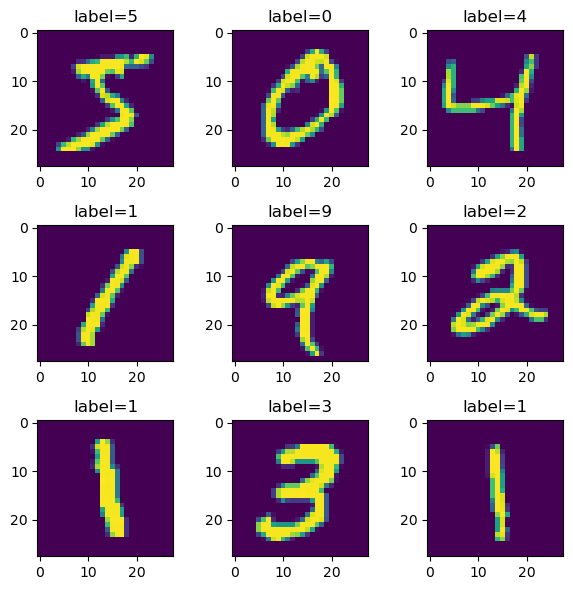

In [4]:
# Visualize Dataset
import matplotlib.pyplot as plt

grid = 3
fig, axes = plt.subplots(grid, grid, figsize=(6, 6))
for i in range(grid):
    for j in range(grid):
        axes[i][j].imshow(x_train[i * grid + j])
        axes[i][j].set_title(f"label={y_train[i * grid + j]}")
plt.tight_layout()

## Build Model
We will use the Keras 3.0 sequential API to build a simple CNN.

In [5]:
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)


def initialize_model():
    return keras.Sequential(
        [
            keras.Input(shape=INPUT_SHAPE),
            keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )


model = initialize_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,146 (74.79 KB)

 Trainable params: 19,146 (74.79 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model (Default Callback)
We will fit the model on the dataset, using MLflow's `mlflow.keras.MlflowCallback` to log metrics during training.

In [6]:
BATCH_SIZE = 64  # adjust this based on the memory of your machine
EPOCHS = 3

### Log Per Epoch
An epoch defined as one pass through the entire training dataset.

In [7]:
model = initialize_model()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

run = mlflow.start_run()
model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[mlflow.keras.MlflowCallback(run)],
)
mlflow.end_run()

Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5769 - loss: 1.3276 - val_accuracy: 0.9370 - val_loss: 0.2175
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 63s 75ms/step - accuracy: 0.9238 - loss: 0.2650 - val_accuracy: 0.9582 - val_loss: 0.1386
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - accuracy: 0.9468 - loss: 0.1738 - val_accuracy: 0.9618 - val_loss: 0.1293


### Log Results
The callback for the run would log **parameters**, **metrics** and **artifacts** to MLflow dashboard.

![run page](https://i.imgur.com/YLGFDJEl.png)

### Log Per Batch
Within each epoch, the training dataset is broken down to batches based on the defined `BATCH_SIZE`. If we set the callback to not log based on epochs with `log_every_epoch=False`, and to log every 5 batches with `log_every_n_steps=5`, we can adjust the logging to be based on the batches.

In [8]:
model = initialize_model()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

with mlflow.start_run() as run:
    model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        callbacks=[mlflow.keras.MlflowCallback(run, log_every_epoch=False, log_every_n_steps=5)],
    )

2025/03/26 23:33:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: MlflowCallback.__init__() got multiple values for argument 'log_every_epoch'


Epoch 1/3


2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  1/844 ━━━━━━━━━━━━━━━━━━━━ 38:53 3s/step - accuracy: 0.0625 - loss: 6.7159

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  2/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 83ms/step - accuracy: 0.0781 - loss: 5.9126

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  3/844 ━━━━━━━━━━━━━━━━━━━━ 1:13 87ms/step - accuracy: 0.0833 - loss: 5.4551

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  4/844 ━━━━━━━━━━━━━━━━━━━━ 1:24 101ms/step - accuracy: 0.0859 - loss: 5.1465

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  5/844 ━━━━━━━━━━━━━━━━━━━━ 1:22 99ms/step - accuracy: 0.0894 - loss: 4.9066 

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  6/844 ━━━━━━━━━━━━━━━━━━━━ 1:19 95ms/step - accuracy: 0.0905 - loss: 4.7249

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  7/844 ━━━━━━━━━━━━━━━━━━━━ 1:19 95ms/step - accuracy: 0.0923 - loss: 4.5729

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  8/844 ━━━━━━━━━━━━━━━━━━━━ 1:15 90ms/step - accuracy: 0.0932 - loss: 4.4419

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  9/844 ━━━━━━━━━━━━━━━━━━━━ 1:12 87ms/step - accuracy: 0.0940 - loss: 4.3283

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 10/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 84ms/step - accuracy: 0.0945 - loss: 4.2277

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 11/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 82ms/step - accuracy: 0.0947 - loss: 4.1379

2025/03/26 23:34:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 12/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 82ms/step - accuracy: 0.0952 - loss: 4.0570

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 13/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 81ms/step - accuracy: 0.0959 - loss: 3.9837

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 14/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 79ms/step - accuracy: 0.0971 - loss: 3.9170

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 15/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 79ms/step - accuracy: 0.0989 - loss: 3.8556

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 16/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 78ms/step - accuracy: 0.1004 - loss: 3.7991

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 17/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 77ms/step - accuracy: 0.1021 - loss: 3.7468

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 18/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 76ms/step - accuracy: 0.1036 - loss: 3.6985

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 19/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.1051 - loss: 3.6534

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 20/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 75ms/step - accuracy: 0.1064 - loss: 3.6113

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 21/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 75ms/step - accuracy: 0.1075 - loss: 3.5721

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 22/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 74ms/step - accuracy: 0.1084 - loss: 3.5353

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 23/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 74ms/step - accuracy: 0.1093 - loss: 3.5008

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 24/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 74ms/step - accuracy: 0.1103 - loss: 3.4683

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 25/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 75ms/step - accuracy: 0.1112 - loss: 3.4377

2025/03/26 23:34:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 26/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 76ms/step - accuracy: 0.1123 - loss: 3.4087

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 27/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 78ms/step - accuracy: 0.1133 - loss: 3.3812

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 28/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 78ms/step - accuracy: 0.1142 - loss: 3.3550

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 29/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 78ms/step - accuracy: 0.1151 - loss: 3.3301

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 30/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 78ms/step - accuracy: 0.1159 - loss: 3.3063

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 31/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 78ms/step - accuracy: 0.1167 - loss: 3.2836

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 32/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 78ms/step - accuracy: 0.1174 - loss: 3.2619

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 33/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 78ms/step - accuracy: 0.1180 - loss: 3.2411

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 34/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 78ms/step - accuracy: 0.1186 - loss: 3.2212

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 35/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 78ms/step - accuracy: 0.1192 - loss: 3.2021

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 36/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 77ms/step - accuracy: 0.1197 - loss: 3.1838

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 37/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 77ms/step - accuracy: 0.1202 - loss: 3.1661

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 38/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 77ms/step - accuracy: 0.1208 - loss: 3.1491

2025/03/26 23:34:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 39/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 77ms/step - accuracy: 0.1213 - loss: 3.1328

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 40/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 77ms/step - accuracy: 0.1219 - loss: 3.1170

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 41/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 76ms/step - accuracy: 0.1225 - loss: 3.1017

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 42/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 77ms/step - accuracy: 0.1231 - loss: 3.0870

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 43/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 76ms/step - accuracy: 0.1238 - loss: 3.0727

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 44/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 76ms/step - accuracy: 0.1245 - loss: 3.0589

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 45/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 76ms/step - accuracy: 0.1254 - loss: 3.0456

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 46/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 76ms/step - accuracy: 0.1262 - loss: 3.0326

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 47/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 76ms/step - accuracy: 0.1271 - loss: 3.0200

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 48/844 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.1280 - loss: 3.0078 

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 49/844 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.1289 - loss: 2.9959

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 50/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 77ms/step - accuracy: 0.1299 - loss: 2.9844

2025/03/26 23:34:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 51/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 78ms/step - accuracy: 0.1308 - loss: 2.9731

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 52/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 78ms/step - accuracy: 0.1318 - loss: 2.9621

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 53/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 78ms/step - accuracy: 0.1328 - loss: 2.9514

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 54/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 78ms/step - accuracy: 0.1338 - loss: 2.9410

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 55/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 78ms/step - accuracy: 0.1349 - loss: 2.9308

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 56/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 78ms/step - accuracy: 0.1359 - loss: 2.9208

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 57/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 77ms/step - accuracy: 0.1370 - loss: 2.9111

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 58/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 77ms/step - accuracy: 0.1381 - loss: 2.9016

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 59/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 77ms/step - accuracy: 0.1391 - loss: 2.8923

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 60/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 77ms/step - accuracy: 0.1402 - loss: 2.8832

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 61/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 77ms/step - accuracy: 0.1413 - loss: 2.8743

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 62/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 77ms/step - accuracy: 0.1423 - loss: 2.8655

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 63/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1434 - loss: 2.8569 

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 64/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1445 - loss: 2.8485

2025/03/26 23:34:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 65/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1456 - loss: 2.8402

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 66/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1467 - loss: 2.8321

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 67/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1478 - loss: 2.8241

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 68/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1489 - loss: 2.8163

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 69/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1501 - loss: 2.8086

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 70/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1513 - loss: 2.8010

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 71/844 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1524 - loss: 2.7935

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 72/844 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.1537 - loss: 2.7861

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 73/844 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.1549 - loss: 2.7788

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 74/844 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.1561 - loss: 2.7717

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 75/844 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.1573 - loss: 2.7646

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 76/844 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.1585 - loss: 2.7576

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 77/844 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.1597 - loss: 2.7507

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 78/844 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.1610 - loss: 2.7439

2025/03/26 23:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 79/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1622 - loss: 2.7371

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 80/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1634 - loss: 2.7305

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 81/844 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.1646 - loss: 2.7239

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 82/844 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.1659 - loss: 2.7174

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 83/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1671 - loss: 2.7109

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 84/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1683 - loss: 2.7045

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 85/844 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.1695 - loss: 2.6982

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 86/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1707 - loss: 2.6920

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 87/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1718 - loss: 2.6858

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 88/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1730 - loss: 2.6797

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 89/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1742 - loss: 2.6737

2025/03/26 23:34:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 90/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1754 - loss: 2.6677

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 91/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1766 - loss: 2.6617

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 92/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1777 - loss: 2.6559

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 93/844 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.1789 - loss: 2.6501

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 94/844 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.1801 - loss: 2.6443

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 95/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1812 - loss: 2.6386

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 96/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1824 - loss: 2.6329

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 97/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1835 - loss: 2.6273

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 98/844 ━━━━━━━━━━━━━━━━━━━━ 57s 78ms/step - accuracy: 0.1847 - loss: 2.6218

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 99/844 ━━━━━━━━━━━━━━━━━━━━ 57s 78ms/step - accuracy: 0.1858 - loss: 2.6162

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


100/844 ━━━━━━━━━━━━━━━━━━━━ 57s 78ms/step - accuracy: 0.1870 - loss: 2.6108

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


101/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1881 - loss: 2.6053

2025/03/26 23:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


102/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1893 - loss: 2.5999

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


103/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1904 - loss: 2.5945

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


104/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1916 - loss: 2.5892

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


105/844 ━━━━━━━━━━━━━━━━━━━━ 58s 79ms/step - accuracy: 0.1928 - loss: 2.5839

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


106/844 ━━━━━━━━━━━━━━━━━━━━ 58s 79ms/step - accuracy: 0.1939 - loss: 2.5786

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


107/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1951 - loss: 2.5734

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


108/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1963 - loss: 2.5682

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


109/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1974 - loss: 2.5630

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


110/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1986 - loss: 2.5579

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


111/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1997 - loss: 2.5528

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


112/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.2009 - loss: 2.5477

2025/03/26 23:34:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


113/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.2020 - loss: 2.5427

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


114/844 ━━━━━━━━━━━━━━━━━━━━ 58s 79ms/step - accuracy: 0.2031 - loss: 2.5377

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


115/844 ━━━━━━━━━━━━━━━━━━━━ 58s 80ms/step - accuracy: 0.2043 - loss: 2.5328

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


116/844 ━━━━━━━━━━━━━━━━━━━━ 58s 80ms/step - accuracy: 0.2054 - loss: 2.5278

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


117/844 ━━━━━━━━━━━━━━━━━━━━ 58s 80ms/step - accuracy: 0.2065 - loss: 2.5230

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


118/844 ━━━━━━━━━━━━━━━━━━━━ 58s 80ms/step - accuracy: 0.2076 - loss: 2.5181

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


119/844 ━━━━━━━━━━━━━━━━━━━━ 58s 80ms/step - accuracy: 0.2087 - loss: 2.5133

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


120/844 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.2099 - loss: 2.5085

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


121/844 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.2110 - loss: 2.5037

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


122/844 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.2121 - loss: 2.4990

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


123/844 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.2132 - loss: 2.4943

2025/03/26 23:34:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


124/844 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.2143 - loss: 2.4896

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


125/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2154 - loss: 2.4850

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


126/844 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - accuracy: 0.2165 - loss: 2.4803

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


127/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2176 - loss: 2.4757

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


128/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2187 - loss: 2.4712

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


129/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2198 - loss: 2.4666

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


130/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2209 - loss: 2.4621

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


131/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2220 - loss: 2.4576

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


132/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2231 - loss: 2.4532

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


133/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2242 - loss: 2.4487

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


134/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2253 - loss: 2.4443

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


135/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2263 - loss: 2.4399

2025/03/26 23:34:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


136/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2274 - loss: 2.4356

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


137/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2284 - loss: 2.4312

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


138/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2295 - loss: 2.4269

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


139/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2305 - loss: 2.4227

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


140/844 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2316 - loss: 2.4184

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


141/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2326 - loss: 2.4142

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


142/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2336 - loss: 2.4100

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


143/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2347 - loss: 2.4059

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


144/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2357 - loss: 2.4017

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


145/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2367 - loss: 2.3976

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


146/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2378 - loss: 2.3935

2025/03/26 23:34:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


147/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2388 - loss: 2.3894

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


148/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2398 - loss: 2.3854

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


149/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2409 - loss: 2.3813

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


150/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2419 - loss: 2.3773

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


151/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2429 - loss: 2.3733

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


152/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2440 - loss: 2.3693

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


153/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2450 - loss: 2.3654

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


154/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2460 - loss: 2.3614

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


155/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2471 - loss: 2.3575

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


156/844 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.2481 - loss: 2.3536

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


157/844 ━━━━━━━━━━━━━━━━━━━━ 56s 82ms/step - accuracy: 0.2491 - loss: 2.3497

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


158/844 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.2501 - loss: 2.3459

2025/03/26 23:34:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


159/844 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.2512 - loss: 2.3420

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


160/844 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.2522 - loss: 2.3382

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


161/844 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.2532 - loss: 2.3344

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


162/844 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.2542 - loss: 2.3306

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


163/844 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.2553 - loss: 2.3268

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


164/844 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.2563 - loss: 2.3230

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


165/844 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - accuracy: 0.2573 - loss: 2.3193

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


166/844 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - accuracy: 0.2583 - loss: 2.3155

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


167/844 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - accuracy: 0.2594 - loss: 2.3118

2025/03/26 23:34:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


168/844 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - accuracy: 0.2604 - loss: 2.3081

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


169/844 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - accuracy: 0.2614 - loss: 2.3044

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


170/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2624 - loss: 2.3008

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


171/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2634 - loss: 2.2972

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


172/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2644 - loss: 2.2936

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


173/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2654 - loss: 2.2900

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


174/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2664 - loss: 2.2864

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


175/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2674 - loss: 2.2828

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


176/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2684 - loss: 2.2793

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


177/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2694 - loss: 2.2758

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


178/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2704 - loss: 2.2723

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


179/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2714 - loss: 2.2688

2025/03/26 23:34:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


180/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2724 - loss: 2.2653

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


181/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2733 - loss: 2.2619

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


182/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2743 - loss: 2.2584

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


183/844 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.2753 - loss: 2.2550

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


184/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.2762 - loss: 2.2516

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


185/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.2772 - loss: 2.2482

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


186/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.2782 - loss: 2.2448

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


187/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.2791 - loss: 2.2415

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


188/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.2801 - loss: 2.2381

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


189/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2811 - loss: 2.2348

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


190/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2820 - loss: 2.2315

2025/03/26 23:34:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


191/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2830 - loss: 2.2282

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


192/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2839 - loss: 2.2249

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


193/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2849 - loss: 2.2216

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


194/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2858 - loss: 2.2184

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


195/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2868 - loss: 2.2152

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


196/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2877 - loss: 2.2120

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


197/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2886 - loss: 2.2088

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


198/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2895 - loss: 2.2056

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


199/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2905 - loss: 2.2024

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


200/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2914 - loss: 2.1993

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


201/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.2923 - loss: 2.1962

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


202/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.2932 - loss: 2.1930

2025/03/26 23:34:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


203/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.2941 - loss: 2.1899

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


204/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2950 - loss: 2.1868

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


205/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2959 - loss: 2.1838

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


206/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2968 - loss: 2.1807

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


207/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2977 - loss: 2.1776

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


208/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.2986 - loss: 2.1746

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


209/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.2995 - loss: 2.1716

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


210/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.3004 - loss: 2.1686

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


211/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.3013 - loss: 2.1656

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


212/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.3022 - loss: 2.1626

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


213/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.3031 - loss: 2.1597

2025/03/26 23:34:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


214/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.3040 - loss: 2.1567

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


215/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.3048 - loss: 2.1538

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


216/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.3057 - loss: 2.1508

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


217/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3066 - loss: 2.1479

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


218/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3075 - loss: 2.1450

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


219/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3083 - loss: 2.1421

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


220/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3092 - loss: 2.1392

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


221/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3101 - loss: 2.1363

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


222/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3109 - loss: 2.1334

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


223/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3118 - loss: 2.1306

2025/03/26 23:34:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


224/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3126 - loss: 2.1277

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


225/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3135 - loss: 2.1249

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


226/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3143 - loss: 2.1221

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


227/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3152 - loss: 2.1193

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


228/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3160 - loss: 2.1165

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


229/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3169 - loss: 2.1137

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


230/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.3177 - loss: 2.1109

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


231/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3186 - loss: 2.1081

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


232/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3194 - loss: 2.1053

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


233/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3202 - loss: 2.1026

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


234/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3211 - loss: 2.0998

2025/03/26 23:34:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


235/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3219 - loss: 2.0971

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


236/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3227 - loss: 2.0944

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


237/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3236 - loss: 2.0917

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


238/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3244 - loss: 2.0890

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


239/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.3252 - loss: 2.0863

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


240/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3260 - loss: 2.0836

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


241/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3269 - loss: 2.0809

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


242/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3277 - loss: 2.0783

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


243/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3285 - loss: 2.0756

2025/03/26 23:34:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


244/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3293 - loss: 2.0730

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


245/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3301 - loss: 2.0704

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


246/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3309 - loss: 2.0677

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


247/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3317 - loss: 2.0651

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


248/844 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3325 - loss: 2.0625

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


249/844 ━━━━━━━━━━━━━━━━━━━━ 50s 86ms/step - accuracy: 0.3333 - loss: 2.0599

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


250/844 ━━━━━━━━━━━━━━━━━━━━ 50s 86ms/step - accuracy: 0.3341 - loss: 2.0573

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


251/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.3349 - loss: 2.0548

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


252/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.3357 - loss: 2.0522

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


253/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.3365 - loss: 2.0497

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


254/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.3373 - loss: 2.0471

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


255/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.3381 - loss: 2.0446

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


256/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.3389 - loss: 2.0421

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


257/844 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.3397 - loss: 2.0395

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


258/844 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.3405 - loss: 2.0370

2025/03/26 23:34:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


259/844 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.3412 - loss: 2.0345

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


260/844 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.3420 - loss: 2.0320

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


261/844 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.3428 - loss: 2.0295

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


262/844 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.3436 - loss: 2.0271

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


263/844 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.3443 - loss: 2.0246

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


264/844 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.3451 - loss: 2.0221

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


265/844 ━━━━━━━━━━━━━━━━━━━━ 48s 85ms/step - accuracy: 0.3459 - loss: 2.0197

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


266/844 ━━━━━━━━━━━━━━━━━━━━ 48s 85ms/step - accuracy: 0.3466 - loss: 2.0172

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


267/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.3474 - loss: 2.0148

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


268/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.3482 - loss: 2.0123

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


269/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.3489 - loss: 2.0099

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


270/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.3497 - loss: 2.0075

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


271/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.3504 - loss: 2.0051

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


272/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.3512 - loss: 2.0027

2025/03/26 23:34:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


273/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.3519 - loss: 2.0003

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


274/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3527 - loss: 1.9979

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


275/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3534 - loss: 1.9956

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


276/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3542 - loss: 1.9932

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


277/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3549 - loss: 1.9908

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


278/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3557 - loss: 1.9885

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


279/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3564 - loss: 1.9862

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


280/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3571 - loss: 1.9838

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


281/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3578 - loss: 1.9815

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


282/844 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.3586 - loss: 1.9792

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


283/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3593 - loss: 1.9769

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


284/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3600 - loss: 1.9746

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


285/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3608 - loss: 1.9723

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


286/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3615 - loss: 1.9700

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


287/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3622 - loss: 1.9677

2025/03/26 23:34:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


288/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3629 - loss: 1.9654

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


289/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3636 - loss: 1.9632

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


290/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3643 - loss: 1.9609

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


291/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3650 - loss: 1.9587

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


292/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3657 - loss: 1.9564

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


293/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3664 - loss: 1.9542

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


294/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3671 - loss: 1.9520

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


295/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3678 - loss: 1.9498

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


296/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3685 - loss: 1.9475

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


297/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3692 - loss: 1.9453

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


298/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3699 - loss: 1.9431

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


299/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.3706 - loss: 1.9409

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


300/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.3713 - loss: 1.9388

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


301/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.3720 - loss: 1.9366

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


302/844 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.3727 - loss: 1.9344

2025/03/26 23:34:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


303/844 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.3734 - loss: 1.9322

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


304/844 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.3741 - loss: 1.9301

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


305/844 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.3747 - loss: 1.9279

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


306/844 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.3754 - loss: 1.9258

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


307/844 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.3761 - loss: 1.9236

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


308/844 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.3768 - loss: 1.9215

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


309/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3774 - loss: 1.9194

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


310/844 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.3781 - loss: 1.9172

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


311/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.3788 - loss: 1.9151

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


312/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3794 - loss: 1.9130

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


313/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3801 - loss: 1.9109

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


314/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3808 - loss: 1.9088

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


315/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3814 - loss: 1.9067

2025/03/26 23:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


316/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3821 - loss: 1.9047

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


317/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3828 - loss: 1.9026

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


318/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3834 - loss: 1.9005

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


319/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3841 - loss: 1.8985

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


320/844 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.3847 - loss: 1.8964

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


321/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3854 - loss: 1.8944

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


322/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3860 - loss: 1.8923

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


323/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3867 - loss: 1.8903

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


324/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3873 - loss: 1.8883

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


325/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3880 - loss: 1.8862

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


326/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3886 - loss: 1.8842

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


327/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3893 - loss: 1.8822

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


328/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3899 - loss: 1.8802

2025/03/26 23:34:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


329/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3905 - loss: 1.8782

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


330/844 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.3912 - loss: 1.8762

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


331/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3918 - loss: 1.8742

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


332/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3924 - loss: 1.8723

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


333/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3931 - loss: 1.8703

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


334/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3937 - loss: 1.8683

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


335/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3943 - loss: 1.8664

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


336/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3950 - loss: 1.8644

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


337/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3956 - loss: 1.8624

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


338/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3962 - loss: 1.8605

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


339/844 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.3968 - loss: 1.8586

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


340/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3974 - loss: 1.8566

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


341/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3981 - loss: 1.8547

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


342/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3987 - loss: 1.8528

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


343/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3993 - loss: 1.8509

2025/03/26 23:34:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


344/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3999 - loss: 1.8489

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


345/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.4005 - loss: 1.8470

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


346/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.4011 - loss: 1.8451

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


347/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.4018 - loss: 1.8432

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


348/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.4024 - loss: 1.8413

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


349/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.4030 - loss: 1.8395

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


350/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.4036 - loss: 1.8376

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


351/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.4042 - loss: 1.8357

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


352/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4048 - loss: 1.8338

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


353/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4054 - loss: 1.8320

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


354/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4060 - loss: 1.8301

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


355/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4066 - loss: 1.8282

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


356/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4072 - loss: 1.8264

2025/03/26 23:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


357/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4078 - loss: 1.8245

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


358/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4084 - loss: 1.8227

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


359/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4090 - loss: 1.8208

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


360/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4096 - loss: 1.8190

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


361/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4102 - loss: 1.8172

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


362/844 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.4107 - loss: 1.8154

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


363/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4113 - loss: 1.8135

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


364/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4119 - loss: 1.8117

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


365/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4125 - loss: 1.8099

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


366/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4131 - loss: 1.8081

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


367/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4137 - loss: 1.8063

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


368/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4142 - loss: 1.8045

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


369/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4148 - loss: 1.8027

2025/03/26 23:34:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


370/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4154 - loss: 1.8010

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


371/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4160 - loss: 1.7992

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


372/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4165 - loss: 1.7974

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


373/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4171 - loss: 1.7956

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


374/844 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.4177 - loss: 1.7939

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


375/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4183 - loss: 1.7921

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


376/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4188 - loss: 1.7903

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


377/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4194 - loss: 1.7886

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


378/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4200 - loss: 1.7868

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


379/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4205 - loss: 1.7851

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


380/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4211 - loss: 1.7833

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


381/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4217 - loss: 1.7816

2025/03/26 23:34:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


382/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4222 - loss: 1.7799

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


383/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4228 - loss: 1.7782

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


384/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4233 - loss: 1.7764

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


385/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4239 - loss: 1.7747

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


386/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4244 - loss: 1.7730

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


387/844 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4250 - loss: 1.7713

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


388/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4256 - loss: 1.7696

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


389/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4261 - loss: 1.7679

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


390/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4267 - loss: 1.7662

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


391/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4272 - loss: 1.7645

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


392/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4278 - loss: 1.7628

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


393/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4283 - loss: 1.7611

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


394/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4289 - loss: 1.7594

2025/03/26 23:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


395/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4294 - loss: 1.7577

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


396/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4299 - loss: 1.7561

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


397/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4305 - loss: 1.7544

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


398/844 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4310 - loss: 1.7527

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


399/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4316 - loss: 1.7511

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


400/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4321 - loss: 1.7494

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


401/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4326 - loss: 1.7477

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


402/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4332 - loss: 1.7461

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


403/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4337 - loss: 1.7444

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


404/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4343 - loss: 1.7428

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


405/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4348 - loss: 1.7412

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


406/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4353 - loss: 1.7395

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


407/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4358 - loss: 1.7379

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


408/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4364 - loss: 1.7363

2025/03/26 23:34:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


409/844 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.4369 - loss: 1.7347

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


410/844 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.4374 - loss: 1.7330

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


411/844 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.4380 - loss: 1.7314

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


412/844 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.4385 - loss: 1.7298

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


413/844 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.4390 - loss: 1.7282

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


414/844 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.4395 - loss: 1.7266

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


415/844 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.4401 - loss: 1.7250

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


416/844 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.4406 - loss: 1.7234

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


417/844 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.4411 - loss: 1.7219

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


418/844 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.4416 - loss: 1.7203

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


419/844 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.4421 - loss: 1.7187

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


420/844 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.4426 - loss: 1.7171

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


421/844 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.4432 - loss: 1.7155

2025/03/26 23:34:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


422/844 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.4437 - loss: 1.7140

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


423/844 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.4442 - loss: 1.7124

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


424/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4447 - loss: 1.7108

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


425/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4452 - loss: 1.7093

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


426/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4457 - loss: 1.7077

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


427/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4462 - loss: 1.7062

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


428/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4467 - loss: 1.7046

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


429/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4472 - loss: 1.7031

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


430/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4477 - loss: 1.7015

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


431/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4482 - loss: 1.7000

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


432/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4487 - loss: 1.6985

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


433/844 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4492 - loss: 1.6969

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


434/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4497 - loss: 1.6954

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


435/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4502 - loss: 1.6939

2025/03/26 23:34:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


436/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4507 - loss: 1.6924

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


437/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4512 - loss: 1.6909

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


438/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4517 - loss: 1.6893

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


439/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4522 - loss: 1.6878

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


440/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4527 - loss: 1.6863

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


441/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4532 - loss: 1.6848

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


442/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4537 - loss: 1.6833

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


443/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4542 - loss: 1.6818

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


444/844 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.4547 - loss: 1.6804

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


445/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4552 - loss: 1.6789

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


446/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4557 - loss: 1.6774

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


447/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4562 - loss: 1.6759

2025/03/26 23:34:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


448/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4566 - loss: 1.6744

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


449/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4571 - loss: 1.6730

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


450/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4576 - loss: 1.6715

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


451/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4581 - loss: 1.6700

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


452/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4586 - loss: 1.6686

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


453/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4591 - loss: 1.6671

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


454/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4595 - loss: 1.6656

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


455/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4600 - loss: 1.6642

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


456/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4605 - loss: 1.6627

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


457/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4610 - loss: 1.6613

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


458/844 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4614 - loss: 1.6598

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


459/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4619 - loss: 1.6584

2025/03/26 23:34:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


460/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4624 - loss: 1.6570

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


461/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4629 - loss: 1.6555

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


462/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4633 - loss: 1.6541

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


463/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4638 - loss: 1.6527

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


464/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4643 - loss: 1.6512

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


465/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4647 - loss: 1.6498

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


466/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4652 - loss: 1.6484

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


467/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4657 - loss: 1.6470

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


468/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4661 - loss: 1.6456

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


469/844 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4666 - loss: 1.6442

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


470/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4670 - loss: 1.6428

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


471/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4675 - loss: 1.6414

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


472/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4680 - loss: 1.6400

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


473/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4684 - loss: 1.6386

2025/03/26 23:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


474/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4689 - loss: 1.6372

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


475/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4693 - loss: 1.6358

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


476/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4698 - loss: 1.6344

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


477/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4702 - loss: 1.6330

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


478/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4707 - loss: 1.6316

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


479/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4712 - loss: 1.6303

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


480/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4716 - loss: 1.6289

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


481/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4721 - loss: 1.6275

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


482/844 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.4725 - loss: 1.6262

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


483/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4729 - loss: 1.6248

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


484/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4734 - loss: 1.6235

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


485/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4738 - loss: 1.6221

2025/03/26 23:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


486/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4743 - loss: 1.6208

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


487/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4747 - loss: 1.6194

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


488/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4752 - loss: 1.6181

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


489/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4756 - loss: 1.6168

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


490/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4760 - loss: 1.6154

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


491/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4765 - loss: 1.6141

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


492/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4769 - loss: 1.6128

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


493/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4774 - loss: 1.6114

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


494/844 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4778 - loss: 1.6101

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


495/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4782 - loss: 1.6088

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


496/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4787 - loss: 1.6075

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


497/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4791 - loss: 1.6062

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


498/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4795 - loss: 1.6049

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


499/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4799 - loss: 1.6036

2025/03/26 23:34:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


500/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4804 - loss: 1.6023

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


501/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4808 - loss: 1.6010

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


502/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4812 - loss: 1.5997

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


503/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4817 - loss: 1.5984

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


504/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4821 - loss: 1.5971

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


505/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4825 - loss: 1.5958

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


506/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4829 - loss: 1.5945

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


507/844 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4833 - loss: 1.5933

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


508/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4838 - loss: 1.5920

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


509/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4842 - loss: 1.5907

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


510/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4846 - loss: 1.5894

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


511/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4850 - loss: 1.5882

2025/03/26 23:34:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


512/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4854 - loss: 1.5869

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


513/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4858 - loss: 1.5857

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


514/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4863 - loss: 1.5844

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


515/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4867 - loss: 1.5831

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


516/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4871 - loss: 1.5819

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


517/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4875 - loss: 1.5806

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


518/844 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4879 - loss: 1.5794

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


519/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4883 - loss: 1.5781

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


520/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4887 - loss: 1.5769

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


521/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4891 - loss: 1.5757

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


522/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4895 - loss: 1.5744

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


523/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4900 - loss: 1.5732

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


524/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4904 - loss: 1.5719

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


525/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4908 - loss: 1.5707

2025/03/26 23:34:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


526/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4912 - loss: 1.5695

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


527/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4916 - loss: 1.5683

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


528/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4920 - loss: 1.5670

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


529/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4924 - loss: 1.5658

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


530/844 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4928 - loss: 1.5646

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


531/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4932 - loss: 1.5634

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


532/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4936 - loss: 1.5622

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


533/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4940 - loss: 1.5610

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


534/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4944 - loss: 1.5598

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


535/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4948 - loss: 1.5586

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


536/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4952 - loss: 1.5574

2025/03/26 23:34:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


537/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4955 - loss: 1.5562

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


538/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4959 - loss: 1.5550

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


539/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4963 - loss: 1.5538

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


540/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4967 - loss: 1.5526

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


541/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4971 - loss: 1.5514

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


542/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4975 - loss: 1.5502

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


543/844 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.4979 - loss: 1.5491

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


544/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.4983 - loss: 1.5479

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


545/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.4987 - loss: 1.5467

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


546/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.4991 - loss: 1.5455

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


547/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.4994 - loss: 1.5444

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


548/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.4998 - loss: 1.5432

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


549/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.5002 - loss: 1.5420

2025/03/26 23:34:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


550/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.5006 - loss: 1.5408

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


551/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.5010 - loss: 1.5397

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


552/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.5014 - loss: 1.5385

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


553/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.5017 - loss: 1.5374

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


554/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.5021 - loss: 1.5362

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


555/844 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.5025 - loss: 1.5351

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


556/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5029 - loss: 1.5339

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


557/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5033 - loss: 1.5328

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


558/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5036 - loss: 1.5316

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


559/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5040 - loss: 1.5305

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


560/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5044 - loss: 1.5293

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


561/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5048 - loss: 1.5282

2025/03/26 23:34:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


562/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5051 - loss: 1.5271

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


563/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5055 - loss: 1.5259

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


564/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5059 - loss: 1.5248

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


565/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5063 - loss: 1.5237

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


566/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5066 - loss: 1.5225

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


567/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5070 - loss: 1.5214

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


568/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5074 - loss: 1.5203

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


569/844 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5077 - loss: 1.5192

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


570/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5081 - loss: 1.5180

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


571/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5085 - loss: 1.5169

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


572/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5089 - loss: 1.5158

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


573/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5092 - loss: 1.5147

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


574/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5096 - loss: 1.5136

2025/03/26 23:34:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


575/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5100 - loss: 1.5125

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


576/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5103 - loss: 1.5114

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


577/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5107 - loss: 1.5103

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


578/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5110 - loss: 1.5092

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


579/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5114 - loss: 1.5081

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


580/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5118 - loss: 1.5070

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


581/844 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5121 - loss: 1.5059

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


582/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5125 - loss: 1.5048

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


583/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5129 - loss: 1.5037

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


584/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5132 - loss: 1.5026

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


585/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5136 - loss: 1.5015

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


586/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5139 - loss: 1.5004

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


587/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5143 - loss: 1.4994

2025/03/26 23:34:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


588/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5146 - loss: 1.4983

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


589/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5150 - loss: 1.4972

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


590/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5154 - loss: 1.4961

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


591/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5157 - loss: 1.4950

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


592/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5161 - loss: 1.4940

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


593/844 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5164 - loss: 1.4929

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


594/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5168 - loss: 1.4918

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


595/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5171 - loss: 1.4908

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


596/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5175 - loss: 1.4897

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


597/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5178 - loss: 1.4887

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


598/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5182 - loss: 1.4876

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


599/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5185 - loss: 1.4866

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


600/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5189 - loss: 1.4855

2025/03/26 23:34:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


601/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5192 - loss: 1.4844

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


602/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5196 - loss: 1.4834

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


603/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5199 - loss: 1.4823

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


604/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5203 - loss: 1.4813

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


605/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5206 - loss: 1.4803

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


606/844 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5210 - loss: 1.4792

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


607/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5213 - loss: 1.4782

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


608/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5216 - loss: 1.4771

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


609/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5220 - loss: 1.4761

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


610/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5223 - loss: 1.4751

2025/03/26 23:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


611/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5227 - loss: 1.4740

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


612/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5230 - loss: 1.4730

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


613/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5233 - loss: 1.4720

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


614/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5237 - loss: 1.4710

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


615/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5240 - loss: 1.4699

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


616/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5244 - loss: 1.4689

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


617/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5247 - loss: 1.4679

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


618/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5250 - loss: 1.4669

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


619/844 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5254 - loss: 1.4659

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


620/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5257 - loss: 1.4648

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


621/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5260 - loss: 1.4638

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


622/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5264 - loss: 1.4628

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


623/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5267 - loss: 1.4618

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


624/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5270 - loss: 1.4608

2025/03/26 23:34:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


625/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5274 - loss: 1.4598

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


626/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5277 - loss: 1.4588

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


627/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5280 - loss: 1.4578

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


628/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5284 - loss: 1.4568

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


629/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5287 - loss: 1.4558

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


630/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5290 - loss: 1.4548

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


631/844 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.5294 - loss: 1.4538

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


632/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5297 - loss: 1.4528

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


633/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5300 - loss: 1.4518

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


634/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5304 - loss: 1.4508

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


635/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5307 - loss: 1.4498

2025/03/26 23:34:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


636/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5310 - loss: 1.4488

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


637/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5313 - loss: 1.4479

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


638/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5317 - loss: 1.4469

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


639/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5320 - loss: 1.4459

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


640/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5323 - loss: 1.4449

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


641/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5326 - loss: 1.4439

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


642/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5330 - loss: 1.4430

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


643/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5333 - loss: 1.4420

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


644/844 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5336 - loss: 1.4410

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


645/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5339 - loss: 1.4401

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


646/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5342 - loss: 1.4391

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


647/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5346 - loss: 1.4381

2025/03/26 23:34:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


648/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5349 - loss: 1.4372

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


649/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5352 - loss: 1.4362

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


650/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5355 - loss: 1.4352

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


651/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5358 - loss: 1.4343

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


652/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5362 - loss: 1.4333

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


653/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5365 - loss: 1.4324

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


654/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5368 - loss: 1.4314

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


655/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5371 - loss: 1.4305

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


656/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5374 - loss: 1.4295

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


657/844 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5377 - loss: 1.4286

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


658/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5381 - loss: 1.4276

2025/03/26 23:34:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


659/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5384 - loss: 1.4267

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


660/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5387 - loss: 1.4257

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


661/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5390 - loss: 1.4248

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


662/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5393 - loss: 1.4238

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


663/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5396 - loss: 1.4229

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


664/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5399 - loss: 1.4219

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


665/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5402 - loss: 1.4210

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


666/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5405 - loss: 1.4201

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


667/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5409 - loss: 1.4191

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


668/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5412 - loss: 1.4182

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


669/844 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.5415 - loss: 1.4173

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


670/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5418 - loss: 1.4163

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


671/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5421 - loss: 1.4154

2025/03/26 23:34:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


672/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5424 - loss: 1.4145

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


673/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5427 - loss: 1.4136

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


674/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5430 - loss: 1.4126

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


675/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5433 - loss: 1.4117

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


676/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5436 - loss: 1.4108

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


677/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5439 - loss: 1.4099

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


678/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5442 - loss: 1.4090

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


679/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5445 - loss: 1.4080

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


680/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5448 - loss: 1.4071

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


681/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5451 - loss: 1.4062

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


682/844 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5454 - loss: 1.4053

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


683/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5457 - loss: 1.4044

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


684/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5460 - loss: 1.4035

2025/03/26 23:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


685/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5463 - loss: 1.4026

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


686/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5466 - loss: 1.4017

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


687/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5469 - loss: 1.4008

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


688/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5472 - loss: 1.3999

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


689/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5475 - loss: 1.3990

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


690/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5478 - loss: 1.3981

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


691/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5481 - loss: 1.3972

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


692/844 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5484 - loss: 1.3963

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


693/844 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.5487 - loss: 1.3954

2025/03/26 23:34:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


694/844 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.5490 - loss: 1.3945

2025/03/26 23:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


695/844 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.5493 - loss: 1.3936

2025/03/26 23:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


696/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5496 - loss: 1.3928

2025/03/26 23:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


697/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5499 - loss: 1.3919

2025/03/26 23:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


698/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5502 - loss: 1.3910

2025/03/26 23:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


699/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5505 - loss: 1.3901

2025/03/26 23:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


700/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5508 - loss: 1.3892

2025/03/26 23:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


701/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5511 - loss: 1.3884

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


702/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5514 - loss: 1.3875

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


703/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5517 - loss: 1.3866

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


704/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5519 - loss: 1.3857

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


705/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5522 - loss: 1.3849

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


706/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5525 - loss: 1.3840

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


707/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5528 - loss: 1.3831

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


708/844 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.5531 - loss: 1.3822

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


709/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5534 - loss: 1.3814

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


710/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5537 - loss: 1.3805

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


711/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5540 - loss: 1.3797

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


712/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5542 - loss: 1.3788

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


713/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5545 - loss: 1.3779

2025/03/26 23:34:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


714/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5548 - loss: 1.3771

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


715/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5551 - loss: 1.3762

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


716/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5554 - loss: 1.3754

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


717/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5557 - loss: 1.3745

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


718/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5560 - loss: 1.3737

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


719/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5562 - loss: 1.3728

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


720/844 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5565 - loss: 1.3720

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


721/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5568 - loss: 1.3711 

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


722/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5571 - loss: 1.3703

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


723/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5574 - loss: 1.3694

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


724/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5576 - loss: 1.3686

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


725/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5579 - loss: 1.3677

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


726/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5582 - loss: 1.3669

2025/03/26 23:34:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


727/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5585 - loss: 1.3660

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


728/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5588 - loss: 1.3652

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


729/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5590 - loss: 1.3644

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


730/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5593 - loss: 1.3635

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


731/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5596 - loss: 1.3627

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


732/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5599 - loss: 1.3619

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


733/844 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5601 - loss: 1.3610

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


734/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5604 - loss: 1.3602

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


735/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5607 - loss: 1.3594

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


736/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5610 - loss: 1.3586

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


737/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5612 - loss: 1.3577

2025/03/26 23:35:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


738/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5615 - loss: 1.3569

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


739/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5618 - loss: 1.3561

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


740/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5621 - loss: 1.3553

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


741/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5623 - loss: 1.3544

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


742/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5626 - loss: 1.3536

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


743/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5629 - loss: 1.3528

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


744/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5631 - loss: 1.3520

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


745/844 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5634 - loss: 1.3512

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


746/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5637 - loss: 1.3504

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


747/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5640 - loss: 1.3496

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


748/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5642 - loss: 1.3487

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


749/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5645 - loss: 1.3479

2025/03/26 23:35:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


750/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5648 - loss: 1.3471

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


751/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5650 - loss: 1.3463

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


752/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5653 - loss: 1.3455

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


753/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5656 - loss: 1.3447

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


754/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5658 - loss: 1.3439

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


755/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5661 - loss: 1.3431

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


756/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5664 - loss: 1.3423

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


757/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5666 - loss: 1.3415

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


758/844 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5669 - loss: 1.3407

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


759/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5672 - loss: 1.3399

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


760/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5674 - loss: 1.3391

2025/03/26 23:35:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


761/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5677 - loss: 1.3383

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


762/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5680 - loss: 1.3375

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


763/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5682 - loss: 1.3368

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


764/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5685 - loss: 1.3360

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


765/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5687 - loss: 1.3352

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


766/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5690 - loss: 1.3344

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


767/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5693 - loss: 1.3336

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


768/844 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5695 - loss: 1.3328

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


769/844 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5698 - loss: 1.3320

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


770/844 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5700 - loss: 1.3313

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


771/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5703 - loss: 1.3305

2025/03/26 23:35:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


772/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5706 - loss: 1.3297

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


773/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5708 - loss: 1.3289

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


774/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5711 - loss: 1.3281

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


775/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5713 - loss: 1.3274

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


776/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5716 - loss: 1.3266

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


777/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5718 - loss: 1.3258

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


778/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5721 - loss: 1.3251

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


779/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5724 - loss: 1.3243

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


780/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5726 - loss: 1.3235

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


781/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5729 - loss: 1.3228

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


782/844 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5731 - loss: 1.3220

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


783/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5734 - loss: 1.3212

2025/03/26 23:35:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


784/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5736 - loss: 1.3205

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


785/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5739 - loss: 1.3197

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


786/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5741 - loss: 1.3189

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


787/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5744 - loss: 1.3182

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


788/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5746 - loss: 1.3174

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


789/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5749 - loss: 1.3167

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


790/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5752 - loss: 1.3159

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


791/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5754 - loss: 1.3151

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


792/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5757 - loss: 1.3144

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


793/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5759 - loss: 1.3136

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


794/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5762 - loss: 1.3129

2025/03/26 23:35:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


795/844 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5764 - loss: 1.3121

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


796/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5767 - loss: 1.3114

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


797/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5769 - loss: 1.3106

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


798/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5771 - loss: 1.3099

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


799/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5774 - loss: 1.3091

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


800/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5776 - loss: 1.3084

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


801/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5779 - loss: 1.3077

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


802/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5781 - loss: 1.3069

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


803/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5784 - loss: 1.3062

2025/03/26 23:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


804/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5786 - loss: 1.3054

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


805/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5789 - loss: 1.3047

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


806/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5791 - loss: 1.3040

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


807/844 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5794 - loss: 1.3032

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


808/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5796 - loss: 1.3025

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


809/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5799 - loss: 1.3017

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


810/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5801 - loss: 1.3010

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


811/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5803 - loss: 1.3003

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


812/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5806 - loss: 1.2996

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


813/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5808 - loss: 1.2988

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


814/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5811 - loss: 1.2981

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


815/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5813 - loss: 1.2974

2025/03/26 23:35:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


816/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5816 - loss: 1.2966

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


817/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5818 - loss: 1.2959

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


818/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5820 - loss: 1.2952

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


819/844 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5823 - loss: 1.2945

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


820/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5825 - loss: 1.2937

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


821/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5828 - loss: 1.2930

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


822/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5830 - loss: 1.2923

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


823/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5832 - loss: 1.2916

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


824/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5835 - loss: 1.2909

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


825/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5837 - loss: 1.2902

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


826/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5840 - loss: 1.2894

2025/03/26 23:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


827/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5842 - loss: 1.2887

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


828/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5844 - loss: 1.2880

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


829/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5847 - loss: 1.2873

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


830/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5849 - loss: 1.2866

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


831/844 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5851 - loss: 1.2859

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


832/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5854 - loss: 1.2852

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


833/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5856 - loss: 1.2845

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


834/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5858 - loss: 1.2838

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


835/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5861 - loss: 1.2831

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


836/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5863 - loss: 1.2824

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5865 - loss: 1.2817

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


838/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5868 - loss: 1.2810

2025/03/26 23:35:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5870 - loss: 1.2803

2025/03/26 23:35:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5872 - loss: 1.2796

2025/03/26 23:35:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5875 - loss: 1.2789

2025/03/26 23:35:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5877 - loss: 1.2782

2025/03/26 23:35:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5879 - loss: 1.2775

2025/03/26 23:35:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5882 - loss: 1.2768

2025/03/26 23:35:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_epoch'


844/844 ━━━━━━━━━━━━━━━━━━━━ 75s 85ms/step - accuracy: 0.5884 - loss: 1.2761 - val_accuracy: 0.9213 - val_loss: 0.2605
Epoch 2/3


2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  1/844 ━━━━━━━━━━━━━━━━━━━━ 1:34 112ms/step - accuracy: 0.9062 - loss: 0.2327

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  2/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 77ms/step - accuracy: 0.9219 - loss: 0.2284 

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  3/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 76ms/step - accuracy: 0.9219 - loss: 0.2275

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  4/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 75ms/step - accuracy: 0.9170 - loss: 0.2394

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  5/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.9161 - loss: 0.2446

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  6/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.9171 - loss: 0.2478

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  7/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.9184 - loss: 0.2475

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  8/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.9183 - loss: 0.2477

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  9/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.9187 - loss: 0.2484

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 10/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.9192 - loss: 0.2499

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 11/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.9198 - loss: 0.2509

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 12/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.9203 - loss: 0.2512

2025/03/26 23:35:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 13/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 77ms/step - accuracy: 0.9209 - loss: 0.2515

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 14/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 77ms/step - accuracy: 0.9214 - loss: 0.2517

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 15/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 78ms/step - accuracy: 0.9219 - loss: 0.2514

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 16/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 77ms/step - accuracy: 0.9226 - loss: 0.2508

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 17/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 77ms/step - accuracy: 0.9230 - loss: 0.2507

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 18/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 77ms/step - accuracy: 0.9233 - loss: 0.2507

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 19/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 78ms/step - accuracy: 0.9233 - loss: 0.2519

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 20/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 77ms/step - accuracy: 0.9229 - loss: 0.2533

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 21/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 77ms/step - accuracy: 0.9227 - loss: 0.2543

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 22/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 77ms/step - accuracy: 0.9226 - loss: 0.2550

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 23/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 77ms/step - accuracy: 0.9225 - loss: 0.2556

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 24/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 77ms/step - accuracy: 0.9225 - loss: 0.2561

2025/03/26 23:35:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 25/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 77ms/step - accuracy: 0.9224 - loss: 0.2567

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 26/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 80ms/step - accuracy: 0.9224 - loss: 0.2570

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 27/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9225 - loss: 0.2575

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 28/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 83ms/step - accuracy: 0.9225 - loss: 0.2578

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 29/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 83ms/step - accuracy: 0.9226 - loss: 0.2581

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 30/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 83ms/step - accuracy: 0.9227 - loss: 0.2583

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 31/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 83ms/step - accuracy: 0.9228 - loss: 0.2583

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 32/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 83ms/step - accuracy: 0.9229 - loss: 0.2583

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 33/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9230 - loss: 0.2582

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 34/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9232 - loss: 0.2579

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 35/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9233 - loss: 0.2578

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 36/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9234 - loss: 0.2577

2025/03/26 23:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 37/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9236 - loss: 0.2576

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 38/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 82ms/step - accuracy: 0.9238 - loss: 0.2574

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 39/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 82ms/step - accuracy: 0.9239 - loss: 0.2572

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 40/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 81ms/step - accuracy: 0.9241 - loss: 0.2570

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 41/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 81ms/step - accuracy: 0.9243 - loss: 0.2568

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 42/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 81ms/step - accuracy: 0.9244 - loss: 0.2566

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 43/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 81ms/step - accuracy: 0.9246 - loss: 0.2563

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 44/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 81ms/step - accuracy: 0.9247 - loss: 0.2561

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 45/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 81ms/step - accuracy: 0.9249 - loss: 0.2559

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 46/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 80ms/step - accuracy: 0.9250 - loss: 0.2557

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 47/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.9251 - loss: 0.2555

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 48/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.9252 - loss: 0.2553

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 49/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.9253 - loss: 0.2553

2025/03/26 23:35:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 50/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.9254 - loss: 0.2553

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 51/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.9255 - loss: 0.2552

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 52/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.9256 - loss: 0.2551

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 53/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.9256 - loss: 0.2552

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 54/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.9257 - loss: 0.2552

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 55/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 80ms/step - accuracy: 0.9257 - loss: 0.2553

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 56/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 80ms/step - accuracy: 0.9257 - loss: 0.2553

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 57/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 80ms/step - accuracy: 0.9258 - loss: 0.2554

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 58/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 80ms/step - accuracy: 0.9258 - loss: 0.2554

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 59/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 80ms/step - accuracy: 0.9258 - loss: 0.2555

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 60/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 81ms/step - accuracy: 0.9258 - loss: 0.2555

2025/03/26 23:35:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 61/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 82ms/step - accuracy: 0.9258 - loss: 0.2556

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 62/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 83ms/step - accuracy: 0.9258 - loss: 0.2556

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 63/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 83ms/step - accuracy: 0.9258 - loss: 0.2557

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 64/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 83ms/step - accuracy: 0.9258 - loss: 0.2558

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 65/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 82ms/step - accuracy: 0.9258 - loss: 0.2559

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 66/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 82ms/step - accuracy: 0.9259 - loss: 0.2559

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 67/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 82ms/step - accuracy: 0.9259 - loss: 0.2560

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 68/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.9259 - loss: 0.2561

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 69/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.9259 - loss: 0.2561

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 70/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.9259 - loss: 0.2562

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 71/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.9260 - loss: 0.2563

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 72/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.9260 - loss: 0.2563

2025/03/26 23:35:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 73/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.9260 - loss: 0.2564

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 74/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.9260 - loss: 0.2565

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 75/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.9260 - loss: 0.2567

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 76/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9260 - loss: 0.2568

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 77/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9259 - loss: 0.2570

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 78/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9259 - loss: 0.2571

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 79/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9259 - loss: 0.2573

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 80/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9259 - loss: 0.2574

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 81/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9259 - loss: 0.2576

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 82/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9259 - loss: 0.2577

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 83/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9259 - loss: 0.2579

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 84/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9258 - loss: 0.2580

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 85/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 82ms/step - accuracy: 0.9258 - loss: 0.2581

2025/03/26 23:35:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 86/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 82ms/step - accuracy: 0.9258 - loss: 0.2582

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 87/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 82ms/step - accuracy: 0.9258 - loss: 0.2583

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 88/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 81ms/step - accuracy: 0.9258 - loss: 0.2584

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 89/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 81ms/step - accuracy: 0.9258 - loss: 0.2585

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 90/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 81ms/step - accuracy: 0.9258 - loss: 0.2586

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 91/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.9258 - loss: 0.2586

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 92/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 83ms/step - accuracy: 0.9258 - loss: 0.2587

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 93/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 83ms/step - accuracy: 0.9258 - loss: 0.2588

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 94/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 83ms/step - accuracy: 0.9258 - loss: 0.2588

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 95/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 83ms/step - accuracy: 0.9258 - loss: 0.2589

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 96/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 83ms/step - accuracy: 0.9258 - loss: 0.2589

2025/03/26 23:35:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 97/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 83ms/step - accuracy: 0.9258 - loss: 0.2590

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 98/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 83ms/step - accuracy: 0.9258 - loss: 0.2590

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 99/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 83ms/step - accuracy: 0.9258 - loss: 0.2590

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


100/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 83ms/step - accuracy: 0.9258 - loss: 0.2591

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


101/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 82ms/step - accuracy: 0.9258 - loss: 0.2591

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


102/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 82ms/step - accuracy: 0.9258 - loss: 0.2591

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


103/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 82ms/step - accuracy: 0.9258 - loss: 0.2591

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


104/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 82ms/step - accuracy: 0.9258 - loss: 0.2591

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


105/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 82ms/step - accuracy: 0.9258 - loss: 0.2590

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


106/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 82ms/step - accuracy: 0.9258 - loss: 0.2590

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


107/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 82ms/step - accuracy: 0.9259 - loss: 0.2590

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


108/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 82ms/step - accuracy: 0.9259 - loss: 0.2590

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


109/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 82ms/step - accuracy: 0.9259 - loss: 0.2590

2025/03/26 23:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


110/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 82ms/step - accuracy: 0.9259 - loss: 0.2590

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


111/844 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.9259 - loss: 0.2589 

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


112/844 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.9259 - loss: 0.2589

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


113/844 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.9259 - loss: 0.2589

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


114/844 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.9260 - loss: 0.2588

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


115/844 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.9260 - loss: 0.2588

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


116/844 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.9260 - loss: 0.2588

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


117/844 ━━━━━━━━━━━━━━━━━━━━ 59s 81ms/step - accuracy: 0.9260 - loss: 0.2587

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


118/844 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.9260 - loss: 0.2587

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


119/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 83ms/step - accuracy: 0.9260 - loss: 0.2587

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


120/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9260 - loss: 0.2586 

2025/03/26 23:35:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


121/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2586

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


122/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2586

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


123/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2586

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


124/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2585

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


125/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2585

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


126/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2585

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


127/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2584

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


128/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2584

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


129/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2583

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


130/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2583

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


131/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9261 - loss: 0.2583

2025/03/26 23:35:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


132/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9262 - loss: 0.2582

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


133/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9262 - loss: 0.2582

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


134/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9262 - loss: 0.2582

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


135/844 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9262 - loss: 0.2581

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


136/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9262 - loss: 0.2581

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


137/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9262 - loss: 0.2580

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


138/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9262 - loss: 0.2580

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


139/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9262 - loss: 0.2579

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


140/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9263 - loss: 0.2579

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


141/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9263 - loss: 0.2578

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


142/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9263 - loss: 0.2578

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


143/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9263 - loss: 0.2577

2025/03/26 23:35:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


144/844 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9263 - loss: 0.2577

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


145/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9263 - loss: 0.2576

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


146/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9263 - loss: 0.2576

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


147/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9263 - loss: 0.2575

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


148/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9263 - loss: 0.2575

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


149/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9264 - loss: 0.2574

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


150/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9264 - loss: 0.2574

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


151/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9264 - loss: 0.2573

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


152/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9264 - loss: 0.2573

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


153/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9264 - loss: 0.2572

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


154/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9264 - loss: 0.2572

2025/03/26 23:35:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


155/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9264 - loss: 0.2571

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


156/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9265 - loss: 0.2570

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


157/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9265 - loss: 0.2570

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


158/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9265 - loss: 0.2569

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


159/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9265 - loss: 0.2569

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


160/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9265 - loss: 0.2568

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


161/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9265 - loss: 0.2568

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


162/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9265 - loss: 0.2567

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


163/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9265 - loss: 0.2566

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


164/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9266 - loss: 0.2566

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


165/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9266 - loss: 0.2565

2025/03/26 23:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


166/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9266 - loss: 0.2565

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


167/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9266 - loss: 0.2564

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


168/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9266 - loss: 0.2563

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


169/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9266 - loss: 0.2563

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


170/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9266 - loss: 0.2562

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


171/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9266 - loss: 0.2561

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


172/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9266 - loss: 0.2561

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


173/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9267 - loss: 0.2560

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


174/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9267 - loss: 0.2559

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


175/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9267 - loss: 0.2559

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


176/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9267 - loss: 0.2558

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


177/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9267 - loss: 0.2557

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


178/844 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9267 - loss: 0.2557

2025/03/26 23:35:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


179/844 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9267 - loss: 0.2556

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


180/844 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9267 - loss: 0.2555

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


181/844 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9268 - loss: 0.2555

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


182/844 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9268 - loss: 0.2554

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


183/844 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9268 - loss: 0.2553

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


184/844 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9268 - loss: 0.2553

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


185/844 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9268 - loss: 0.2552

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


186/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.9268 - loss: 0.2552

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


187/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9268 - loss: 0.2551

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


188/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9268 - loss: 0.2550

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


189/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9269 - loss: 0.2550

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


190/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9269 - loss: 0.2549

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


191/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9269 - loss: 0.2548

2025/03/26 23:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


192/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9269 - loss: 0.2547

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


193/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9269 - loss: 0.2547

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


194/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9269 - loss: 0.2546

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


195/844 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9269 - loss: 0.2545

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


196/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.9270 - loss: 0.2545

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


197/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.9270 - loss: 0.2544

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


198/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9270 - loss: 0.2543

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


199/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9270 - loss: 0.2543

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


200/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9270 - loss: 0.2542

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


201/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9270 - loss: 0.2542

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


202/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9270 - loss: 0.2541

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


203/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.9270 - loss: 0.2540

2025/03/26 23:35:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


204/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.9271 - loss: 0.2540

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


205/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.9271 - loss: 0.2539

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


206/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.9271 - loss: 0.2539

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


207/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.9271 - loss: 0.2538

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


208/844 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.9271 - loss: 0.2538

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


209/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9271 - loss: 0.2537

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


210/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9271 - loss: 0.2536

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


211/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9271 - loss: 0.2536

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


212/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9271 - loss: 0.2535

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


213/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9272 - loss: 0.2535

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


214/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9272 - loss: 0.2534

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


215/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9272 - loss: 0.2534

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


216/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9272 - loss: 0.2533

2025/03/26 23:35:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


217/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9272 - loss: 0.2532

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


218/844 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9272 - loss: 0.2532

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


219/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9272 - loss: 0.2531

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


220/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9272 - loss: 0.2531

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


221/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9272 - loss: 0.2530

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


222/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9273 - loss: 0.2530

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


223/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9273 - loss: 0.2529

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


224/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9273 - loss: 0.2529

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


225/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9273 - loss: 0.2528

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


226/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9273 - loss: 0.2527

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


227/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9273 - loss: 0.2527

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


228/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9273 - loss: 0.2526

2025/03/26 23:35:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


229/844 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9273 - loss: 0.2526

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


230/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9273 - loss: 0.2525

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


231/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9274 - loss: 0.2525

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


232/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9274 - loss: 0.2524

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


233/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9274 - loss: 0.2523

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


234/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9274 - loss: 0.2523

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


235/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9274 - loss: 0.2522

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


236/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9274 - loss: 0.2522

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


237/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9274 - loss: 0.2521

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


238/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9274 - loss: 0.2521

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


239/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9275 - loss: 0.2520

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


240/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9275 - loss: 0.2519

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


241/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9275 - loss: 0.2519

2025/03/26 23:35:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


242/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9275 - loss: 0.2518

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


243/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9275 - loss: 0.2518

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


244/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9275 - loss: 0.2517

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


245/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9275 - loss: 0.2517

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


246/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9275 - loss: 0.2516

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


247/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9275 - loss: 0.2516

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


248/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9276 - loss: 0.2515

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


249/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9276 - loss: 0.2515

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


250/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.9276 - loss: 0.2514

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


251/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.9276 - loss: 0.2514

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


252/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9276 - loss: 0.2513

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


253/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9276 - loss: 0.2513

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


254/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9276 - loss: 0.2512

2025/03/26 23:35:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


255/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9276 - loss: 0.2512

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


256/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9276 - loss: 0.2511

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


257/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9276 - loss: 0.2511

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


258/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9277 - loss: 0.2510

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


259/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9277 - loss: 0.2510

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


260/844 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9277 - loss: 0.2509

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


261/844 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.9277 - loss: 0.2509

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


262/844 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.9277 - loss: 0.2508

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


263/844 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.9277 - loss: 0.2508

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


264/844 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.9277 - loss: 0.2507

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


265/844 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.9277 - loss: 0.2507

2025/03/26 23:35:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


266/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9278 - loss: 0.2506

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


267/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9278 - loss: 0.2506

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


268/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9278 - loss: 0.2505

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


269/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9278 - loss: 0.2505

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


270/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9278 - loss: 0.2504

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


271/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9278 - loss: 0.2504

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


272/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9278 - loss: 0.2503

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


273/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9278 - loss: 0.2503

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


274/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9279 - loss: 0.2502

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


275/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9279 - loss: 0.2502

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


276/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9279 - loss: 0.2501

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


277/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9279 - loss: 0.2501

2025/03/26 23:35:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


278/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9279 - loss: 0.2500

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


279/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9279 - loss: 0.2500

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


280/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9279 - loss: 0.2499

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


281/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9279 - loss: 0.2499

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


282/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9280 - loss: 0.2498

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


283/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9280 - loss: 0.2498

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


284/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9280 - loss: 0.2498

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


285/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9280 - loss: 0.2497

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


286/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9280 - loss: 0.2497

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


287/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9280 - loss: 0.2496

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


288/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9280 - loss: 0.2496

2025/03/26 23:35:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


289/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9280 - loss: 0.2495

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


290/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9281 - loss: 0.2495

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


291/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9281 - loss: 0.2494

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


292/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9281 - loss: 0.2494

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


293/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9281 - loss: 0.2493

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


294/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9281 - loss: 0.2493

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


295/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9281 - loss: 0.2492

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


296/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9281 - loss: 0.2492

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


297/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9281 - loss: 0.2491

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


298/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9282 - loss: 0.2491

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


299/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9282 - loss: 0.2490

2025/03/26 23:35:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


300/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9282 - loss: 0.2490

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


301/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9282 - loss: 0.2489

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


302/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9282 - loss: 0.2489

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


303/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9282 - loss: 0.2489

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


304/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9282 - loss: 0.2488

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


305/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9282 - loss: 0.2488

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


306/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9283 - loss: 0.2487

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


307/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9283 - loss: 0.2487

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


308/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9283 - loss: 0.2486

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


309/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9283 - loss: 0.2486

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


310/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9283 - loss: 0.2485

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


311/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9283 - loss: 0.2485

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


312/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9283 - loss: 0.2484

2025/03/26 23:35:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


313/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9283 - loss: 0.2484

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


314/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9284 - loss: 0.2483

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


315/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9284 - loss: 0.2483

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


316/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9284 - loss: 0.2482

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


317/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9284 - loss: 0.2482

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


318/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9284 - loss: 0.2481

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


319/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9284 - loss: 0.2481

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


320/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9284 - loss: 0.2480

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


321/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9284 - loss: 0.2480

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


322/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9285 - loss: 0.2479

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


323/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9285 - loss: 0.2479

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


324/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9285 - loss: 0.2478

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


325/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9285 - loss: 0.2478

2025/03/26 23:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


326/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9285 - loss: 0.2478

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


327/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9285 - loss: 0.2477

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


328/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9285 - loss: 0.2477

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


329/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9285 - loss: 0.2476

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


330/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9286 - loss: 0.2476

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


331/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9286 - loss: 0.2475

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


332/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9286 - loss: 0.2474

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


333/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9286 - loss: 0.2474

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


334/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9286 - loss: 0.2473

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


335/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9286 - loss: 0.2473

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


336/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9286 - loss: 0.2472

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


337/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9286 - loss: 0.2472

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


338/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9287 - loss: 0.2471

2025/03/26 23:35:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


339/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9287 - loss: 0.2471

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


340/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9287 - loss: 0.2470

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


341/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9287 - loss: 0.2470

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


342/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9287 - loss: 0.2469

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


343/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9287 - loss: 0.2469

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


344/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9287 - loss: 0.2468

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


345/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9287 - loss: 0.2468

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


346/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9288 - loss: 0.2467

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


347/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9288 - loss: 0.2467

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


348/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9288 - loss: 0.2466

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


349/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9288 - loss: 0.2466

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


350/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9288 - loss: 0.2465

2025/03/26 23:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


351/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9288 - loss: 0.2465

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


352/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9288 - loss: 0.2464

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


353/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9288 - loss: 0.2464

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


354/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9288 - loss: 0.2463

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


355/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9289 - loss: 0.2463

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


356/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9289 - loss: 0.2462

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


357/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9289 - loss: 0.2462

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


358/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9289 - loss: 0.2461

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


359/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9289 - loss: 0.2461

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


360/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9289 - loss: 0.2460

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


361/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9289 - loss: 0.2460

2025/03/26 23:35:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


362/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9289 - loss: 0.2459

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


363/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9289 - loss: 0.2459

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


364/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2458

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


365/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2458

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


366/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2457

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


367/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2457

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


368/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2456

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


369/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2456

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


370/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2455

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


371/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2455

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


372/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9290 - loss: 0.2454

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


373/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9291 - loss: 0.2454

2025/03/26 23:35:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


374/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9291 - loss: 0.2453

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


375/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9291 - loss: 0.2453

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


376/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9291 - loss: 0.2453

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


377/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9291 - loss: 0.2452

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


378/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9291 - loss: 0.2452

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


379/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9291 - loss: 0.2451

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


380/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9291 - loss: 0.2451

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


381/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9291 - loss: 0.2450

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


382/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9292 - loss: 0.2450

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


383/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9292 - loss: 0.2449

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


384/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9292 - loss: 0.2449

2025/03/26 23:35:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


385/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9292 - loss: 0.2448

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


386/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9292 - loss: 0.2448

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


387/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9292 - loss: 0.2447

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


388/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9292 - loss: 0.2447

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


389/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9292 - loss: 0.2446

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


390/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9292 - loss: 0.2446

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


391/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9293 - loss: 0.2445

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


392/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9293 - loss: 0.2445

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


393/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9293 - loss: 0.2444

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


394/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9293 - loss: 0.2444

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


395/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9293 - loss: 0.2443

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


396/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9293 - loss: 0.2443

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


397/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9293 - loss: 0.2442

2025/03/26 23:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


398/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9293 - loss: 0.2442

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


399/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2441

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


400/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2441

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


401/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2440

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


402/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2440

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


403/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2439

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


404/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2439

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


405/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2438

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


406/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2438

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


407/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9294 - loss: 0.2437

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


408/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9295 - loss: 0.2437

2025/03/26 23:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


409/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9295 - loss: 0.2436

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


410/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9295 - loss: 0.2436

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


411/844 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9295 - loss: 0.2436

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


412/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9295 - loss: 0.2435

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


413/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9295 - loss: 0.2435

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


414/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9295 - loss: 0.2434

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


415/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9295 - loss: 0.2434

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


416/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9295 - loss: 0.2433

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


417/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9296 - loss: 0.2433

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


418/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9296 - loss: 0.2432

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


419/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9296 - loss: 0.2432

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


420/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9296 - loss: 0.2431

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


421/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9296 - loss: 0.2431

2025/03/26 23:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


422/844 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.9296 - loss: 0.2430

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


423/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9296 - loss: 0.2430

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


424/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9296 - loss: 0.2429

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


425/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9296 - loss: 0.2429

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


426/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2429

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


427/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2428

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


428/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2428

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


429/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2427

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


430/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2427

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


431/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2426

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


432/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2426

2025/03/26 23:35:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


433/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2425

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


434/844 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.9297 - loss: 0.2425

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


435/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2424

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


436/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2424

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


437/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2424

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


438/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2423

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


439/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2423

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


440/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2422

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


441/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2422

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


442/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2421

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


443/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2421

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


444/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9298 - loss: 0.2420

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


445/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9299 - loss: 0.2420

2025/03/26 23:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


446/844 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9299 - loss: 0.2420

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


447/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9299 - loss: 0.2419

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


448/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9299 - loss: 0.2419

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


449/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9299 - loss: 0.2418

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


450/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9299 - loss: 0.2418

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


451/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9299 - loss: 0.2417

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


452/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9299 - loss: 0.2417

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


453/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9299 - loss: 0.2417

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


454/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9300 - loss: 0.2416

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


455/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9300 - loss: 0.2416

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


456/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9300 - loss: 0.2415

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


457/844 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.9300 - loss: 0.2415

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


458/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9300 - loss: 0.2414

2025/03/26 23:35:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


459/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9300 - loss: 0.2414

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


460/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9300 - loss: 0.2414

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


461/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9300 - loss: 0.2413

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


462/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9300 - loss: 0.2413

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


463/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2412

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


464/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2412

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


465/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2412

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


466/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2411

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


467/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2411

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


468/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2410

2025/03/26 23:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


469/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2410

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


470/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2410

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


471/844 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9301 - loss: 0.2409

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


472/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9301 - loss: 0.2409

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


473/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2408

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


474/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2408

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


475/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2407

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


476/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2407

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


477/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2407

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


478/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2406

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


479/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2406

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


480/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2405

2025/03/26 23:35:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


481/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9302 - loss: 0.2405

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


482/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9303 - loss: 0.2405

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


483/844 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9303 - loss: 0.2404

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


484/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9303 - loss: 0.2404

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


485/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9303 - loss: 0.2403

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


486/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9303 - loss: 0.2403

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


487/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9303 - loss: 0.2403

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


488/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9303 - loss: 0.2402

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


489/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9303 - loss: 0.2402

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


490/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9303 - loss: 0.2401

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


491/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9303 - loss: 0.2401

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


492/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9304 - loss: 0.2400

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


493/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9304 - loss: 0.2400

2025/03/26 23:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


494/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9304 - loss: 0.2400

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


495/844 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9304 - loss: 0.2399

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


496/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9304 - loss: 0.2399

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


497/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9304 - loss: 0.2398

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


498/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9304 - loss: 0.2398

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


499/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9304 - loss: 0.2398

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


500/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9304 - loss: 0.2397

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


501/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9304 - loss: 0.2397

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


502/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9305 - loss: 0.2396

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


503/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9305 - loss: 0.2396

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


504/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9305 - loss: 0.2396

2025/03/26 23:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


505/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9305 - loss: 0.2395

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


506/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9305 - loss: 0.2395

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


507/844 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9305 - loss: 0.2395

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


508/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9305 - loss: 0.2394

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


509/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9305 - loss: 0.2394

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


510/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9305 - loss: 0.2393

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


511/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9305 - loss: 0.2393

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


512/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9305 - loss: 0.2393

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


513/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9306 - loss: 0.2392

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


514/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9306 - loss: 0.2392

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


515/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9306 - loss: 0.2391

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


516/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9306 - loss: 0.2391

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


517/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9306 - loss: 0.2391

2025/03/26 23:35:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


518/844 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.9306 - loss: 0.2390

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


519/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9306 - loss: 0.2390

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


520/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9306 - loss: 0.2390

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


521/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9306 - loss: 0.2389

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


522/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9306 - loss: 0.2389

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


523/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9306 - loss: 0.2388

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


524/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9307 - loss: 0.2388

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


525/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9307 - loss: 0.2388

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


526/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9307 - loss: 0.2387

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


527/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9307 - loss: 0.2387

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


528/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9307 - loss: 0.2386

2025/03/26 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


529/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9307 - loss: 0.2386

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


530/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9307 - loss: 0.2386

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


531/844 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9307 - loss: 0.2385

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


532/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9307 - loss: 0.2385

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


533/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9307 - loss: 0.2385

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


534/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2384

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


535/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2384

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


536/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2383

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


537/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2383

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


538/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2383

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


539/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2382

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


540/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2382

2025/03/26 23:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


541/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2382

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


542/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2381

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


543/844 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9308 - loss: 0.2381

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


544/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9308 - loss: 0.2381

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


545/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9308 - loss: 0.2380

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


546/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2380

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


547/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2379

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


548/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2379

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


549/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2379

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


550/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2378

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


551/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2378

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


552/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2378

2025/03/26 23:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


553/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2377

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


554/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2377

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


555/844 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9309 - loss: 0.2376

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


556/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9309 - loss: 0.2376

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


557/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2376

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


558/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2375

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


559/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2375

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


560/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2375

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


561/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2374

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


562/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2374

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


563/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2374

2025/03/26 23:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


564/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2373

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


565/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2373

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


566/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2372

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


567/844 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9310 - loss: 0.2372

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


568/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2372

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


569/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2371

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


570/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2371

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


571/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2371

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


572/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2370

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


573/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2370

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


574/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2370

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


575/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2369

2025/03/26 23:36:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


576/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2369

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


577/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2368

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


578/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9311 - loss: 0.2368

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


579/844 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9312 - loss: 0.2368

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


580/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2367

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


581/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2367

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


582/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2367

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


583/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2366

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


584/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2366

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


585/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2366

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


586/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2365

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


587/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2365

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


588/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2365

2025/03/26 23:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


589/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2364

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


590/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9312 - loss: 0.2364

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


591/844 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9313 - loss: 0.2364

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


592/844 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9313 - loss: 0.2363

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


593/844 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9313 - loss: 0.2363

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


594/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2363

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


595/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2362

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


596/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2362

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


597/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2362

2025/03/26 23:36:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


598/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2361

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


599/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2361

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


600/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2361

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


601/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2360

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


602/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9313 - loss: 0.2360

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


603/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9314 - loss: 0.2360

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


604/844 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9314 - loss: 0.2359

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


605/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2359

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


606/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2359

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


607/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2358

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


608/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2358

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


609/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2358

2025/03/26 23:36:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


610/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2357

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


611/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2357

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


612/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2357

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


613/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2356

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


614/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2356

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


615/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9314 - loss: 0.2356

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


616/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9315 - loss: 0.2355

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


617/844 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9315 - loss: 0.2355

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


618/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2355

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


619/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2354

2025/03/26 23:36:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


620/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2354

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


621/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2354

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


622/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2353

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


623/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2353

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


624/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2353

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


625/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2353

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


626/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2352

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


627/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9315 - loss: 0.2352

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


628/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9316 - loss: 0.2352

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


629/844 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9316 - loss: 0.2351

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


630/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2351

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


631/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2351

2025/03/26 23:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


632/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2350

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


633/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2350

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


634/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2350

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


635/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2349

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


636/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2349

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


637/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2349

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


638/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2348

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


639/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9316 - loss: 0.2348

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


640/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9317 - loss: 0.2348

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


641/844 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9317 - loss: 0.2347

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


642/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2347

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


643/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2347

2025/03/26 23:36:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


644/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2346

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


645/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2346

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


646/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2346

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


647/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2345

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


648/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2345

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


649/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2345

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


650/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2344

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


651/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2344

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


652/844 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9317 - loss: 0.2344

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


653/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2343

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


654/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2343

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


655/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2343

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


656/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2342

2025/03/26 23:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


657/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2342

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


658/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2342

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


659/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2341

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


660/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2341

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


661/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2341

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


662/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2340

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


663/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2340

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


664/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9318 - loss: 0.2340

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


665/844 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9319 - loss: 0.2339

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


666/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2339

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


667/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2339

2025/03/26 23:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


668/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2338

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


669/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2338

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


670/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2338

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


671/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2337

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


672/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2337

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


673/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2337

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


674/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2336

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


675/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2336

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


676/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2336

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


677/844 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9319 - loss: 0.2336

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


678/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2335

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


679/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2335

2025/03/26 23:36:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


680/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2335

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


681/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2334

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


682/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2334

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


683/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2334

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


684/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2333

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


685/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2333

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


686/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2333

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


687/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2332

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


688/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2332

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


689/844 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9320 - loss: 0.2332

2025/03/26 23:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


690/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9320 - loss: 0.2331

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


691/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9320 - loss: 0.2331

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


692/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2331

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


693/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2331

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


694/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2330

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


695/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2330

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


696/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2330

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


697/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2329

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


698/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2329

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


699/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2329

2025/03/26 23:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


700/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2328

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


701/844 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9321 - loss: 0.2328

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


702/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9321 - loss: 0.2328

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


703/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9321 - loss: 0.2328

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


704/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9321 - loss: 0.2327

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


705/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9321 - loss: 0.2327

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


706/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9322 - loss: 0.2327

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


707/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9322 - loss: 0.2326

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


708/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9322 - loss: 0.2326

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


709/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9322 - loss: 0.2326

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


710/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9322 - loss: 0.2325

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


711/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9322 - loss: 0.2325

2025/03/26 23:36:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


712/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9322 - loss: 0.2325

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


713/844 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9322 - loss: 0.2325

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


714/844 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9322 - loss: 0.2324

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


715/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9322 - loss: 0.2324

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


716/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9322 - loss: 0.2324

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


717/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9322 - loss: 0.2323

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


718/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9322 - loss: 0.2323

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


719/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9322 - loss: 0.2323

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


720/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9323 - loss: 0.2323

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


721/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9323 - loss: 0.2322

2025/03/26 23:36:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


722/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9323 - loss: 0.2322

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


723/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9323 - loss: 0.2322

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


724/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9323 - loss: 0.2321

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


725/844 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9323 - loss: 0.2321

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


726/844 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9323 - loss: 0.2321 

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


727/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9323 - loss: 0.2321

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


728/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9323 - loss: 0.2320

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


729/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9323 - loss: 0.2320

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


730/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9323 - loss: 0.2320

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


731/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9323 - loss: 0.2319

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


732/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9323 - loss: 0.2319

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


733/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9323 - loss: 0.2319

2025/03/26 23:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


734/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9323 - loss: 0.2319

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


735/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9324 - loss: 0.2318

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


736/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9324 - loss: 0.2318

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


737/844 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9324 - loss: 0.2318

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


738/844 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9324 - loss: 0.2317

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


739/844 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9324 - loss: 0.2317

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


740/844 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9324 - loss: 0.2317

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


741/844 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9324 - loss: 0.2317

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


742/844 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9324 - loss: 0.2316

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


743/844 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9324 - loss: 0.2316

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


744/844 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9324 - loss: 0.2316

2025/03/26 23:36:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


745/844 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9324 - loss: 0.2315

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


746/844 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9324 - loss: 0.2315

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


747/844 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9324 - loss: 0.2315

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


748/844 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9324 - loss: 0.2315

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


749/844 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9324 - loss: 0.2314

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


750/844 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9325 - loss: 0.2314

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


751/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2314

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


752/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2313

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


753/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2313

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


754/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2313

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


755/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2313

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


756/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2312

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


757/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2312

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


758/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2312

2025/03/26 23:36:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


759/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2311

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


760/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2311

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


761/844 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9325 - loss: 0.2311

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


762/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9325 - loss: 0.2311

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


763/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9325 - loss: 0.2310

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


764/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2310

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


765/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2310

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


766/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2309

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


767/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2309

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


768/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2309

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


769/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2309

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


770/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2308

2025/03/26 23:36:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


771/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2308

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


772/844 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9326 - loss: 0.2308

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


773/844 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9326 - loss: 0.2307

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


774/844 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9326 - loss: 0.2307

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


775/844 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9326 - loss: 0.2307

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


776/844 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9326 - loss: 0.2307

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


777/844 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9326 - loss: 0.2306

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


778/844 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9326 - loss: 0.2306

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


779/844 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9327 - loss: 0.2306

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


780/844 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9327 - loss: 0.2305

2025/03/26 23:36:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


781/844 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9327 - loss: 0.2305

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


782/844 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9327 - loss: 0.2305

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


783/844 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9327 - loss: 0.2305

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


784/844 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9327 - loss: 0.2304

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


785/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9327 - loss: 0.2304

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


786/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9327 - loss: 0.2304

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


787/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9327 - loss: 0.2303

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


788/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9327 - loss: 0.2303

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


789/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9327 - loss: 0.2303

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


790/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9327 - loss: 0.2303

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


791/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9327 - loss: 0.2302

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


792/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9327 - loss: 0.2302

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


793/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9328 - loss: 0.2302

2025/03/26 23:36:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


794/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9328 - loss: 0.2301

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


795/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9328 - loss: 0.2301

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


796/844 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9328 - loss: 0.2301

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


797/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2301

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


798/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2300

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


799/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2300

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


800/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2300

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


801/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2299

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


802/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2299

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


803/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2299

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


804/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2299

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


805/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2298

2025/03/26 23:36:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


806/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9328 - loss: 0.2298

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


807/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9329 - loss: 0.2298

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


808/844 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9329 - loss: 0.2297

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


809/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2297

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


810/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2297

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


811/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2297

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


812/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2296

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


813/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2296

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


814/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2296

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


815/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2295

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


816/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2295

2025/03/26 23:36:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


817/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2295

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


818/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2295

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


819/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2294

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


820/844 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9329 - loss: 0.2294

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


821/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9329 - loss: 0.2294

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


822/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2294

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


823/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2293

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


824/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2293

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


825/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2293

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


826/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2293

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


827/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2292

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


828/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2292

2025/03/26 23:36:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


829/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2292

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


830/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2291

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


831/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2291

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


832/844 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9330 - loss: 0.2291

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


833/844 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9330 - loss: 0.2291

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


834/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9330 - loss: 0.2290

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


835/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9330 - loss: 0.2290

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


836/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9330 - loss: 0.2290

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9330 - loss: 0.2290

2025/03/26 23:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


838/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9331 - loss: 0.2289

2025/03/26 23:36:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9331 - loss: 0.2289

2025/03/26 23:36:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9331 - loss: 0.2289

2025/03/26 23:36:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9331 - loss: 0.2289

2025/03/26 23:36:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9331 - loss: 0.2288

2025/03/26 23:36:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9331 - loss: 0.2288

2025/03/26 23:36:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9331 - loss: 0.2288

2025/03/26 23:36:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_epoch'


844/844 ━━━━━━━━━━━━━━━━━━━━ 74s 87ms/step - accuracy: 0.9331 - loss: 0.2287 - val_accuracy: 0.9585 - val_loss: 0.1377
Epoch 3/3


2025/03/26 23:36:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  1/844 ━━━━━━━━━━━━━━━━━━━━ 1:45 125ms/step - accuracy: 0.9219 - loss: 0.1625

2025/03/26 23:36:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  2/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 82ms/step - accuracy: 0.9297 - loss: 0.1517 

2025/03/26 23:36:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  3/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 78ms/step - accuracy: 0.9323 - loss: 0.1611

2025/03/26 23:36:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  4/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 78ms/step - accuracy: 0.9355 - loss: 0.1647

2025/03/26 23:36:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  5/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 80ms/step - accuracy: 0.9391 - loss: 0.1621

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  6/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 80ms/step - accuracy: 0.9401 - loss: 0.1662

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  7/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 80ms/step - accuracy: 0.9413 - loss: 0.1676

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  8/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 81ms/step - accuracy: 0.9421 - loss: 0.1697

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


  9/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 80ms/step - accuracy: 0.9431 - loss: 0.1702

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 10/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 80ms/step - accuracy: 0.9443 - loss: 0.1698

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 11/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 80ms/step - accuracy: 0.9453 - loss: 0.1688

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 12/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 80ms/step - accuracy: 0.9463 - loss: 0.1675

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 13/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 81ms/step - accuracy: 0.9473 - loss: 0.1662

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 14/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 81ms/step - accuracy: 0.9480 - loss: 0.1658

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 15/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 81ms/step - accuracy: 0.9487 - loss: 0.1650

2025/03/26 23:36:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 16/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 87ms/step - accuracy: 0.9495 - loss: 0.1638

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 17/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 86ms/step - accuracy: 0.9502 - loss: 0.1625

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 18/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 86ms/step - accuracy: 0.9507 - loss: 0.1618

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 19/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 86ms/step - accuracy: 0.9513 - loss: 0.1610

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 20/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 86ms/step - accuracy: 0.9517 - loss: 0.1606

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 21/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 86ms/step - accuracy: 0.9521 - loss: 0.1601

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 22/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 86ms/step - accuracy: 0.9524 - loss: 0.1598

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 23/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 85ms/step - accuracy: 0.9528 - loss: 0.1594

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 24/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 86ms/step - accuracy: 0.9531 - loss: 0.1589

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 25/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 86ms/step - accuracy: 0.9533 - loss: 0.1587

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 26/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 85ms/step - accuracy: 0.9535 - loss: 0.1585

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 27/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 85ms/step - accuracy: 0.9537 - loss: 0.1582

2025/03/26 23:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 28/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 85ms/step - accuracy: 0.9540 - loss: 0.1578

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 29/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 85ms/step - accuracy: 0.9541 - loss: 0.1575

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 30/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 85ms/step - accuracy: 0.9543 - loss: 0.1572

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 31/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9544 - loss: 0.1570

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 32/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 85ms/step - accuracy: 0.9545 - loss: 0.1568

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 33/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 85ms/step - accuracy: 0.9546 - loss: 0.1566

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 34/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9547 - loss: 0.1565

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 35/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9548 - loss: 0.1563

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 36/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9548 - loss: 0.1561

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 37/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 84ms/step - accuracy: 0.9549 - loss: 0.1558

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 38/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 84ms/step - accuracy: 0.9550 - loss: 0.1555

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 39/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 84ms/step - accuracy: 0.9551 - loss: 0.1552

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 40/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 84ms/step - accuracy: 0.9552 - loss: 0.1549

2025/03/26 23:36:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 41/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 84ms/step - accuracy: 0.9553 - loss: 0.1547

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 42/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 84ms/step - accuracy: 0.9553 - loss: 0.1544

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 43/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 84ms/step - accuracy: 0.9554 - loss: 0.1541

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 44/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 83ms/step - accuracy: 0.9555 - loss: 0.1538

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 45/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 83ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 46/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 83ms/step - accuracy: 0.9556 - loss: 0.1534

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 47/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 82ms/step - accuracy: 0.9556 - loss: 0.1532

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 48/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 82ms/step - accuracy: 0.9556 - loss: 0.1530

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 49/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 82ms/step - accuracy: 0.9557 - loss: 0.1528

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 50/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 82ms/step - accuracy: 0.9557 - loss: 0.1525

2025/03/26 23:36:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 51/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 85ms/step - accuracy: 0.9558 - loss: 0.1523

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 52/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 86ms/step - accuracy: 0.9558 - loss: 0.1522

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 53/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9558 - loss: 0.1520

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 54/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9558 - loss: 0.1519

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 55/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9559 - loss: 0.1518

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 56/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9559 - loss: 0.1516

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 57/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9559 - loss: 0.1514

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 58/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9559 - loss: 0.1514

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 59/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9559 - loss: 0.1513

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 60/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9559 - loss: 0.1512

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 61/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9559 - loss: 0.1511

2025/03/26 23:36:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 62/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9558 - loss: 0.1510

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 63/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9558 - loss: 0.1509

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 64/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9558 - loss: 0.1509

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 65/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9557 - loss: 0.1508

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 66/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 88ms/step - accuracy: 0.9557 - loss: 0.1508

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 67/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9556 - loss: 0.1508

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 68/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 89ms/step - accuracy: 0.9556 - loss: 0.1507

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 69/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 89ms/step - accuracy: 0.9556 - loss: 0.1507

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 70/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 89ms/step - accuracy: 0.9555 - loss: 0.1507

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 71/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9555 - loss: 0.1507

2025/03/26 23:36:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 72/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9554 - loss: 0.1507

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 73/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9554 - loss: 0.1506

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 74/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9553 - loss: 0.1506

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 75/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9553 - loss: 0.1506

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 76/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9553 - loss: 0.1506

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 77/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9552 - loss: 0.1506

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 78/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9552 - loss: 0.1506

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 79/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9551 - loss: 0.1507

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 80/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9551 - loss: 0.1507

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 81/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9551 - loss: 0.1507

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 82/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9551 - loss: 0.1507

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 83/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 88ms/step - accuracy: 0.9550 - loss: 0.1507

2025/03/26 23:36:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 84/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 88ms/step - accuracy: 0.9550 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 85/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9550 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 86/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 90ms/step - accuracy: 0.9550 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 87/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 88/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 89/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 90/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 91/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 92/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 93/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 94/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 95/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 96/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 97/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 98/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


 99/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


100/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


101/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


102/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


103/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


104/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


105/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


106/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 89ms/step - accuracy: 0.9548 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


107/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 89ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


108/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 89ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


109/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 89ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


110/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 89ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


111/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 89ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


112/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 89ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


113/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 89ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


114/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


115/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


116/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


117/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


118/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


119/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


120/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


121/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


122/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


123/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9547 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


124/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9546 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


125/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9546 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


126/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9546 - loss: 0.1507

2025/03/26 23:36:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


127/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9546 - loss: 0.1507

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


128/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9546 - loss: 0.1507

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


129/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9546 - loss: 0.1507

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


130/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 90ms/step - accuracy: 0.9546 - loss: 0.1507

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


131/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


132/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


133/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


134/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


135/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


136/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


137/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


138/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


139/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


140/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


141/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 89ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


142/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 89ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


143/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 89ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


144/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 89ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


145/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


146/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


147/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


148/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


149/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


150/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


151/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


152/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9545 - loss: 0.1505

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


153/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9545 - loss: 0.1505

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


154/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


155/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


156/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


157/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


158/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


159/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


160/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


161/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


162/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


163/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


164/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 90ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


165/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 89ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


166/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 89ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


167/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 89ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


168/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 89ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


169/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 89ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


170/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9545 - loss: 0.1506 

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


171/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


172/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9545 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


173/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


174/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


175/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


176/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


177/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


178/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


179/844 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


180/844 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


181/844 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


182/844 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


183/844 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


184/844 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


185/844 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


186/844 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


187/844 ━━━━━━━━━━━━━━━━━━━━ 58s 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


188/844 ━━━━━━━━━━━━━━━━━━━━ 58s 90ms/step - accuracy: 0.9546 - loss: 0.1506

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


189/844 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


190/844 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


191/844 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.9546 - loss: 0.1505

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


192/844 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.9547 - loss: 0.1505

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


193/844 ━━━━━━━━━━━━━━━━━━━━ 58s 90ms/step - accuracy: 0.9547 - loss: 0.1505

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


194/844 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.9547 - loss: 0.1505

2025/03/26 23:36:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


195/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1505

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


196/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1504

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


197/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1504

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


198/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1504

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


199/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1504

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


200/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1504

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


201/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1504

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


202/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1504

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


203/844 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9547 - loss: 0.1504

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


204/844 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9547 - loss: 0.1503

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


205/844 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


206/844 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


207/844 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


208/844 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


209/844 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


210/844 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


211/844 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


212/844 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


213/844 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


214/844 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


215/844 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


216/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


217/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


218/844 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


219/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


220/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


221/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


222/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


223/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


224/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


225/844 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9548 - loss: 0.1503

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


226/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


227/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


228/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


229/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


230/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


231/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


232/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


233/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


234/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


235/844 ━━━━━━━━━━━━━━━━━━━━ 54s 89ms/step - accuracy: 0.9549 - loss: 0.1504

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


236/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


237/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


238/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


239/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


240/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


241/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


242/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


243/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


244/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


245/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


246/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


247/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


248/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1505

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


249/844 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


250/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


251/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


252/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


253/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


254/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


255/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


256/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


257/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


258/844 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9549 - loss: 0.1506

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


259/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


260/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


261/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


262/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


263/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


264/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


265/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1507

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


266/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


267/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


268/844 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


269/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


270/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


271/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


272/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


273/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


274/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


275/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


276/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


277/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1508

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


278/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1509

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


279/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1509

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


280/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1509

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


281/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1509

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


282/844 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.9549 - loss: 0.1509

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


283/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1509

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


284/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1509

2025/03/26 23:36:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


285/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1509

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


286/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1510

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


287/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1510

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


288/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1510

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


289/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1510

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


290/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1510

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


291/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1510

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


292/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1510

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


293/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


294/844 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


295/844 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


296/844 ━━━━━━━━━━━━━━━━━━━━ 49s 90ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


297/844 ━━━━━━━━━━━━━━━━━━━━ 49s 90ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


298/844 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


299/844 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


300/844 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


301/844 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.9549 - loss: 0.1511

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


302/844 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


303/844 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


304/844 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


305/844 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


306/844 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


307/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


308/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


309/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


310/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


311/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1512

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


312/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


313/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


314/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


315/844 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


316/844 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


317/844 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


318/844 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


319/844 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


320/844 ━━━━━━━━━━━━━━━━━━━━ 46s 90ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


321/844 ━━━━━━━━━━━━━━━━━━━━ 46s 90ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


322/844 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


323/844 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


324/844 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


325/844 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


326/844 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


327/844 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


328/844 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.9549 - loss: 0.1513

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


329/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


330/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


331/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


332/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


333/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


334/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


335/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


336/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


337/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1514

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


338/844 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


339/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


340/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


341/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


342/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


343/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


344/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


345/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


346/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1515

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


347/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1516

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


348/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1516

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


349/844 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.9549 - loss: 0.1516

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


350/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9549 - loss: 0.1516

2025/03/26 23:36:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


351/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9549 - loss: 0.1516

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


352/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9549 - loss: 0.1516

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


353/844 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - accuracy: 0.9549 - loss: 0.1516

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


354/844 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - accuracy: 0.9549 - loss: 0.1516

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


355/844 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - accuracy: 0.9549 - loss: 0.1517

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


356/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9549 - loss: 0.1517

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


357/844 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - accuracy: 0.9549 - loss: 0.1517

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


358/844 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - accuracy: 0.9549 - loss: 0.1517

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


359/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9549 - loss: 0.1517

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


360/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9548 - loss: 0.1517

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


361/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9548 - loss: 0.1517

2025/03/26 23:36:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


362/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9548 - loss: 0.1517

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


363/844 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9548 - loss: 0.1518

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


364/844 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9548 - loss: 0.1518

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


365/844 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9548 - loss: 0.1518

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


366/844 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9548 - loss: 0.1518

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


367/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1518

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


368/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1518

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


369/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1518

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


370/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1518

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


371/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1519

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


372/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1519

2025/03/26 23:36:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


373/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1519

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


374/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1519

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


375/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1519

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


376/844 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9548 - loss: 0.1519

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


377/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1519

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


378/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1519

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


379/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


380/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


381/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


382/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


383/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


384/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


385/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


386/844 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


387/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1520

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


388/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


389/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


390/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


391/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


392/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


393/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


394/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


395/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


396/844 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9548 - loss: 0.1521

2025/03/26 23:37:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


397/844 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


398/844 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


399/844 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


400/844 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


401/844 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


402/844 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


403/844 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


404/844 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


405/844 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


406/844 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9548 - loss: 0.1522

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


407/844 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9548 - loss: 0.1523

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


408/844 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9547 - loss: 0.1523

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


409/844 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.9547 - loss: 0.1523

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


410/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1523

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


411/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1523

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


412/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1523

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


413/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1523

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


414/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1523

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


415/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1524

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


416/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1524

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


417/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1524

2025/03/26 23:37:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


418/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1524

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


419/844 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9547 - loss: 0.1524

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


420/844 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.9547 - loss: 0.1524

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


421/844 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.9547 - loss: 0.1524

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


422/844 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.9547 - loss: 0.1525

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


423/844 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.9547 - loss: 0.1525

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


424/844 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.9547 - loss: 0.1525

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


425/844 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.9547 - loss: 0.1525

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


426/844 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.9547 - loss: 0.1525

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


427/844 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.9547 - loss: 0.1525

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


428/844 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.9547 - loss: 0.1525

2025/03/26 23:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


429/844 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.9547 - loss: 0.1526

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


430/844 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.9547 - loss: 0.1526

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


431/844 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.9547 - loss: 0.1526

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


432/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9547 - loss: 0.1526

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


433/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9547 - loss: 0.1526

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


434/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9547 - loss: 0.1526

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


435/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9547 - loss: 0.1526

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


436/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9547 - loss: 0.1527

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


437/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9547 - loss: 0.1527

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


438/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9546 - loss: 0.1527

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


439/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9546 - loss: 0.1527

2025/03/26 23:37:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


440/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9546 - loss: 0.1527

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


441/844 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9546 - loss: 0.1527

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


442/844 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.9546 - loss: 0.1527

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


443/844 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.9546 - loss: 0.1527

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


444/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1528

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


445/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1528

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


446/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1528

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


447/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1528

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


448/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1528

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


449/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1528

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


450/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1528

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


451/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1528

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


452/844 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


453/844 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


454/844 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


455/844 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


456/844 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


457/844 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


458/844 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


459/844 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


460/844 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9546 - loss: 0.1529

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


461/844 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


462/844 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


463/844 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


464/844 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


465/844 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


466/844 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


467/844 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


468/844 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


469/844 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9546 - loss: 0.1530

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


470/844 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9546 - loss: 0.1531

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


471/844 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9546 - loss: 0.1531

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


472/844 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9546 - loss: 0.1531

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


473/844 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9545 - loss: 0.1531

2025/03/26 23:37:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


474/844 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9545 - loss: 0.1531

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


475/844 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9545 - loss: 0.1531

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


476/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1531

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


477/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1531

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


478/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1531

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


479/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1531

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


480/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


481/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


482/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


483/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


484/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


485/844 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


486/844 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


487/844 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


488/844 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.9545 - loss: 0.1532

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


489/844 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


490/844 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


491/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


492/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


493/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


494/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


495/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


496/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


497/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9545 - loss: 0.1533

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


498/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


499/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


500/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


501/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


502/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


503/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


504/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


505/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


506/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1534

2025/03/26 23:37:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


507/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1535

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


508/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9545 - loss: 0.1535

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


509/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9545 - loss: 0.1535

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


510/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9545 - loss: 0.1535

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


511/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9545 - loss: 0.1535

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


512/844 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9545 - loss: 0.1535

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


513/844 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9545 - loss: 0.1535

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


514/844 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9545 - loss: 0.1536

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


515/844 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9544 - loss: 0.1536

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


516/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9544 - loss: 0.1536

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


517/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9544 - loss: 0.1536

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


518/844 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9544 - loss: 0.1536

2025/03/26 23:37:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


519/844 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9544 - loss: 0.1536

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


520/844 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9544 - loss: 0.1536

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


521/844 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9544 - loss: 0.1537

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


522/844 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9544 - loss: 0.1537

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


523/844 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9544 - loss: 0.1537

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


524/844 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9544 - loss: 0.1537

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


525/844 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9544 - loss: 0.1537

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


526/844 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9544 - loss: 0.1537

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


527/844 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9544 - loss: 0.1537

2025/03/26 23:37:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


528/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9544 - loss: 0.1537

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


529/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9544 - loss: 0.1538

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


530/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9544 - loss: 0.1538

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


531/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9544 - loss: 0.1538

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


532/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1538

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


533/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1538

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


534/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1538

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


535/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1538

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


536/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1538

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


537/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


538/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


539/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


540/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


541/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


542/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


543/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


544/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


545/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1539

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


546/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1540

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


547/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1540

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


548/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1540

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


549/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1540

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


550/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1540

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


551/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1540

2025/03/26 23:37:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


552/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1540

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


553/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9544 - loss: 0.1540

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


554/844 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


555/844 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


556/844 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


557/844 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


558/844 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


559/844 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


560/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


561/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


562/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9543 - loss: 0.1541

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


563/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


564/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


565/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


566/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


567/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


568/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


569/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


570/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


571/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


572/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


573/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1542

2025/03/26 23:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


574/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


575/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


576/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


577/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


578/844 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


579/844 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


580/844 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


581/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


582/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


583/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


584/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9543 - loss: 0.1543

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


585/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


586/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


587/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


588/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


589/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


590/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


591/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


592/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


593/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


594/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


595/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


596/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


597/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1544

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


598/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


599/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


600/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


601/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


602/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


603/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


604/844 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


605/844 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


606/844 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


607/844 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


608/844 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


609/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9543 - loss: 0.1545

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


610/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9543 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


611/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9543 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


612/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9543 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


613/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9543 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


614/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


615/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


616/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


617/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


618/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


619/844 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


620/844 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


621/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


622/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


623/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1546

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


624/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


625/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


626/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


627/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


628/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


629/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


630/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


631/844 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


632/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


633/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


634/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


635/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


636/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


637/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1547

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


638/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


639/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


640/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


641/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


642/844 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


643/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


644/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


645/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


646/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


647/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


648/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


649/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


650/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


651/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


652/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1548

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


653/844 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


654/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


655/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


656/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


657/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


658/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


659/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


660/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


661/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


662/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


663/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


664/844 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


665/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


666/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


667/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


668/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1549

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


669/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


670/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


671/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


672/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


673/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


674/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


675/844 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


676/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


677/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


678/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


679/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


680/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


681/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


682/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


683/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


684/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


685/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


686/844 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


687/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


688/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


689/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


690/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


691/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


692/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1550

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


693/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


694/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


695/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


696/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


697/844 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


698/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


699/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


700/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


701/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


702/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


703/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


704/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


705/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


706/844 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


707/844 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


708/844 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


709/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


710/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


711/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


712/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


713/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


714/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


715/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


716/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


717/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


718/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


719/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


720/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


721/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


722/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


723/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


724/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


725/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


726/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


727/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


728/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9542 - loss: 0.1551

2025/03/26 23:37:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


729/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9541 - loss: 0.1551

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


730/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9541 - loss: 0.1551

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


731/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1551 

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


732/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1551

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


733/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1551

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


734/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1551

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


735/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1551

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


736/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1551

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


737/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1551

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


738/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


739/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


740/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


741/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


742/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


743/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


744/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


745/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


746/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


747/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


748/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


749/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


750/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


751/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


752/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


753/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


754/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


755/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


756/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


757/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


758/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


759/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


760/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


761/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


762/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


763/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


764/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


765/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


766/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


767/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


768/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


769/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


770/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


771/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


772/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


773/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


774/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


775/844 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


776/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


777/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


778/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


779/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


780/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


781/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


782/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


783/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


784/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


785/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


786/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


787/844 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


788/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


789/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


790/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


791/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


792/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


793/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


794/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


795/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


796/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


797/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


798/844 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


799/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


800/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


801/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


802/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


803/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


804/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


805/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


806/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


807/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


808/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


809/844 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


810/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


811/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


812/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


813/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


814/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


815/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


816/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


817/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


818/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


819/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9541 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


820/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


821/844 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


822/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


823/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


824/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


825/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


826/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


827/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


828/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


829/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


830/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


831/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


832/844 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


833/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


834/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


835/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


836/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


838/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_n_steps'


844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9542 - loss: 0.1552

2025/03/26 23:37:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallback' object has no attribute 'log_every_epoch'


844/844 ━━━━━━━━━━━━━━━━━━━━ 77s 91ms/step - accuracy: 0.9542 - loss: 0.1552 - val_accuracy: 0.9657 - val_loss: 0.1112


### Log Results

If we **log per epoch**, we will only have three datapoints, since there are only 3 epochs:

![log per epoch](https://i.imgur.com/rFDj8SHl.png)

By **logging per batch**, we can get more datapoints, but they can be noisier:

![log per batch](https://i.imgur.com/ZCYXLqll.png)

<!-- ## Train Model (Custom Callback)
Let's train the model again, for the purpose of demonstrating how to use subclass and customize MLflow's `mlflow.keras_core.MLflowCallback` for logging. 

The pre-defined `MLflowCallback` allows us to adjust whether we want to log every epoch or every batch through parameters `log_every_epoch` and `log_every_n_steps`. However, currently each time the callback logs is defined as a `step`, so if we log every 5 batches, it will just be 1 step. What if we want the steps to correspond exactly to the batches seen?

Notice that the logging that happens every 5 batches is logged as one step along the x-axis:

![5 Batches Per Step](https://i.imgur.com/RK1HotHl.png?1)

The method we will look at is `on_batch_end()`. This method is a callback that is called at the end of every batch. `self._log_step` counts the logging steps and is shown as one of the x-axis on the graph.

```
def on_batch_end(self, batch, logs=None):
  """Log metrics at the end of each batch with user specified frequency."""
  if self.log_every_n_steps is None or logs is None:
      return
  if (batch + 1) % self.log_every_n_steps == 0:
      self.metrics_logger.record_metrics(logs, self._log_step)
      self._log_step += 1
``` -->

In [9]:
class MlflowCallbackLogPerBatch(mlflow.keras.MlflowCallback):
    def on_batch_end(self, batch, logs=None):
        if self.log_every_n_steps is None or logs is None:
            return
        if (batch + 1) % self.log_every_n_steps == 0:
            self.metrics_logger.record_metrics(logs, self._log_step)
            self._log_step += self.log_every_n_steps

In [10]:
model = initialize_model()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

with mlflow.start_run() as run:
    model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        callbacks=[MlflowCallbackLogPerBatch(run, log_every_epoch=False, log_every_n_steps=5)],
    )

2025/03/26 23:39:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: MlflowCallback.__init__() got multiple values for argument 'log_every_epoch'


Epoch 1/3


2025/03/26 23:39:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  1/844 ━━━━━━━━━━━━━━━━━━━━ 40:33 3s/step - accuracy: 0.1094 - loss: 7.0631

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  2/844 ━━━━━━━━━━━━━━━━━━━━ 1:19 94ms/step - accuracy: 0.1055 - loss: 6.4190

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  3/844 ━━━━━━━━━━━━━━━━━━━━ 1:14 89ms/step - accuracy: 0.1050 - loss: 5.8577

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  4/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 81ms/step - accuracy: 0.1061 - loss: 5.4561

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  5/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 79ms/step - accuracy: 0.1049 - loss: 5.1800

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  6/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 77ms/step - accuracy: 0.1043 - loss: 4.9650

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  7/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.1047 - loss: 4.7866

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  8/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.1061 - loss: 4.6341

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  9/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.1072 - loss: 4.5063

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 10/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.1080 - loss: 4.3950

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 11/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.1082 - loss: 4.2969

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 12/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 74ms/step - accuracy: 0.1080 - loss: 4.2097

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 13/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 73ms/step - accuracy: 0.1081 - loss: 4.1308

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 14/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 73ms/step - accuracy: 0.1077 - loss: 4.0593

2025/03/26 23:39:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 15/844 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.1074 - loss: 3.9939 

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 16/844 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.1074 - loss: 3.9335

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 17/844 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.1078 - loss: 3.8774

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 18/844 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.1083 - loss: 3.8252

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 19/844 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.1090 - loss: 3.7765

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 20/844 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - accuracy: 0.1101 - loss: 3.7308

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 21/844 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - accuracy: 0.1112 - loss: 3.6881

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 22/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1124 - loss: 3.6480

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 23/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1136 - loss: 3.6102

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 24/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1148 - loss: 3.5745

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 25/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1160 - loss: 3.5408

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 26/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1171 - loss: 3.5089

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 27/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1182 - loss: 3.4786

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 28/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1194 - loss: 3.4498

2025/03/26 23:39:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 29/844 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.1204 - loss: 3.4225

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 30/844 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.1216 - loss: 3.3963

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 31/844 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.1227 - loss: 3.3713

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 32/844 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.1237 - loss: 3.3474

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 33/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1247 - loss: 3.3247

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 34/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1257 - loss: 3.3028

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 35/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1266 - loss: 3.2818

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 36/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1276 - loss: 3.2616

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 37/844 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1284 - loss: 3.2421

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 38/844 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.1292 - loss: 3.2234

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 39/844 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.1300 - loss: 3.2053

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 40/844 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.1308 - loss: 3.1879

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 41/844 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.1316 - loss: 3.1710

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 42/844 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.1323 - loss: 3.1547

2025/03/26 23:39:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 43/844 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - accuracy: 0.1331 - loss: 3.1389

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 44/844 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - accuracy: 0.1339 - loss: 3.1236

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 45/844 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.1347 - loss: 3.1088

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 46/844 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.1355 - loss: 3.0943

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 47/844 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.1363 - loss: 3.0804

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 48/844 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.1371 - loss: 3.0668

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 49/844 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.1379 - loss: 3.0536

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 50/844 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.1387 - loss: 3.0408

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 51/844 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.1395 - loss: 3.0284

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 52/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1403 - loss: 3.0162

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 53/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1411 - loss: 3.0044

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 54/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1418 - loss: 2.9929

2025/03/26 23:39:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 55/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1426 - loss: 2.9816

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 56/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1434 - loss: 2.9706

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 57/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1441 - loss: 2.9599

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 58/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1449 - loss: 2.9494

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 59/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1457 - loss: 2.9392

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 60/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1464 - loss: 2.9292

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 61/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1471 - loss: 2.9194

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 62/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1478 - loss: 2.9098

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 63/844 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.1485 - loss: 2.9003

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 64/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1493 - loss: 2.8911

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 65/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1500 - loss: 2.8821

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 66/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1508 - loss: 2.8732

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 67/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1516 - loss: 2.8645

2025/03/26 23:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 68/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1524 - loss: 2.8559

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 69/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1532 - loss: 2.8475

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 70/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1540 - loss: 2.8392

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 71/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1549 - loss: 2.8310

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 72/844 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.1558 - loss: 2.8230

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 73/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1566 - loss: 2.8151

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 74/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1575 - loss: 2.8074

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 75/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1585 - loss: 2.7997

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 76/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1594 - loss: 2.7922

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 77/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1603 - loss: 2.7848

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 78/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1612 - loss: 2.7775

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 79/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1621 - loss: 2.7703

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 80/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1630 - loss: 2.7632

2025/03/26 23:39:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 81/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1638 - loss: 2.7562

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 82/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1647 - loss: 2.7494

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 83/844 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - accuracy: 0.1656 - loss: 2.7425

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 84/844 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.1665 - loss: 2.7358

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 85/844 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.1674 - loss: 2.7292

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 86/844 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.1683 - loss: 2.7227

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 87/844 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.1692 - loss: 2.7162

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 88/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1701 - loss: 2.7099

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 89/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1710 - loss: 2.7036

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 90/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1719 - loss: 2.6974

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 91/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1728 - loss: 2.6913

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 92/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1737 - loss: 2.6852

2025/03/26 23:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 93/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1746 - loss: 2.6792

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 94/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1755 - loss: 2.6733

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 95/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1765 - loss: 2.6674

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 96/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1774 - loss: 2.6616

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 97/844 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.1783 - loss: 2.6559

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 98/844 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - accuracy: 0.1793 - loss: 2.6502

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 99/844 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - accuracy: 0.1802 - loss: 2.6447

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


100/844 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - accuracy: 0.1812 - loss: 2.6391

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


101/844 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - accuracy: 0.1821 - loss: 2.6337

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


102/844 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - accuracy: 0.1830 - loss: 2.6282

2025/03/26 23:39:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


103/844 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - accuracy: 0.1840 - loss: 2.6228

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


104/844 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.1850 - loss: 2.6175

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


105/844 ━━━━━━━━━━━━━━━━━━━━ 58s 79ms/step - accuracy: 0.1859 - loss: 2.6122

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


106/844 ━━━━━━━━━━━━━━━━━━━━ 58s 79ms/step - accuracy: 0.1869 - loss: 2.6070

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


107/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1878 - loss: 2.6018

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


108/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1888 - loss: 2.5966

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


109/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1897 - loss: 2.5914

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


110/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1907 - loss: 2.5863

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


111/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1917 - loss: 2.5813

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


112/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1926 - loss: 2.5763

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


113/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1936 - loss: 2.5713

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


114/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1945 - loss: 2.5664

2025/03/26 23:39:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


115/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1955 - loss: 2.5615

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


116/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1964 - loss: 2.5567

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


117/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1974 - loss: 2.5520

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


118/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1983 - loss: 2.5472

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


119/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.1993 - loss: 2.5425

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


120/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.2002 - loss: 2.5379

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


121/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.2012 - loss: 2.5332

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


122/844 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.2021 - loss: 2.5286

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


123/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2031 - loss: 2.5240

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


124/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2040 - loss: 2.5195

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


125/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2050 - loss: 2.5149

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


126/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2059 - loss: 2.5104

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


127/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2069 - loss: 2.5060

2025/03/26 23:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


128/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2078 - loss: 2.5015

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


129/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2088 - loss: 2.4971

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


130/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2097 - loss: 2.4927

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


131/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2107 - loss: 2.4884

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


132/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2116 - loss: 2.4840

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


133/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2126 - loss: 2.4797

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


134/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2136 - loss: 2.4755

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


135/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2145 - loss: 2.4712

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


136/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2155 - loss: 2.4670

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


137/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2165 - loss: 2.4628

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


138/844 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2174 - loss: 2.4586

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


139/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2184 - loss: 2.4544

2025/03/26 23:39:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


140/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2194 - loss: 2.4503

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


141/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2203 - loss: 2.4461

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


142/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2213 - loss: 2.4420

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


143/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2223 - loss: 2.4380

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


144/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2232 - loss: 2.4339

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


145/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2242 - loss: 2.4298

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


146/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2252 - loss: 2.4258

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


147/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2262 - loss: 2.4218

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


148/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2271 - loss: 2.4178

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


149/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2281 - loss: 2.4138

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


150/844 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.2291 - loss: 2.4099

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


151/844 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.2301 - loss: 2.4059

2025/03/26 23:39:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


152/844 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.2310 - loss: 2.4020

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


153/844 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.2320 - loss: 2.3981

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


154/844 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.2330 - loss: 2.3942

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


155/844 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.2340 - loss: 2.3904

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


156/844 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.2349 - loss: 2.3865

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


157/844 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.2359 - loss: 2.3827

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


158/844 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.2369 - loss: 2.3789

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


159/844 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.2379 - loss: 2.3751

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


160/844 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.2389 - loss: 2.3713

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


161/844 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.2398 - loss: 2.3675

2025/03/26 23:39:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


162/844 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.2408 - loss: 2.3638

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


163/844 ━━━━━━━━━━━━━━━━━━━━ 54s 81ms/step - accuracy: 0.2418 - loss: 2.3600

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


164/844 ━━━━━━━━━━━━━━━━━━━━ 54s 81ms/step - accuracy: 0.2428 - loss: 2.3563

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


165/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2438 - loss: 2.3526

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


166/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2447 - loss: 2.3489

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


167/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2457 - loss: 2.3453

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


168/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2467 - loss: 2.3416

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


169/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2476 - loss: 2.3380

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


170/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2486 - loss: 2.3344

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


171/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2496 - loss: 2.3308

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


172/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2505 - loss: 2.3272

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


173/844 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.2515 - loss: 2.3236

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


174/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2525 - loss: 2.3200

2025/03/26 23:40:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


175/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2534 - loss: 2.3165

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


176/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2544 - loss: 2.3130

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


177/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2553 - loss: 2.3095

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


178/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2563 - loss: 2.3060

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


179/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2572 - loss: 2.3025

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


180/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2582 - loss: 2.2990

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


181/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2591 - loss: 2.2956

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


182/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2601 - loss: 2.2921

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


183/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2610 - loss: 2.2887

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


184/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2620 - loss: 2.2853

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


185/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2629 - loss: 2.2819

2025/03/26 23:40:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


186/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2638 - loss: 2.2785

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


187/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2648 - loss: 2.2751

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


188/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2657 - loss: 2.2718

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


189/844 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2666 - loss: 2.2684

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


190/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2676 - loss: 2.2651

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


191/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2685 - loss: 2.2618

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


192/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2694 - loss: 2.2585

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


193/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2703 - loss: 2.2552

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


194/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2713 - loss: 2.2519

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


195/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2722 - loss: 2.2486

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


196/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2731 - loss: 2.2454

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


197/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2740 - loss: 2.2421

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


198/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2749 - loss: 2.2389

2025/03/26 23:40:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


199/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2758 - loss: 2.2357

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


200/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2767 - loss: 2.2325

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


201/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2776 - loss: 2.2293

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


202/844 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.2785 - loss: 2.2261

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


203/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2794 - loss: 2.2230

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


204/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2803 - loss: 2.2199

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


205/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2812 - loss: 2.2167

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


206/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2821 - loss: 2.2136

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


207/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2830 - loss: 2.2105

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


208/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2839 - loss: 2.2074

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


209/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2848 - loss: 2.2043

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


210/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2856 - loss: 2.2013

2025/03/26 23:40:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


211/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2865 - loss: 2.1982

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


212/844 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.2874 - loss: 2.1952

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


213/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2883 - loss: 2.1922

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


214/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2892 - loss: 2.1892

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


215/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2900 - loss: 2.1861

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


216/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2909 - loss: 2.1832

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


217/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2918 - loss: 2.1802

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


218/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2926 - loss: 2.1772

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


219/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2935 - loss: 2.1742

2025/03/26 23:40:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


220/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2944 - loss: 2.1712

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


221/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2953 - loss: 2.1683

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


222/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2961 - loss: 2.1654

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


223/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2970 - loss: 2.1624

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


224/844 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2979 - loss: 2.1595

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


225/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.2987 - loss: 2.1566

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


226/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.2996 - loss: 2.1537

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


227/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.3004 - loss: 2.1508

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


228/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.3013 - loss: 2.1479

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


229/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.3021 - loss: 2.1450

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


230/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.3030 - loss: 2.1422

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


231/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.3038 - loss: 2.1393

2025/03/26 23:40:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


232/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.3047 - loss: 2.1365

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


233/844 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.3055 - loss: 2.1337

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


234/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.3064 - loss: 2.1308

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


235/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.3072 - loss: 2.1280

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


236/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.3081 - loss: 2.1252

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


237/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.3089 - loss: 2.1224

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


238/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.3097 - loss: 2.1196

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


239/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.3106 - loss: 2.1168

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


240/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.3114 - loss: 2.1141

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


241/844 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.3122 - loss: 2.1113

2025/03/26 23:40:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


242/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3131 - loss: 2.1086

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


243/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3139 - loss: 2.1058

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


244/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3147 - loss: 2.1031

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


245/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3155 - loss: 2.1004

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


246/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3164 - loss: 2.0977

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


247/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3172 - loss: 2.0950

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


248/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3180 - loss: 2.0923

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


249/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3188 - loss: 2.0896

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


250/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3196 - loss: 2.0869

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


251/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3204 - loss: 2.0843

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


252/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3212 - loss: 2.0816

2025/03/26 23:40:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


253/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3220 - loss: 2.0790

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


254/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3228 - loss: 2.0763

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


255/844 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.3236 - loss: 2.0737

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


256/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3244 - loss: 2.0711

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


257/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3252 - loss: 2.0685

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


258/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3260 - loss: 2.0659

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


259/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3268 - loss: 2.0633

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


260/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3276 - loss: 2.0607

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


261/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3284 - loss: 2.0581

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


262/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3292 - loss: 2.0555

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


263/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3300 - loss: 2.0530

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


264/844 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.3308 - loss: 2.0504

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


265/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3316 - loss: 2.0479

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


266/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3323 - loss: 2.0453

2025/03/26 23:40:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


267/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3331 - loss: 2.0428

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


268/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3339 - loss: 2.0403

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


269/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3347 - loss: 2.0378

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


270/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3354 - loss: 2.0352

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


271/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3362 - loss: 2.0327

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


272/844 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3370 - loss: 2.0302

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


273/844 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.3378 - loss: 2.0277

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


274/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3385 - loss: 2.0253

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


275/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3393 - loss: 2.0228

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


276/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3401 - loss: 2.0203

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


277/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3408 - loss: 2.0179

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


278/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3416 - loss: 2.0154

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


279/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3424 - loss: 2.0130

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


280/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3431 - loss: 2.0105

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


281/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3439 - loss: 2.0081

2025/03/26 23:40:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


282/844 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.3446 - loss: 2.0057

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


283/844 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.3454 - loss: 2.0032

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


284/844 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.3461 - loss: 2.0008

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


285/844 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.3469 - loss: 1.9984

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


286/844 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.3476 - loss: 1.9960

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


287/844 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.3484 - loss: 1.9936

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


288/844 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.3491 - loss: 1.9913

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


289/844 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.3499 - loss: 1.9889

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


290/844 ━━━━━━━━━━━━━━━━━━━━ 45s 81ms/step - accuracy: 0.3506 - loss: 1.9865

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


291/844 ━━━━━━━━━━━━━━━━━━━━ 45s 81ms/step - accuracy: 0.3513 - loss: 1.9841

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


292/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3521 - loss: 1.9818

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


293/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3528 - loss: 1.9794

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


294/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3536 - loss: 1.9771

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


295/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3543 - loss: 1.9747

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


296/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3550 - loss: 1.9724

2025/03/26 23:40:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


297/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3557 - loss: 1.9701

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


298/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3565 - loss: 1.9678

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


299/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3572 - loss: 1.9655

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


300/844 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3579 - loss: 1.9632

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


301/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3586 - loss: 1.9609

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


302/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3594 - loss: 1.9586

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


303/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3601 - loss: 1.9563

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


304/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3608 - loss: 1.9540

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


305/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3615 - loss: 1.9518

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


306/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3622 - loss: 1.9495

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


307/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3629 - loss: 1.9473

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


308/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3636 - loss: 1.9450

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


309/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3643 - loss: 1.9428

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


310/844 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.3650 - loss: 1.9405

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


311/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3658 - loss: 1.9383

2025/03/26 23:40:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


312/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3665 - loss: 1.9361

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


313/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3672 - loss: 1.9339

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


314/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3679 - loss: 1.9317

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


315/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3686 - loss: 1.9295

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


316/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3692 - loss: 1.9273

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


317/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3699 - loss: 1.9251

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


318/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3706 - loss: 1.9229

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


319/844 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3713 - loss: 1.9207

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


320/844 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3720 - loss: 1.9186

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


321/844 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3727 - loss: 1.9164

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


322/844 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3734 - loss: 1.9142

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


323/844 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3740 - loss: 1.9121

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


324/844 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3747 - loss: 1.9099

2025/03/26 23:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


325/844 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3754 - loss: 1.9078

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


326/844 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3761 - loss: 1.9057

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


327/844 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.3767 - loss: 1.9036

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


328/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3774 - loss: 1.9014

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


329/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3781 - loss: 1.8993

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


330/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3788 - loss: 1.8972

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


331/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3794 - loss: 1.8951

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


332/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3801 - loss: 1.8930

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


333/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3807 - loss: 1.8909

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


334/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3814 - loss: 1.8889

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


335/844 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.3821 - loss: 1.8868

2025/03/26 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


336/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3827 - loss: 1.8847

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


337/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3834 - loss: 1.8826

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


338/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3840 - loss: 1.8806

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


339/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3847 - loss: 1.8785

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


340/844 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.3854 - loss: 1.8765

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


341/844 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.3860 - loss: 1.8744

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


342/844 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.3867 - loss: 1.8724

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


343/844 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.3873 - loss: 1.8704

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


344/844 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.3879 - loss: 1.8683

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


345/844 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.3886 - loss: 1.8663

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


346/844 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.3892 - loss: 1.8643

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


347/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3899 - loss: 1.8623

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


348/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3905 - loss: 1.8603

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


349/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3912 - loss: 1.8583

2025/03/26 23:40:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


350/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3918 - loss: 1.8563

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


351/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3924 - loss: 1.8543

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


352/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3931 - loss: 1.8524

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


353/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3937 - loss: 1.8504

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


354/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3943 - loss: 1.8484

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


355/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3949 - loss: 1.8465

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


356/844 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.3956 - loss: 1.8445

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


357/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.3962 - loss: 1.8426

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


358/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.3968 - loss: 1.8406

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


359/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.3974 - loss: 1.8387

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


360/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.3981 - loss: 1.8367

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


361/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.3987 - loss: 1.8348

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


362/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.3993 - loss: 1.8329

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


363/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.3999 - loss: 1.8310

2025/03/26 23:40:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


364/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.4005 - loss: 1.8291

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


365/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.4011 - loss: 1.8272

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


366/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.4017 - loss: 1.8253

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


367/844 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.4024 - loss: 1.8234

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


368/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4030 - loss: 1.8215

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


369/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4036 - loss: 1.8196

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


370/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4042 - loss: 1.8177

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


371/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4048 - loss: 1.8158

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


372/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4054 - loss: 1.8140

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


373/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4060 - loss: 1.8121

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


374/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4066 - loss: 1.8102

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


375/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4072 - loss: 1.8084

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


376/844 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.4078 - loss: 1.8065

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


377/844 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.4084 - loss: 1.8047

2025/03/26 23:40:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


378/844 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4090 - loss: 1.8028

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


379/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4096 - loss: 1.8010

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


380/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4101 - loss: 1.7992

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


381/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4107 - loss: 1.7973

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


382/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4113 - loss: 1.7955

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


383/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4119 - loss: 1.7937

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


384/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4125 - loss: 1.7919

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


385/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4131 - loss: 1.7901

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


386/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4137 - loss: 1.7883

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


387/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4142 - loss: 1.7865

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


388/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4148 - loss: 1.7847

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


389/844 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4154 - loss: 1.7829

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


390/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4160 - loss: 1.7811

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


391/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4165 - loss: 1.7794

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


392/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4171 - loss: 1.7776

2025/03/26 23:40:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


393/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4177 - loss: 1.7758

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


394/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4183 - loss: 1.7741

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


395/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4188 - loss: 1.7723

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


396/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4194 - loss: 1.7706

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


397/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4200 - loss: 1.7688

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


398/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4205 - loss: 1.7671

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


399/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4211 - loss: 1.7653

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


400/844 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4216 - loss: 1.7636

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


401/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4222 - loss: 1.7619

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


402/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4228 - loss: 1.7602

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


403/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4233 - loss: 1.7584

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


404/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4239 - loss: 1.7567

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


405/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4244 - loss: 1.7550

2025/03/26 23:40:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


406/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4250 - loss: 1.7533

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


407/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4255 - loss: 1.7516

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


408/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4261 - loss: 1.7499

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


409/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4266 - loss: 1.7482

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


410/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4272 - loss: 1.7466

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


411/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4277 - loss: 1.7449

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


412/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4283 - loss: 1.7432

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


413/844 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.4288 - loss: 1.7415

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


414/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4294 - loss: 1.7399

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


415/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4299 - loss: 1.7382

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


416/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4304 - loss: 1.7365

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


417/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4310 - loss: 1.7349

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


418/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4315 - loss: 1.7332

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


419/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4320 - loss: 1.7316

2025/03/26 23:40:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


420/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4326 - loss: 1.7299

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


421/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4331 - loss: 1.7283

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


422/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4336 - loss: 1.7267

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


423/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4342 - loss: 1.7251

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


424/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4347 - loss: 1.7234

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


425/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4352 - loss: 1.7218

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


426/844 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.4357 - loss: 1.7202

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


427/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4363 - loss: 1.7186

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


428/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4368 - loss: 1.7170

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


429/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4373 - loss: 1.7154

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


430/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4378 - loss: 1.7138

2025/03/26 23:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


431/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4383 - loss: 1.7122

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


432/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4389 - loss: 1.7106

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


433/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4394 - loss: 1.7090

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


434/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4399 - loss: 1.7074

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


435/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4404 - loss: 1.7058

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


436/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4409 - loss: 1.7043

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


437/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4414 - loss: 1.7027

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


438/844 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.4419 - loss: 1.7011

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


439/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4424 - loss: 1.6996

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


440/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4430 - loss: 1.6980

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


441/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4435 - loss: 1.6964

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


442/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4440 - loss: 1.6949

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


443/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4445 - loss: 1.6933

2025/03/26 23:40:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


444/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4450 - loss: 1.6918

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


445/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4455 - loss: 1.6902

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


446/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4460 - loss: 1.6887

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


447/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4465 - loss: 1.6872

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


448/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4470 - loss: 1.6856

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


449/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4475 - loss: 1.6841

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


450/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4480 - loss: 1.6826

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


451/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4485 - loss: 1.6811

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


452/844 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4490 - loss: 1.6796

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


453/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4495 - loss: 1.6781

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


454/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4499 - loss: 1.6765

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


455/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4504 - loss: 1.6750

2025/03/26 23:40:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


456/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4509 - loss: 1.6735

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


457/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4514 - loss: 1.6720

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


458/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4519 - loss: 1.6706

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


459/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4524 - loss: 1.6691

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


460/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4529 - loss: 1.6676

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


461/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4534 - loss: 1.6661

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


462/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4538 - loss: 1.6646

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


463/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4543 - loss: 1.6631

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


464/844 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.4548 - loss: 1.6617

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


465/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4553 - loss: 1.6602

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


466/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4558 - loss: 1.6587

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


467/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4562 - loss: 1.6573

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


468/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4567 - loss: 1.6558

2025/03/26 23:40:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


469/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4572 - loss: 1.6544

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


470/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4577 - loss: 1.6529

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


471/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4581 - loss: 1.6515

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


472/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4586 - loss: 1.6501

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


473/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4591 - loss: 1.6486

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


474/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4595 - loss: 1.6472

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


475/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4600 - loss: 1.6458

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


476/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4605 - loss: 1.6443

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


477/844 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.4609 - loss: 1.6429

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


478/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4614 - loss: 1.6415

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


479/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4619 - loss: 1.6401

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


480/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4623 - loss: 1.6387

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


481/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4628 - loss: 1.6373

2025/03/26 23:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


482/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4632 - loss: 1.6359

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


483/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4637 - loss: 1.6345

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


484/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4642 - loss: 1.6331

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


485/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4646 - loss: 1.6317

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


486/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4651 - loss: 1.6303

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


487/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4655 - loss: 1.6289

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


488/844 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4660 - loss: 1.6276

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


489/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4664 - loss: 1.6262

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


490/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4669 - loss: 1.6248

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


491/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4673 - loss: 1.6234

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


492/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4678 - loss: 1.6221

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


493/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4682 - loss: 1.6207

2025/03/26 23:40:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


494/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4687 - loss: 1.6194

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


495/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4691 - loss: 1.6180

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


496/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4696 - loss: 1.6166

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


497/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4700 - loss: 1.6153

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


498/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4704 - loss: 1.6139

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


499/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4709 - loss: 1.6126

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


500/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4713 - loss: 1.6113

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


501/844 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.4718 - loss: 1.6099

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


502/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4722 - loss: 1.6086

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


503/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4726 - loss: 1.6073

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


504/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4731 - loss: 1.6059

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


505/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4735 - loss: 1.6046

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


506/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4739 - loss: 1.6033

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


507/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4744 - loss: 1.6020

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


508/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4748 - loss: 1.6007

2025/03/26 23:40:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


509/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4752 - loss: 1.5993

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


510/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4757 - loss: 1.5980

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


511/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4761 - loss: 1.5967

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


512/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4765 - loss: 1.5954

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


513/844 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.4770 - loss: 1.5941

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


514/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4774 - loss: 1.5928

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


515/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4778 - loss: 1.5915

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


516/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4782 - loss: 1.5902

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


517/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4787 - loss: 1.5889

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


518/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4791 - loss: 1.5877

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


519/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4795 - loss: 1.5864

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


520/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4799 - loss: 1.5851

2025/03/26 23:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


521/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4803 - loss: 1.5838

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


522/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4808 - loss: 1.5825

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


523/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4812 - loss: 1.5813

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


524/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4816 - loss: 1.5800

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


525/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4820 - loss: 1.5787

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


526/844 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4824 - loss: 1.5775

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


527/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4829 - loss: 1.5762

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


528/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4833 - loss: 1.5749

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


529/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4837 - loss: 1.5737

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


530/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4841 - loss: 1.5724

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


531/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4845 - loss: 1.5712

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


532/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4849 - loss: 1.5699

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


533/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4853 - loss: 1.5687

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


534/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4857 - loss: 1.5674

2025/03/26 23:40:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


535/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4862 - loss: 1.5662

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


536/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4866 - loss: 1.5650

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


537/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4870 - loss: 1.5637

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


538/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4874 - loss: 1.5625

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


539/844 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4878 - loss: 1.5613

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


540/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4882 - loss: 1.5600

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


541/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4886 - loss: 1.5588

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


542/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4890 - loss: 1.5576

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


543/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4894 - loss: 1.5564

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


544/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4898 - loss: 1.5551

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


545/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4902 - loss: 1.5539

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


546/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4906 - loss: 1.5527

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


547/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4910 - loss: 1.5515

2025/03/26 23:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


548/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4914 - loss: 1.5503

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


549/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4918 - loss: 1.5491

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


550/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4922 - loss: 1.5479

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


551/844 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.4926 - loss: 1.5467

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


552/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4930 - loss: 1.5455

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


553/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4934 - loss: 1.5443

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


554/844 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.4938 - loss: 1.5431

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


555/844 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.4942 - loss: 1.5419

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


556/844 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.4946 - loss: 1.5407

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


557/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4950 - loss: 1.5395

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


558/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4954 - loss: 1.5383

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


559/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4958 - loss: 1.5372

2025/03/26 23:40:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


560/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4961 - loss: 1.5360

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


561/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4965 - loss: 1.5348

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


562/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4969 - loss: 1.5336

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


563/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4973 - loss: 1.5325

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


564/844 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.4977 - loss: 1.5313

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


565/844 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.4981 - loss: 1.5301

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


566/844 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.4985 - loss: 1.5290

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


567/844 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.4989 - loss: 1.5278

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


568/844 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.4992 - loss: 1.5266

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


569/844 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.4996 - loss: 1.5255

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


570/844 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.5000 - loss: 1.5243

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


571/844 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.5004 - loss: 1.5232

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


572/844 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.5008 - loss: 1.5220

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


573/844 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.5011 - loss: 1.5209

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


574/844 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.5015 - loss: 1.5197

2025/03/26 23:40:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


575/844 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.5019 - loss: 1.5186

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


576/844 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.5023 - loss: 1.5174

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


577/844 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.5027 - loss: 1.5163

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


578/844 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.5030 - loss: 1.5152

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


579/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5034 - loss: 1.5140

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


580/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5038 - loss: 1.5129

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


581/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5042 - loss: 1.5118

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


582/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5045 - loss: 1.5106

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


583/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5049 - loss: 1.5095

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


584/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5053 - loss: 1.5084

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


585/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5057 - loss: 1.5073

2025/03/26 23:40:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


586/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5060 - loss: 1.5061

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


587/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5064 - loss: 1.5050

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


588/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5068 - loss: 1.5039

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


589/844 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5071 - loss: 1.5028

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


590/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5075 - loss: 1.5017

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


591/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5079 - loss: 1.5006

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


592/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5082 - loss: 1.4995

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


593/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5086 - loss: 1.4984

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


594/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5090 - loss: 1.4973

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


595/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5093 - loss: 1.4962

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


596/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5097 - loss: 1.4951

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


597/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5101 - loss: 1.4940

2025/03/26 23:40:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


598/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5104 - loss: 1.4929

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


599/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5108 - loss: 1.4918

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


600/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5111 - loss: 1.4907

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


601/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5115 - loss: 1.4896

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


602/844 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5119 - loss: 1.4885

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


603/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5122 - loss: 1.4874

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


604/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5126 - loss: 1.4864

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


605/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5129 - loss: 1.4853

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


606/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5133 - loss: 1.4842

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


607/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5137 - loss: 1.4831

2025/03/26 23:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


608/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5140 - loss: 1.4821

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


609/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5144 - loss: 1.4810

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


610/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5147 - loss: 1.4799

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


611/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5151 - loss: 1.4789

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


612/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5154 - loss: 1.4778

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


613/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5158 - loss: 1.4767

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


614/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5161 - loss: 1.4757

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


615/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5165 - loss: 1.4746

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


616/844 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5168 - loss: 1.4735

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


617/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5172 - loss: 1.4725

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


618/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5175 - loss: 1.4714

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


619/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5179 - loss: 1.4704

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


620/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5182 - loss: 1.4693

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


621/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5186 - loss: 1.4683

2025/03/26 23:40:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


622/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5189 - loss: 1.4673

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


623/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5193 - loss: 1.4662

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


624/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5196 - loss: 1.4652

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


625/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5200 - loss: 1.4641

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


626/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5203 - loss: 1.4631

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


627/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5206 - loss: 1.4621

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


628/844 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5210 - loss: 1.4610

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


629/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5213 - loss: 1.4600

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


630/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5217 - loss: 1.4590

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


631/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5220 - loss: 1.4580

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


632/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5223 - loss: 1.4569

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


633/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5227 - loss: 1.4559

2025/03/26 23:40:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


634/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5230 - loss: 1.4549

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


635/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5234 - loss: 1.4539

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


636/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5237 - loss: 1.4529

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


637/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5240 - loss: 1.4518

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


638/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5244 - loss: 1.4508

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


639/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5247 - loss: 1.4498

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


640/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5250 - loss: 1.4488

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


641/844 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5254 - loss: 1.4478

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


642/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5257 - loss: 1.4468

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


643/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5260 - loss: 1.4458

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


644/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5264 - loss: 1.4448

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


645/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5267 - loss: 1.4438

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


646/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5270 - loss: 1.4428

2025/03/26 23:40:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


647/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5273 - loss: 1.4419

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


648/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5277 - loss: 1.4409

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


649/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5280 - loss: 1.4399

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


650/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5283 - loss: 1.4389

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


651/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5286 - loss: 1.4379

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


652/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5290 - loss: 1.4369

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


653/844 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5293 - loss: 1.4359

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


654/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5296 - loss: 1.4350

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


655/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5299 - loss: 1.4340

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


656/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5303 - loss: 1.4330

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


657/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5306 - loss: 1.4320

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


658/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5309 - loss: 1.4311

2025/03/26 23:40:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


659/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5312 - loss: 1.4301

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


660/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5315 - loss: 1.4291

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


661/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5319 - loss: 1.4282

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


662/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5322 - loss: 1.4272

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


663/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5325 - loss: 1.4262

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


664/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5328 - loss: 1.4253

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


665/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5331 - loss: 1.4243

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


666/844 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5335 - loss: 1.4234

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


667/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5338 - loss: 1.4224

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


668/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5341 - loss: 1.4215

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


669/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5344 - loss: 1.4205

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


670/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5347 - loss: 1.4196

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


671/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5350 - loss: 1.4186

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


672/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5354 - loss: 1.4177

2025/03/26 23:40:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


673/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5357 - loss: 1.4167

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


674/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5360 - loss: 1.4158

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


675/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5363 - loss: 1.4148

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


676/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5366 - loss: 1.4139

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


677/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5369 - loss: 1.4129

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


678/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5372 - loss: 1.4120

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


679/844 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5375 - loss: 1.4111

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


680/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5379 - loss: 1.4101

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


681/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5382 - loss: 1.4092

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


682/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5385 - loss: 1.4083

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


683/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5388 - loss: 1.4073

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


684/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5391 - loss: 1.4064

2025/03/26 23:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


685/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5394 - loss: 1.4055

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


686/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5397 - loss: 1.4046

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


687/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5400 - loss: 1.4036

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


688/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5403 - loss: 1.4027

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


689/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5406 - loss: 1.4018

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


690/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5409 - loss: 1.4009

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


691/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5412 - loss: 1.4000

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


692/844 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5415 - loss: 1.3990

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


693/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5418 - loss: 1.3981

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


694/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5421 - loss: 1.3972

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


695/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5424 - loss: 1.3963

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


696/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5427 - loss: 1.3954

2025/03/26 23:40:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


697/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5430 - loss: 1.3945

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


698/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5433 - loss: 1.3936

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


699/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5436 - loss: 1.3927

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


700/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5440 - loss: 1.3918

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


701/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5442 - loss: 1.3909

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


702/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5445 - loss: 1.3900

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


703/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5448 - loss: 1.3891

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


704/844 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5451 - loss: 1.3882

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


705/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5454 - loss: 1.3873

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


706/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5457 - loss: 1.3864

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


707/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5460 - loss: 1.3855

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


708/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5463 - loss: 1.3846

2025/03/26 23:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


709/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5466 - loss: 1.3837

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


710/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5469 - loss: 1.3828

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


711/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5472 - loss: 1.3819

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


712/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5475 - loss: 1.3811

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


713/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5478 - loss: 1.3802

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


714/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5481 - loss: 1.3793

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


715/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5484 - loss: 1.3784

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


716/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5487 - loss: 1.3775

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


717/844 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5490 - loss: 1.3767

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


718/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5493 - loss: 1.3758 

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


719/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5496 - loss: 1.3749

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


720/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5498 - loss: 1.3740

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


721/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5501 - loss: 1.3732

2025/03/26 23:40:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


722/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5504 - loss: 1.3723

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


723/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5507 - loss: 1.3714

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


724/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5510 - loss: 1.3706

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


725/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5513 - loss: 1.3697

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


726/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5516 - loss: 1.3688

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


727/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5519 - loss: 1.3680

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


728/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5522 - loss: 1.3671

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


729/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5524 - loss: 1.3662

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


730/844 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5527 - loss: 1.3654

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


731/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5530 - loss: 1.3645

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


732/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5533 - loss: 1.3637

2025/03/26 23:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


733/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5536 - loss: 1.3628

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


734/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5539 - loss: 1.3620

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


735/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5541 - loss: 1.3611

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


736/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5544 - loss: 1.3603

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


737/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5547 - loss: 1.3594

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


738/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5550 - loss: 1.3586

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


739/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5553 - loss: 1.3577

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


740/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5556 - loss: 1.3569

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


741/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5558 - loss: 1.3560

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


742/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5561 - loss: 1.3552

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


743/844 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5564 - loss: 1.3544

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


744/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5567 - loss: 1.3535

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


745/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5570 - loss: 1.3527

2025/03/26 23:40:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


746/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5572 - loss: 1.3519

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


747/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5575 - loss: 1.3510

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


748/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5578 - loss: 1.3502

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


749/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5581 - loss: 1.3494

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


750/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5583 - loss: 1.3486

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


751/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5586 - loss: 1.3477

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


752/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5589 - loss: 1.3469

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


753/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5592 - loss: 1.3461

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


754/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5594 - loss: 1.3453

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


755/844 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5597 - loss: 1.3444

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


756/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5600 - loss: 1.3436

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


757/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5602 - loss: 1.3428

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


758/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5605 - loss: 1.3420

2025/03/26 23:40:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


759/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5608 - loss: 1.3412

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


760/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5611 - loss: 1.3404

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


761/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5613 - loss: 1.3396

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


762/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5616 - loss: 1.3387

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


763/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5619 - loss: 1.3379

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


764/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5621 - loss: 1.3371

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


765/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5624 - loss: 1.3363

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


766/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5627 - loss: 1.3355

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


767/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5629 - loss: 1.3347

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


768/844 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5632 - loss: 1.3339

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


769/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5635 - loss: 1.3331

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


770/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5637 - loss: 1.3323

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


771/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5640 - loss: 1.3315

2025/03/26 23:40:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


772/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5643 - loss: 1.3307

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


773/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5645 - loss: 1.3299

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


774/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5648 - loss: 1.3291

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


775/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5651 - loss: 1.3284

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


776/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5653 - loss: 1.3276

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


777/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5656 - loss: 1.3268

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


778/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5659 - loss: 1.3260

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


779/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5661 - loss: 1.3252

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


780/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5664 - loss: 1.3244

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


781/844 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5666 - loss: 1.3236

2025/03/26 23:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


782/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5669 - loss: 1.3228

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


783/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5672 - loss: 1.3221

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


784/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5674 - loss: 1.3213

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


785/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5677 - loss: 1.3205

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


786/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5679 - loss: 1.3197

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


787/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5682 - loss: 1.3190

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


788/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5685 - loss: 1.3182

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


789/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5687 - loss: 1.3174

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


790/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5690 - loss: 1.3166

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


791/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5692 - loss: 1.3159

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


792/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5695 - loss: 1.3151

2025/03/26 23:40:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


793/844 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5697 - loss: 1.3143

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


794/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5700 - loss: 1.3136

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


795/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5703 - loss: 1.3128

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


796/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5705 - loss: 1.3120

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


797/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5708 - loss: 1.3113

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


798/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5710 - loss: 1.3105

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


799/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5713 - loss: 1.3097

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


800/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5715 - loss: 1.3090

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


801/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5718 - loss: 1.3082

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


802/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5720 - loss: 1.3075

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


803/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5723 - loss: 1.3067

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


804/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5725 - loss: 1.3059

2025/03/26 23:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


805/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5728 - loss: 1.3052

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


806/844 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5730 - loss: 1.3044

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


807/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5733 - loss: 1.3037

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


808/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5735 - loss: 1.3029

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


809/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5738 - loss: 1.3022

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


810/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5740 - loss: 1.3014

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


811/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5743 - loss: 1.3007

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


812/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5745 - loss: 1.2999

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


813/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5748 - loss: 1.2992

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


814/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5750 - loss: 1.2985

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


815/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5753 - loss: 1.2977

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


816/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5755 - loss: 1.2970

2025/03/26 23:40:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


817/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5758 - loss: 1.2962

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


818/844 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5760 - loss: 1.2955

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


819/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5763 - loss: 1.2947

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


820/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5765 - loss: 1.2940

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


821/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5768 - loss: 1.2933

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


822/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5770 - loss: 1.2925

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


823/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5773 - loss: 1.2918

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


824/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5775 - loss: 1.2911

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


825/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5777 - loss: 1.2903

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


826/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5780 - loss: 1.2896

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


827/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5782 - loss: 1.2889

2025/03/26 23:40:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


828/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5785 - loss: 1.2882

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


829/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5787 - loss: 1.2874

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


830/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5790 - loss: 1.2867

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


831/844 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5792 - loss: 1.2860

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


832/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5794 - loss: 1.2853

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


833/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5797 - loss: 1.2845

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


834/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5799 - loss: 1.2838

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


835/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5802 - loss: 1.2831

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


836/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5804 - loss: 1.2824

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5806 - loss: 1.2817

2025/03/26 23:40:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


838/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5809 - loss: 1.2809

2025/03/26 23:40:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5811 - loss: 1.2802

2025/03/26 23:40:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5814 - loss: 1.2795

2025/03/26 23:40:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5816 - loss: 1.2788

2025/03/26 23:40:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5818 - loss: 1.2781

2025/03/26 23:40:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5821 - loss: 1.2774

2025/03/26 23:40:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5823 - loss: 1.2767

2025/03/26 23:40:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_epoch'


844/844 ━━━━━━━━━━━━━━━━━━━━ 74s 84ms/step - accuracy: 0.5825 - loss: 1.2760 - val_accuracy: 0.8905 - val_loss: 0.3346
Epoch 2/3


2025/03/26 23:41:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  1/844 ━━━━━━━━━━━━━━━━━━━━ 2:37:26 11s/step - accuracy: 0.8594 - loss: 0.4124

2025/03/26 23:41:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  2/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 80ms/step - accuracy: 0.8750 - loss: 0.3643  

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  3/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 80ms/step - accuracy: 0.8785 - loss: 0.3518

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  4/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 78ms/step - accuracy: 0.8825 - loss: 0.3483

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  5/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 77ms/step - accuracy: 0.8847 - loss: 0.3470

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  6/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.8879 - loss: 0.3425

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  7/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.8889 - loss: 0.3419

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  8/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.8908 - loss: 0.3393

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  9/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.8918 - loss: 0.3380

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 10/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.8928 - loss: 0.3361

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 11/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.8941 - loss: 0.3337

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 12/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 75ms/step - accuracy: 0.8957 - loss: 0.3304

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 13/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 76ms/step - accuracy: 0.8972 - loss: 0.3266

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 14/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.8985 - loss: 0.3232

2025/03/26 23:41:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 15/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 76ms/step - accuracy: 0.8994 - loss: 0.3208

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 16/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 80ms/step - accuracy: 0.9001 - loss: 0.3194

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 17/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 86ms/step - accuracy: 0.9006 - loss: 0.3185

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 18/844 ━━━━━━━━━━━━━━━━━━━━ 1:12 87ms/step - accuracy: 0.9012 - loss: 0.3174

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 19/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 87ms/step - accuracy: 0.9018 - loss: 0.3161

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 20/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 86ms/step - accuracy: 0.9024 - loss: 0.3146

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 21/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 86ms/step - accuracy: 0.9029 - loss: 0.3137

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 22/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 85ms/step - accuracy: 0.9034 - loss: 0.3130

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 23/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 84ms/step - accuracy: 0.9037 - loss: 0.3121

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 24/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9041 - loss: 0.3112

2025/03/26 23:41:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 25/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9046 - loss: 0.3101

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 26/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9050 - loss: 0.3090

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 27/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 83ms/step - accuracy: 0.9055 - loss: 0.3078

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 28/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 83ms/step - accuracy: 0.9060 - loss: 0.3066

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 29/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 82ms/step - accuracy: 0.9065 - loss: 0.3052

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 30/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9069 - loss: 0.3040

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 31/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9074 - loss: 0.3026

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 32/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9079 - loss: 0.3013

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 33/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9084 - loss: 0.3001

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 34/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.9088 - loss: 0.2989

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 35/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 82ms/step - accuracy: 0.9092 - loss: 0.2978

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 36/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 81ms/step - accuracy: 0.9096 - loss: 0.2967

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 37/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 81ms/step - accuracy: 0.9100 - loss: 0.2957

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 38/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 81ms/step - accuracy: 0.9103 - loss: 0.2947

2025/03/26 23:41:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 39/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 81ms/step - accuracy: 0.9106 - loss: 0.2939

2025/03/26 23:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 40/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 81ms/step - accuracy: 0.9109 - loss: 0.2932

2025/03/26 23:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 41/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 85ms/step - accuracy: 0.9112 - loss: 0.2924

2025/03/26 23:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 42/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 86ms/step - accuracy: 0.9115 - loss: 0.2917

2025/03/26 23:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 43/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 85ms/step - accuracy: 0.9117 - loss: 0.2912

2025/03/26 23:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 44/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 85ms/step - accuracy: 0.9119 - loss: 0.2906

2025/03/26 23:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 45/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 85ms/step - accuracy: 0.9121 - loss: 0.2901

2025/03/26 23:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 46/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 85ms/step - accuracy: 0.9123 - loss: 0.2896

2025/03/26 23:41:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 47/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 85ms/step - accuracy: 0.9125 - loss: 0.2890

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 48/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 87ms/step - accuracy: 0.9127 - loss: 0.2886

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 49/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9129 - loss: 0.2882

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 50/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9131 - loss: 0.2878

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 51/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9132 - loss: 0.2875

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 52/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9134 - loss: 0.2872

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 53/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9135 - loss: 0.2869

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 54/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9137 - loss: 0.2866

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 55/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9138 - loss: 0.2864

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 56/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9139 - loss: 0.2862

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 57/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9140 - loss: 0.2860

2025/03/26 23:41:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 58/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 88ms/step - accuracy: 0.9141 - loss: 0.2858

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 59/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 88ms/step - accuracy: 0.9142 - loss: 0.2856

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 60/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 88ms/step - accuracy: 0.9144 - loss: 0.2854

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 61/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 88ms/step - accuracy: 0.9144 - loss: 0.2852

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 62/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 88ms/step - accuracy: 0.9145 - loss: 0.2850

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 63/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9147 - loss: 0.2848

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 64/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9148 - loss: 0.2845

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 65/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9149 - loss: 0.2843

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 66/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9150 - loss: 0.2841

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 67/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9150 - loss: 0.2840

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 68/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9151 - loss: 0.2838

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 69/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9152 - loss: 0.2836

2025/03/26 23:41:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 70/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 88ms/step - accuracy: 0.9153 - loss: 0.2833

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 71/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 88ms/step - accuracy: 0.9154 - loss: 0.2831

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 72/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9155 - loss: 0.2828

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 73/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9157 - loss: 0.2826

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 74/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 90ms/step - accuracy: 0.9158 - loss: 0.2823

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 75/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 91ms/step - accuracy: 0.9159 - loss: 0.2820

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 76/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 91ms/step - accuracy: 0.9160 - loss: 0.2817

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 77/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 90ms/step - accuracy: 0.9161 - loss: 0.2815

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 78/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 90ms/step - accuracy: 0.9162 - loss: 0.2812

2025/03/26 23:41:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 79/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 90ms/step - accuracy: 0.9163 - loss: 0.2809

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 80/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 90ms/step - accuracy: 0.9164 - loss: 0.2807

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 81/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 90ms/step - accuracy: 0.9165 - loss: 0.2805

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 82/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9165 - loss: 0.2803

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 83/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9166 - loss: 0.2802

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 84/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9167 - loss: 0.2800

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 85/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9168 - loss: 0.2798

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 86/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 88ms/step - accuracy: 0.9169 - loss: 0.2797

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 87/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9169 - loss: 0.2795

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 88/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9170 - loss: 0.2793

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 89/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9171 - loss: 0.2791

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 90/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9172 - loss: 0.2790

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 91/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 88ms/step - accuracy: 0.9173 - loss: 0.2788

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 92/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 87ms/step - accuracy: 0.9174 - loss: 0.2786

2025/03/26 23:41:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 93/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 87ms/step - accuracy: 0.9174 - loss: 0.2784

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 94/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 87ms/step - accuracy: 0.9175 - loss: 0.2783

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 95/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 87ms/step - accuracy: 0.9176 - loss: 0.2781

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 96/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - accuracy: 0.9177 - loss: 0.2779

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 97/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - accuracy: 0.9178 - loss: 0.2778

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 98/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 87ms/step - accuracy: 0.9178 - loss: 0.2777

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 99/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 88ms/step - accuracy: 0.9179 - loss: 0.2775

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


100/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 88ms/step - accuracy: 0.9180 - loss: 0.2774

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


101/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 88ms/step - accuracy: 0.9181 - loss: 0.2772

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


102/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 88ms/step - accuracy: 0.9182 - loss: 0.2771

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


103/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 88ms/step - accuracy: 0.9182 - loss: 0.2769

2025/03/26 23:41:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


104/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 88ms/step - accuracy: 0.9183 - loss: 0.2768

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


105/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - accuracy: 0.9184 - loss: 0.2767

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


106/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - accuracy: 0.9185 - loss: 0.2765

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


107/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - accuracy: 0.9185 - loss: 0.2764

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


108/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - accuracy: 0.9186 - loss: 0.2762

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


109/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 87ms/step - accuracy: 0.9187 - loss: 0.2761

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


110/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 87ms/step - accuracy: 0.9188 - loss: 0.2759

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


111/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 87ms/step - accuracy: 0.9188 - loss: 0.2758

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


112/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 87ms/step - accuracy: 0.9189 - loss: 0.2756

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


113/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 86ms/step - accuracy: 0.9190 - loss: 0.2755

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


114/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 86ms/step - accuracy: 0.9190 - loss: 0.2753

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


115/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 86ms/step - accuracy: 0.9191 - loss: 0.2752

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


116/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 86ms/step - accuracy: 0.9192 - loss: 0.2750

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


117/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 86ms/step - accuracy: 0.9192 - loss: 0.2749

2025/03/26 23:41:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


118/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 86ms/step - accuracy: 0.9193 - loss: 0.2748

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


119/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 86ms/step - accuracy: 0.9193 - loss: 0.2746

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


120/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 86ms/step - accuracy: 0.9194 - loss: 0.2745

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


121/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 85ms/step - accuracy: 0.9195 - loss: 0.2743

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


122/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 85ms/step - accuracy: 0.9195 - loss: 0.2742

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


123/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 85ms/step - accuracy: 0.9196 - loss: 0.2741

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


124/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 85ms/step - accuracy: 0.9196 - loss: 0.2739

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


125/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 85ms/step - accuracy: 0.9197 - loss: 0.2738

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


126/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.9197 - loss: 0.2736

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


127/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.9198 - loss: 0.2735

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


128/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.9198 - loss: 0.2733

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


129/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.9199 - loss: 0.2732

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


130/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.9199 - loss: 0.2730

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


131/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.9200 - loss: 0.2729

2025/03/26 23:41:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


132/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.9200 - loss: 0.2728

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


133/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 84ms/step - accuracy: 0.9201 - loss: 0.2727

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


134/844 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.9201 - loss: 0.2725 

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


135/844 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.9202 - loss: 0.2724

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


136/844 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.9202 - loss: 0.2723

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


137/844 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.9203 - loss: 0.2722

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


138/844 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.9203 - loss: 0.2720

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


139/844 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.9203 - loss: 0.2719

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


140/844 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.9204 - loss: 0.2718

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


141/844 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.9204 - loss: 0.2717

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


142/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9205 - loss: 0.2716

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


143/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9205 - loss: 0.2714

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


144/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9205 - loss: 0.2713

2025/03/26 23:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


145/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9206 - loss: 0.2712

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


146/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9206 - loss: 0.2711

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


147/844 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.9206 - loss: 0.2710

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


148/844 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.9207 - loss: 0.2709

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


149/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9207 - loss: 0.2708

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


150/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9207 - loss: 0.2707

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


151/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9208 - loss: 0.2706

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


152/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9208 - loss: 0.2705

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


153/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9208 - loss: 0.2704

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


154/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9208 - loss: 0.2703

2025/03/26 23:41:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


155/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9209 - loss: 0.2702

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


156/844 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9209 - loss: 0.2701

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


157/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9209 - loss: 0.2700

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


158/844 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9209 - loss: 0.2700

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


159/844 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - accuracy: 0.9210 - loss: 0.2699

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


160/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9210 - loss: 0.2698

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


161/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9210 - loss: 0.2697

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


162/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9210 - loss: 0.2696

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


163/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9210 - loss: 0.2696

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


164/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9211 - loss: 0.2695

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


165/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9211 - loss: 0.2694

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


166/844 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.9211 - loss: 0.2693

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


167/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9211 - loss: 0.2692

2025/03/26 23:41:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


168/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9211 - loss: 0.2692

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


169/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9212 - loss: 0.2691

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


170/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9212 - loss: 0.2690

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


171/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9212 - loss: 0.2689

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


172/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9212 - loss: 0.2689

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


173/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9212 - loss: 0.2688

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


174/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9213 - loss: 0.2687

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


175/844 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.9213 - loss: 0.2687

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


176/844 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.9213 - loss: 0.2686

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


177/844 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.9213 - loss: 0.2685

2025/03/26 23:41:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


178/844 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.9213 - loss: 0.2684

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


179/844 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.9214 - loss: 0.2684

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


180/844 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.9214 - loss: 0.2683

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


181/844 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.9214 - loss: 0.2682

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


182/844 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.9214 - loss: 0.2682

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


183/844 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.9214 - loss: 0.2681

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


184/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9215 - loss: 0.2681

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


185/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9215 - loss: 0.2680

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


186/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9215 - loss: 0.2679

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


187/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9215 - loss: 0.2679

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


188/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9215 - loss: 0.2678

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


189/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9215 - loss: 0.2678

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


190/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9216 - loss: 0.2677

2025/03/26 23:41:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


191/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9216 - loss: 0.2676

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


192/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9216 - loss: 0.2676

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


193/844 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.9216 - loss: 0.2675

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


194/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9216 - loss: 0.2675

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


195/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9216 - loss: 0.2674

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


196/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9216 - loss: 0.2674

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


197/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9216 - loss: 0.2673

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


198/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9217 - loss: 0.2672

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


199/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9217 - loss: 0.2672

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


200/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.9217 - loss: 0.2671

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


201/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.9217 - loss: 0.2670

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


202/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.9217 - loss: 0.2670

2025/03/26 23:41:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


203/844 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.9217 - loss: 0.2669

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


204/844 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9217 - loss: 0.2669

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


205/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9218 - loss: 0.2668

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


206/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9218 - loss: 0.2668

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


207/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9218 - loss: 0.2667

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


208/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9218 - loss: 0.2667

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


209/844 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9218 - loss: 0.2666

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


210/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9218 - loss: 0.2666

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


211/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9218 - loss: 0.2665

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


212/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9218 - loss: 0.2665

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


213/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9218 - loss: 0.2664

2025/03/26 23:41:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


214/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9218 - loss: 0.2664

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


215/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9219 - loss: 0.2663

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


216/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9219 - loss: 0.2663

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


217/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9219 - loss: 0.2662

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


218/844 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9219 - loss: 0.2662

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


219/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.9219 - loss: 0.2661

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


220/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.9219 - loss: 0.2661

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


221/844 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.9219 - loss: 0.2660

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


222/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9219 - loss: 0.2660

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


223/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9219 - loss: 0.2659

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


224/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9219 - loss: 0.2659

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


225/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9219 - loss: 0.2659

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


226/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9219 - loss: 0.2658

2025/03/26 23:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


227/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9219 - loss: 0.2658

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


228/844 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9219 - loss: 0.2657

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


229/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2657

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


230/844 ━━━━━━━━━━━━━━━━━━━━ 51s 84ms/step - accuracy: 0.9220 - loss: 0.2656

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


231/844 ━━━━━━━━━━━━━━━━━━━━ 51s 84ms/step - accuracy: 0.9220 - loss: 0.2656

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


232/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2655

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


233/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2655

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


234/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2654

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


235/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2654

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


236/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2653

2025/03/26 23:41:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


237/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2653

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


238/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2652

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


239/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2652

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


240/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9220 - loss: 0.2651

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


241/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9221 - loss: 0.2651

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


242/844 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.9221 - loss: 0.2650

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


243/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.9221 - loss: 0.2650

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


244/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.9221 - loss: 0.2649

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


245/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.9221 - loss: 0.2649

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


246/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.9221 - loss: 0.2648

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


247/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.9221 - loss: 0.2648

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


248/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.9221 - loss: 0.2647

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


249/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.9222 - loss: 0.2647

2025/03/26 23:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


250/844 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.9222 - loss: 0.2646

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


251/844 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.9222 - loss: 0.2646

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


252/844 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.9222 - loss: 0.2645

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


253/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9222 - loss: 0.2645

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


254/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9222 - loss: 0.2644

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


255/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9222 - loss: 0.2644

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


256/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9222 - loss: 0.2643

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


257/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9223 - loss: 0.2642

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


258/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9223 - loss: 0.2642

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


259/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9223 - loss: 0.2641

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


260/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9223 - loss: 0.2641

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


261/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9223 - loss: 0.2640

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


262/844 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.9223 - loss: 0.2640

2025/03/26 23:41:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


263/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9223 - loss: 0.2639

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


264/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9223 - loss: 0.2639

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


265/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9224 - loss: 0.2638

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


266/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9224 - loss: 0.2638

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


267/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9224 - loss: 0.2637

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


268/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9224 - loss: 0.2637

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


269/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9224 - loss: 0.2636

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


270/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9224 - loss: 0.2636

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


271/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9224 - loss: 0.2635

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


272/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9224 - loss: 0.2635

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


273/844 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9225 - loss: 0.2634

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


274/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9225 - loss: 0.2634

2025/03/26 23:41:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


275/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9225 - loss: 0.2633

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


276/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9225 - loss: 0.2633

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


277/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9225 - loss: 0.2632

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


278/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9225 - loss: 0.2632

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


279/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9225 - loss: 0.2631

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


280/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9225 - loss: 0.2631

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


281/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9225 - loss: 0.2631

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


282/844 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9226 - loss: 0.2630

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


283/844 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9226 - loss: 0.2630

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


284/844 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9226 - loss: 0.2629

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


285/844 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9226 - loss: 0.2629

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


286/844 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9226 - loss: 0.2628

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


287/844 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9226 - loss: 0.2628

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


288/844 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9226 - loss: 0.2627

2025/03/26 23:41:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


289/844 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9226 - loss: 0.2627

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


290/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9227 - loss: 0.2627

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


291/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9227 - loss: 0.2626

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


292/844 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9227 - loss: 0.2626

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


293/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9227 - loss: 0.2625

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


294/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9227 - loss: 0.2625

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


295/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9227 - loss: 0.2624

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


296/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9227 - loss: 0.2624

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


297/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9227 - loss: 0.2623

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


298/844 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.9228 - loss: 0.2623

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


299/844 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.9228 - loss: 0.2622

2025/03/26 23:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


300/844 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.9228 - loss: 0.2622

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


301/844 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.9228 - loss: 0.2621

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


302/844 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.9228 - loss: 0.2621

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


303/844 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.9228 - loss: 0.2620

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


304/844 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.9228 - loss: 0.2620

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


305/844 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.9229 - loss: 0.2619

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


306/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9229 - loss: 0.2619

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


307/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9229 - loss: 0.2618

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


308/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9229 - loss: 0.2617

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


309/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9229 - loss: 0.2617

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


310/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9229 - loss: 0.2616

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


311/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9229 - loss: 0.2616

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


312/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9230 - loss: 0.2615

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


313/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9230 - loss: 0.2615

2025/03/26 23:41:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


314/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9230 - loss: 0.2614

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


315/844 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.9230 - loss: 0.2614

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


316/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9230 - loss: 0.2613

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


317/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9230 - loss: 0.2613

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


318/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9231 - loss: 0.2612

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


319/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9231 - loss: 0.2611

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


320/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9231 - loss: 0.2611

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


321/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9231 - loss: 0.2610

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


322/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9231 - loss: 0.2610

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


323/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9231 - loss: 0.2609

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


324/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9231 - loss: 0.2609

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


325/844 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9232 - loss: 0.2608

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


326/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9232 - loss: 0.2607

2025/03/26 23:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


327/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9232 - loss: 0.2607

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


328/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9232 - loss: 0.2606

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


329/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9232 - loss: 0.2606

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


330/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9232 - loss: 0.2605

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


331/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9233 - loss: 0.2605

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


332/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9233 - loss: 0.2604

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


333/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9233 - loss: 0.2604

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


334/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9233 - loss: 0.2603

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


335/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9233 - loss: 0.2602

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


336/844 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9233 - loss: 0.2602

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


337/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9233 - loss: 0.2601

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


338/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9234 - loss: 0.2601

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


339/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9234 - loss: 0.2600

2025/03/26 23:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


340/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9234 - loss: 0.2600

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


341/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9234 - loss: 0.2599

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


342/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9234 - loss: 0.2599

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


343/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9234 - loss: 0.2598

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


344/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9234 - loss: 0.2598

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


345/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9235 - loss: 0.2597

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


346/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9235 - loss: 0.2596

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


347/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9235 - loss: 0.2596

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


348/844 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9235 - loss: 0.2595

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


349/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9235 - loss: 0.2595

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


350/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9235 - loss: 0.2594

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


351/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9236 - loss: 0.2594

2025/03/26 23:41:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


352/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9236 - loss: 0.2593

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


353/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9236 - loss: 0.2593

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


354/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9236 - loss: 0.2592

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


355/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9236 - loss: 0.2592

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


356/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9236 - loss: 0.2591

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


357/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9236 - loss: 0.2591

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


358/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9237 - loss: 0.2590

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


359/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9237 - loss: 0.2590

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


360/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9237 - loss: 0.2589

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


361/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9237 - loss: 0.2588

2025/03/26 23:41:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


362/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9237 - loss: 0.2588

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


363/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9237 - loss: 0.2587

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


364/844 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9237 - loss: 0.2587

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


365/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9238 - loss: 0.2586

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


366/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9238 - loss: 0.2586

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


367/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9238 - loss: 0.2585

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


368/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9238 - loss: 0.2585

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


369/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9238 - loss: 0.2584

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


370/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9238 - loss: 0.2583

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


371/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9239 - loss: 0.2583

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


372/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9239 - loss: 0.2582

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


373/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9239 - loss: 0.2582

2025/03/26 23:41:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


374/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9239 - loss: 0.2581

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


375/844 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9239 - loss: 0.2581

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


376/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9239 - loss: 0.2580

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


377/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9240 - loss: 0.2580

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


378/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9240 - loss: 0.2579

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


379/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9240 - loss: 0.2578

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


380/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9240 - loss: 0.2578

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


381/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9240 - loss: 0.2577

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


382/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9240 - loss: 0.2577

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


383/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9240 - loss: 0.2576

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


384/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9241 - loss: 0.2576

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


385/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9241 - loss: 0.2575

2025/03/26 23:41:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


386/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9241 - loss: 0.2575

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


387/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9241 - loss: 0.2574

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


388/844 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9241 - loss: 0.2574

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


389/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9241 - loss: 0.2573

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


390/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9242 - loss: 0.2573

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


391/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9242 - loss: 0.2572

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


392/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9242 - loss: 0.2572

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


393/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9242 - loss: 0.2571

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


394/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9242 - loss: 0.2570

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


395/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9242 - loss: 0.2570

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


396/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9242 - loss: 0.2569

2025/03/26 23:41:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


397/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9243 - loss: 0.2569

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


398/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9243 - loss: 0.2568

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


399/844 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9243 - loss: 0.2568

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


400/844 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9243 - loss: 0.2567

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


401/844 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.9243 - loss: 0.2567

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


402/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9243 - loss: 0.2566

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


403/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9244 - loss: 0.2566

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


404/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9244 - loss: 0.2565

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


405/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9244 - loss: 0.2565

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


406/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9244 - loss: 0.2564

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


407/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9244 - loss: 0.2564

2025/03/26 23:41:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


408/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9244 - loss: 0.2563

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


409/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9244 - loss: 0.2563

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


410/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9245 - loss: 0.2562

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


411/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9245 - loss: 0.2562

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


412/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9245 - loss: 0.2561

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


413/844 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9245 - loss: 0.2561

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


414/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9245 - loss: 0.2561

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


415/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9245 - loss: 0.2560

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


416/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9245 - loss: 0.2560

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


417/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9245 - loss: 0.2559

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


418/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9246 - loss: 0.2559

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


419/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9246 - loss: 0.2558

2025/03/26 23:41:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


420/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9246 - loss: 0.2558

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


421/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9246 - loss: 0.2557

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


422/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9246 - loss: 0.2557

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


423/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9246 - loss: 0.2556

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


424/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9246 - loss: 0.2556

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


425/844 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.9247 - loss: 0.2555

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


426/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9247 - loss: 0.2555

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


427/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9247 - loss: 0.2554

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


428/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9247 - loss: 0.2553

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


429/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9247 - loss: 0.2553

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


430/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9247 - loss: 0.2552

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


431/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9247 - loss: 0.2552

2025/03/26 23:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


432/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9248 - loss: 0.2551

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


433/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9248 - loss: 0.2551

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


434/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9248 - loss: 0.2550

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


435/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9248 - loss: 0.2550

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


436/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9248 - loss: 0.2549

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


437/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9248 - loss: 0.2549

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


438/844 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9249 - loss: 0.2548

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


439/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9249 - loss: 0.2548

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


440/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9249 - loss: 0.2547

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


441/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9249 - loss: 0.2547

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


442/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9249 - loss: 0.2546

2025/03/26 23:41:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


443/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9249 - loss: 0.2546

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


444/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9249 - loss: 0.2545

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


445/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9250 - loss: 0.2545

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


446/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9250 - loss: 0.2544

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


447/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9250 - loss: 0.2544

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


448/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9250 - loss: 0.2544

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


449/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9250 - loss: 0.2543

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


450/844 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9250 - loss: 0.2543

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


451/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9250 - loss: 0.2542

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


452/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9250 - loss: 0.2542

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


453/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9251 - loss: 0.2541

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


454/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9251 - loss: 0.2541

2025/03/26 23:41:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


455/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9251 - loss: 0.2540

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


456/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9251 - loss: 0.2540

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


457/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9251 - loss: 0.2539

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


458/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9251 - loss: 0.2539

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


459/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9251 - loss: 0.2538

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


460/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9252 - loss: 0.2538

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


461/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9252 - loss: 0.2537

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


462/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9252 - loss: 0.2537

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


463/844 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9252 - loss: 0.2536

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


464/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9252 - loss: 0.2536

2025/03/26 23:41:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


465/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9252 - loss: 0.2535

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


466/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9252 - loss: 0.2535

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


467/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9253 - loss: 0.2534

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


468/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9253 - loss: 0.2534

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


469/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9253 - loss: 0.2533

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


470/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9253 - loss: 0.2533

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


471/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9253 - loss: 0.2532

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


472/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9253 - loss: 0.2532

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


473/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9253 - loss: 0.2531

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


474/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9253 - loss: 0.2531

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


475/844 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9254 - loss: 0.2530

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


476/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9254 - loss: 0.2530

2025/03/26 23:41:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


477/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9254 - loss: 0.2530

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


478/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9254 - loss: 0.2529

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


479/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9254 - loss: 0.2529

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


480/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9254 - loss: 0.2528

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


481/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9254 - loss: 0.2528

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


482/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9254 - loss: 0.2527

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


483/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9255 - loss: 0.2527

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


484/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9255 - loss: 0.2526

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


485/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9255 - loss: 0.2526

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


486/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9255 - loss: 0.2525

2025/03/26 23:41:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


487/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9255 - loss: 0.2525

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


488/844 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9255 - loss: 0.2525

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


489/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9255 - loss: 0.2524

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


490/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9255 - loss: 0.2524

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


491/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9256 - loss: 0.2523

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


492/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9256 - loss: 0.2523

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


493/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9256 - loss: 0.2522

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


494/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9256 - loss: 0.2522

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


495/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9256 - loss: 0.2521

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


496/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9256 - loss: 0.2521

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


497/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9256 - loss: 0.2520

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


498/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9256 - loss: 0.2520

2025/03/26 23:41:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


499/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9257 - loss: 0.2520

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


500/844 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9257 - loss: 0.2519

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


501/844 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.9257 - loss: 0.2519

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


502/844 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.9257 - loss: 0.2518

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


503/844 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.9257 - loss: 0.2518

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


504/844 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.9257 - loss: 0.2517

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


505/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9257 - loss: 0.2517

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


506/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9257 - loss: 0.2517

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


507/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9258 - loss: 0.2516

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


508/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9258 - loss: 0.2516

2025/03/26 23:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


509/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9258 - loss: 0.2515

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


510/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9258 - loss: 0.2515

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


511/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9258 - loss: 0.2514

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


512/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9258 - loss: 0.2514

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


513/844 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9258 - loss: 0.2513

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


514/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9258 - loss: 0.2513

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


515/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9259 - loss: 0.2513

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


516/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9259 - loss: 0.2512

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


517/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9259 - loss: 0.2512

2025/03/26 23:41:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


518/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9259 - loss: 0.2511

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


519/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9259 - loss: 0.2511

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


520/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9259 - loss: 0.2510

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


521/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9259 - loss: 0.2510

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


522/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9259 - loss: 0.2509

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


523/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9260 - loss: 0.2509

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


524/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9260 - loss: 0.2509

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


525/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9260 - loss: 0.2508

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


526/844 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9260 - loss: 0.2508

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


527/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9260 - loss: 0.2507

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


528/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9260 - loss: 0.2507

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


529/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9260 - loss: 0.2506

2025/03/26 23:41:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


530/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9260 - loss: 0.2506

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


531/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9261 - loss: 0.2505

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


532/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9261 - loss: 0.2505

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


533/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9261 - loss: 0.2505

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


534/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9261 - loss: 0.2504

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


535/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9261 - loss: 0.2504

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


536/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9261 - loss: 0.2503

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


537/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9261 - loss: 0.2503

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


538/844 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9261 - loss: 0.2502

2025/03/26 23:41:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


539/844 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.9262 - loss: 0.2502

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


540/844 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.9262 - loss: 0.2501

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


541/844 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9262 - loss: 0.2501

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


542/844 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9262 - loss: 0.2501

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


543/844 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9262 - loss: 0.2500

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


544/844 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9262 - loss: 0.2500

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


545/844 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9262 - loss: 0.2499

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


546/844 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9262 - loss: 0.2499

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


547/844 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9263 - loss: 0.2498

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


548/844 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9263 - loss: 0.2498

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


549/844 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.9263 - loss: 0.2498

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


550/844 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.9263 - loss: 0.2497

2025/03/26 23:41:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


551/844 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.9263 - loss: 0.2497

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


552/844 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9263 - loss: 0.2496

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


553/844 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.9263 - loss: 0.2496

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


554/844 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.9263 - loss: 0.2496

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


555/844 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.9263 - loss: 0.2495

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


556/844 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9264 - loss: 0.2495

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


557/844 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9264 - loss: 0.2494

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


558/844 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9264 - loss: 0.2494

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


559/844 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9264 - loss: 0.2494

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


560/844 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9264 - loss: 0.2493

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


561/844 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9264 - loss: 0.2493

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


562/844 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9264 - loss: 0.2492

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


563/844 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.9264 - loss: 0.2492

2025/03/26 23:41:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


564/844 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.9265 - loss: 0.2492

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


565/844 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.9265 - loss: 0.2491

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


566/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9265 - loss: 0.2491

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


567/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9265 - loss: 0.2490

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


568/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9265 - loss: 0.2490

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


569/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9265 - loss: 0.2490

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


570/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9265 - loss: 0.2489

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


571/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9265 - loss: 0.2489

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


572/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9265 - loss: 0.2488

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


573/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9266 - loss: 0.2488

2025/03/26 23:41:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


574/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9266 - loss: 0.2488

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


575/844 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9266 - loss: 0.2487

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


576/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9266 - loss: 0.2487

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


577/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9266 - loss: 0.2486

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


578/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9266 - loss: 0.2486

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


579/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9266 - loss: 0.2486

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


580/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9266 - loss: 0.2485

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


581/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9266 - loss: 0.2485

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


582/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9267 - loss: 0.2485

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


583/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9267 - loss: 0.2484

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


584/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9267 - loss: 0.2484

2025/03/26 23:41:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


585/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9267 - loss: 0.2483

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


586/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9267 - loss: 0.2483

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


587/844 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9267 - loss: 0.2483

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


588/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9267 - loss: 0.2482

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


589/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9267 - loss: 0.2482

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


590/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9267 - loss: 0.2481

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


591/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9268 - loss: 0.2481

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


592/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9268 - loss: 0.2481

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


593/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9268 - loss: 0.2480

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


594/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9268 - loss: 0.2480

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


595/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9268 - loss: 0.2480

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


596/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9268 - loss: 0.2479

2025/03/26 23:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


597/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9268 - loss: 0.2479

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


598/844 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9268 - loss: 0.2478

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


599/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9268 - loss: 0.2478

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


600/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2478

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


601/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2477

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


602/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2477

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


603/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2477

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


604/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2476

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


605/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2476

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


606/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2475

2025/03/26 23:42:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


607/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2475

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


608/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2475

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


609/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9269 - loss: 0.2474

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


610/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9270 - loss: 0.2474

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


611/844 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9270 - loss: 0.2474

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


612/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9270 - loss: 0.2473

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


613/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9270 - loss: 0.2473

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


614/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9270 - loss: 0.2472

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


615/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9270 - loss: 0.2472

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


616/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9270 - loss: 0.2472

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


617/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9270 - loss: 0.2471

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


618/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9270 - loss: 0.2471

2025/03/26 23:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


619/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9271 - loss: 0.2471

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


620/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9271 - loss: 0.2470

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


621/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9271 - loss: 0.2470

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


622/844 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9271 - loss: 0.2469

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


623/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9271 - loss: 0.2469

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


624/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9271 - loss: 0.2469

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


625/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9271 - loss: 0.2468

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


626/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9271 - loss: 0.2468

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


627/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9271 - loss: 0.2468

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


628/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9271 - loss: 0.2467

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


629/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9272 - loss: 0.2467

2025/03/26 23:42:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


630/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9272 - loss: 0.2466

2025/03/26 23:42:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


631/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9272 - loss: 0.2466

2025/03/26 23:42:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


632/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9272 - loss: 0.2466

2025/03/26 23:42:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


633/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9272 - loss: 0.2465

2025/03/26 23:42:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


634/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9272 - loss: 0.2465

2025/03/26 23:42:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


635/844 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.9272 - loss: 0.2465

2025/03/26 23:42:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


636/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9272 - loss: 0.2464

2025/03/26 23:42:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


637/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9272 - loss: 0.2464

2025/03/26 23:42:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


638/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2464

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


639/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2463

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


640/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2463

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


641/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2462

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


642/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2462

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


643/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2462

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


644/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2461

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


645/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2461

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


646/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2461

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


647/844 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9273 - loss: 0.2460

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


648/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9273 - loss: 0.2460

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


649/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2460

2025/03/26 23:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


650/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2459

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


651/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2459

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


652/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2459

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


653/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2458

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


654/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2458

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


655/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2458

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


656/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2457

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


657/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2457

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


658/844 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9274 - loss: 0.2457

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


659/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2456

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


660/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2456

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


661/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2456

2025/03/26 23:42:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


662/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2455

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


663/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2455

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


664/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2455

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


665/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2454

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


666/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2454

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


667/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2454

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


668/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2453

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


669/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9275 - loss: 0.2453

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


670/844 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9276 - loss: 0.2453

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


671/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2452

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


672/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2452

2025/03/26 23:42:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


673/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2452

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


674/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2451

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


675/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2451

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


676/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2451

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


677/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2450

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


678/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2450

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


679/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9276 - loss: 0.2450

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


680/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9277 - loss: 0.2449

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


681/844 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9277 - loss: 0.2449

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


682/844 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9277 - loss: 0.2449

2025/03/26 23:42:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


683/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9277 - loss: 0.2448

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


684/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9277 - loss: 0.2448

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


685/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9277 - loss: 0.2448

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


686/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9277 - loss: 0.2447

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


687/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9277 - loss: 0.2447

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


688/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9277 - loss: 0.2447

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


689/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9277 - loss: 0.2446

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


690/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9277 - loss: 0.2446

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


691/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9278 - loss: 0.2446

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


692/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9278 - loss: 0.2445

2025/03/26 23:42:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


693/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9278 - loss: 0.2445

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


694/844 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9278 - loss: 0.2445

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


695/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9278 - loss: 0.2444

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


696/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9278 - loss: 0.2444

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


697/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9278 - loss: 0.2444

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


698/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9278 - loss: 0.2443

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


699/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9278 - loss: 0.2443

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


700/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9278 - loss: 0.2443

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


701/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9278 - loss: 0.2442

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


702/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9279 - loss: 0.2442

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


703/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9279 - loss: 0.2442

2025/03/26 23:42:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


704/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9279 - loss: 0.2441

2025/03/26 23:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


705/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9279 - loss: 0.2441

2025/03/26 23:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


706/844 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9279 - loss: 0.2440

2025/03/26 23:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


707/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9279 - loss: 0.2440

2025/03/26 23:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


708/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9279 - loss: 0.2440

2025/03/26 23:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


709/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9279 - loss: 0.2439

2025/03/26 23:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


710/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9279 - loss: 0.2439

2025/03/26 23:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


711/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9279 - loss: 0.2439

2025/03/26 23:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


712/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9280 - loss: 0.2438

2025/03/26 23:42:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


713/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9280 - loss: 0.2438

2025/03/26 23:42:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


714/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9280 - loss: 0.2438

2025/03/26 23:42:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


715/844 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9280 - loss: 0.2437

2025/03/26 23:42:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


716/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9280 - loss: 0.2437

2025/03/26 23:42:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


717/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9280 - loss: 0.2437

2025/03/26 23:42:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


718/844 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9280 - loss: 0.2436

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


719/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9280 - loss: 0.2436

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


720/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9280 - loss: 0.2436

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


721/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9280 - loss: 0.2435

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


722/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9280 - loss: 0.2435

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


723/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9281 - loss: 0.2435

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


724/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9281 - loss: 0.2434

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


725/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9281 - loss: 0.2434

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


726/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9281 - loss: 0.2434

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


727/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9281 - loss: 0.2433

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


728/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9281 - loss: 0.2433

2025/03/26 23:42:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


729/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9281 - loss: 0.2433

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


730/844 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9281 - loss: 0.2432

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


731/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9281 - loss: 0.2432 

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


732/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9281 - loss: 0.2432

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


733/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9281 - loss: 0.2431

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


734/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2431

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


735/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2431

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


736/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2430

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


737/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2430

2025/03/26 23:42:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


738/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2430

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


739/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2430

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


740/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2429

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


741/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2429

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


742/844 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9282 - loss: 0.2429

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


743/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9282 - loss: 0.2428

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


744/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2428

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


745/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2428

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


746/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2427

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


747/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2427

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


748/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2427

2025/03/26 23:42:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


749/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2426

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


750/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2426

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


751/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2426

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


752/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2425

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


753/844 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9283 - loss: 0.2425

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


754/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9283 - loss: 0.2425

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


755/844 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9284 - loss: 0.2424

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


756/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2424

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


757/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2424

2025/03/26 23:42:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


758/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2423

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


759/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2423

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


760/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2423

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


761/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2422

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


762/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2422

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


763/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2422

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


764/844 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9284 - loss: 0.2421

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


765/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9284 - loss: 0.2421

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


766/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2421

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


767/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2420

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


768/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2420

2025/03/26 23:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


769/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2420

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


770/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2419

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


771/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2419

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


772/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2419

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


773/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2418

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


774/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2418

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


775/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2418

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


776/844 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9285 - loss: 0.2417

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


777/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2417

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


778/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2417

2025/03/26 23:42:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


779/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2416

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


780/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2416

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


781/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2416

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


782/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2416

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


783/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2415

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


784/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2415

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


785/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2415

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


786/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2414

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


787/844 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9286 - loss: 0.2414

2025/03/26 23:42:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


788/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2414

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


789/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2413

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


790/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2413

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


791/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2413

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


792/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2412

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


793/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2412

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


794/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2412

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


795/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2411

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


796/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2411

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


797/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9287 - loss: 0.2411

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


798/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9288 - loss: 0.2410

2025/03/26 23:42:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


799/844 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9288 - loss: 0.2410

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


800/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9288 - loss: 0.2410

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


801/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9288 - loss: 0.2409

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


802/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9288 - loss: 0.2409

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


803/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9288 - loss: 0.2409

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


804/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9288 - loss: 0.2408

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


805/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9288 - loss: 0.2408

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


806/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9288 - loss: 0.2408

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


807/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9288 - loss: 0.2407

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


808/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9289 - loss: 0.2407

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


809/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9289 - loss: 0.2407

2025/03/26 23:42:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


810/844 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9289 - loss: 0.2406

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


811/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9289 - loss: 0.2406

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


812/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9289 - loss: 0.2406

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


813/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9289 - loss: 0.2405

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


814/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9289 - loss: 0.2405

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


815/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9289 - loss: 0.2405

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


816/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9289 - loss: 0.2404

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


817/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9289 - loss: 0.2404

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


818/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9289 - loss: 0.2404

2025/03/26 23:42:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


819/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9290 - loss: 0.2403

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


820/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9290 - loss: 0.2403

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


821/844 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9290 - loss: 0.2403

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


822/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9290 - loss: 0.2402

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


823/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9290 - loss: 0.2402

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


824/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9290 - loss: 0.2402

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


825/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9290 - loss: 0.2401

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


826/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9290 - loss: 0.2401

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


827/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9290 - loss: 0.2401

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


828/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9290 - loss: 0.2400

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


829/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9291 - loss: 0.2400

2025/03/26 23:42:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


830/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9291 - loss: 0.2400

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


831/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9291 - loss: 0.2399

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


832/844 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9291 - loss: 0.2399

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


833/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9291 - loss: 0.2399

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


834/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9291 - loss: 0.2399

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


835/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9291 - loss: 0.2398

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


836/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9291 - loss: 0.2398

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9291 - loss: 0.2398

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


838/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9291 - loss: 0.2397

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9291 - loss: 0.2397

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9292 - loss: 0.2397

2025/03/26 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9292 - loss: 0.2396

2025/03/26 23:42:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9292 - loss: 0.2396

2025/03/26 23:42:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9292 - loss: 0.2396

2025/03/26 23:42:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9292 - loss: 0.2395

2025/03/26 23:42:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_epoch'


844/844 ━━━━━━━━━━━━━━━━━━━━ 89s 93ms/step - accuracy: 0.9292 - loss: 0.2395 - val_accuracy: 0.9625 - val_loss: 0.1261
Epoch 3/3


2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  1/844 ━━━━━━━━━━━━━━━━━━━━ 2:02 145ms/step - accuracy: 0.9844 - loss: 0.1104

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  2/844 ━━━━━━━━━━━━━━━━━━━━ 1:17 92ms/step - accuracy: 0.9883 - loss: 0.0940 

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  3/844 ━━━━━━━━━━━━━━━━━━━━ 1:14 89ms/step - accuracy: 0.9818 - loss: 0.1293

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  4/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 84ms/step - accuracy: 0.9775 - loss: 0.1434

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  5/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 83ms/step - accuracy: 0.9764 - loss: 0.1468

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  6/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 80ms/step - accuracy: 0.9756 - loss: 0.1487

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  7/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 79ms/step - accuracy: 0.9752 - loss: 0.1484

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  8/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 80ms/step - accuracy: 0.9749 - loss: 0.1480

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


  9/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 82ms/step - accuracy: 0.9744 - loss: 0.1477

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 10/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 83ms/step - accuracy: 0.9738 - loss: 0.1476

2025/03/26 23:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 11/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 83ms/step - accuracy: 0.9731 - loss: 0.1480

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 12/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 84ms/step - accuracy: 0.9724 - loss: 0.1482

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 13/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 84ms/step - accuracy: 0.9717 - loss: 0.1488

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 14/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 84ms/step - accuracy: 0.9711 - loss: 0.1495

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 15/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 84ms/step - accuracy: 0.9706 - loss: 0.1496

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 16/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 83ms/step - accuracy: 0.9702 - loss: 0.1497

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 17/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 83ms/step - accuracy: 0.9698 - loss: 0.1497

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 18/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 82ms/step - accuracy: 0.9694 - loss: 0.1496

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 19/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 82ms/step - accuracy: 0.9691 - loss: 0.1494

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 20/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 82ms/step - accuracy: 0.9689 - loss: 0.1489

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 21/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 82ms/step - accuracy: 0.9688 - loss: 0.1485

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 22/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 83ms/step - accuracy: 0.9686 - loss: 0.1481

2025/03/26 23:42:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 23/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 83ms/step - accuracy: 0.9683 - loss: 0.1480

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 24/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 85ms/step - accuracy: 0.9682 - loss: 0.1477

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 25/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9680 - loss: 0.1475

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 26/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9679 - loss: 0.1472

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 27/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9678 - loss: 0.1468

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 28/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 84ms/step - accuracy: 0.9675 - loss: 0.1470

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 29/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 85ms/step - accuracy: 0.9673 - loss: 0.1471

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 30/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 85ms/step - accuracy: 0.9670 - loss: 0.1471

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 31/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 85ms/step - accuracy: 0.9668 - loss: 0.1471

2025/03/26 23:42:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 32/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 88ms/step - accuracy: 0.9666 - loss: 0.1471

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 33/844 ━━━━━━━━━━━━━━━━━━━━ 1:12 90ms/step - accuracy: 0.9664 - loss: 0.1470

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 34/844 ━━━━━━━━━━━━━━━━━━━━ 1:13 90ms/step - accuracy: 0.9663 - loss: 0.1469

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 35/844 ━━━━━━━━━━━━━━━━━━━━ 1:13 91ms/step - accuracy: 0.9661 - loss: 0.1469

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 36/844 ━━━━━━━━━━━━━━━━━━━━ 1:12 90ms/step - accuracy: 0.9660 - loss: 0.1468

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 37/844 ━━━━━━━━━━━━━━━━━━━━ 1:12 90ms/step - accuracy: 0.9659 - loss: 0.1466

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 38/844 ━━━━━━━━━━━━━━━━━━━━ 1:12 89ms/step - accuracy: 0.9658 - loss: 0.1464

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 39/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 89ms/step - accuracy: 0.9657 - loss: 0.1463

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 40/844 ━━━━━━━━━━━━━━━━━━━━ 1:12 90ms/step - accuracy: 0.9656 - loss: 0.1462

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 41/844 ━━━━━━━━━━━━━━━━━━━━ 1:12 90ms/step - accuracy: 0.9655 - loss: 0.1461

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 42/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 90ms/step - accuracy: 0.9654 - loss: 0.1461

2025/03/26 23:42:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 43/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 90ms/step - accuracy: 0.9653 - loss: 0.1460

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 44/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 90ms/step - accuracy: 0.9652 - loss: 0.1460

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 45/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 89ms/step - accuracy: 0.9651 - loss: 0.1459

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 46/844 ━━━━━━━━━━━━━━━━━━━━ 1:11 89ms/step - accuracy: 0.9650 - loss: 0.1458

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 47/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 89ms/step - accuracy: 0.9649 - loss: 0.1458

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 48/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 88ms/step - accuracy: 0.9648 - loss: 0.1457

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 49/844 ━━━━━━━━━━━━━━━━━━━━ 1:10 88ms/step - accuracy: 0.9647 - loss: 0.1457

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 50/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9646 - loss: 0.1456

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 51/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9645 - loss: 0.1456

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 52/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9644 - loss: 0.1456

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 53/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9644 - loss: 0.1456

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 54/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9643 - loss: 0.1455

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 55/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9642 - loss: 0.1455

2025/03/26 23:42:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 56/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9641 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 57/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9641 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 58/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9640 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 59/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9639 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 60/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9638 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 61/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9638 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 62/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 87ms/step - accuracy: 0.9637 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 63/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 87ms/step - accuracy: 0.9637 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 64/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 88ms/step - accuracy: 0.9636 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 65/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 89ms/step - accuracy: 0.9636 - loss: 0.1455

2025/03/26 23:42:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 66/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 90ms/step - accuracy: 0.9635 - loss: 0.1455

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 67/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 90ms/step - accuracy: 0.9635 - loss: 0.1455

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 68/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 89ms/step - accuracy: 0.9634 - loss: 0.1456

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 69/844 ━━━━━━━━━━━━━━━━━━━━ 1:09 89ms/step - accuracy: 0.9634 - loss: 0.1456

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 70/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9633 - loss: 0.1457

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 71/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9632 - loss: 0.1458

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 72/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9632 - loss: 0.1458

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 73/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9631 - loss: 0.1459

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 74/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9631 - loss: 0.1460

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 75/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9630 - loss: 0.1461

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 76/844 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - accuracy: 0.9629 - loss: 0.1462

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 77/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9629 - loss: 0.1463

2025/03/26 23:42:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 78/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9628 - loss: 0.1464

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 79/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9627 - loss: 0.1465

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 80/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9627 - loss: 0.1466

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 81/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9626 - loss: 0.1467

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 82/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9625 - loss: 0.1468

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 83/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 89ms/step - accuracy: 0.9624 - loss: 0.1469

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 84/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 88ms/step - accuracy: 0.9624 - loss: 0.1469

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 85/844 ━━━━━━━━━━━━━━━━━━━━ 1:07 88ms/step - accuracy: 0.9623 - loss: 0.1470

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 86/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9622 - loss: 0.1471

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 87/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9622 - loss: 0.1472

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 88/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9621 - loss: 0.1472

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 89/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9620 - loss: 0.1473

2025/03/26 23:42:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 90/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9620 - loss: 0.1473

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 91/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 88ms/step - accuracy: 0.9619 - loss: 0.1474

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 92/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 88ms/step - accuracy: 0.9619 - loss: 0.1475

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 93/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 88ms/step - accuracy: 0.9618 - loss: 0.1475

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 94/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 87ms/step - accuracy: 0.9618 - loss: 0.1476

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 95/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 87ms/step - accuracy: 0.9617 - loss: 0.1477

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 96/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 87ms/step - accuracy: 0.9616 - loss: 0.1478

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 97/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 88ms/step - accuracy: 0.9616 - loss: 0.1479

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 98/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9615 - loss: 0.1479

2025/03/26 23:42:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


 99/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9614 - loss: 0.1480

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


100/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9614 - loss: 0.1481

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


101/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9613 - loss: 0.1481

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


102/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9613 - loss: 0.1482

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


103/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9612 - loss: 0.1482

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


104/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9612 - loss: 0.1483

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


105/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 89ms/step - accuracy: 0.9611 - loss: 0.1484

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


106/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9611 - loss: 0.1485

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


107/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9610 - loss: 0.1485

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


108/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9610 - loss: 0.1486

2025/03/26 23:42:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


109/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9609 - loss: 0.1486

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


110/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9609 - loss: 0.1487

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


111/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9608 - loss: 0.1487

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


112/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9608 - loss: 0.1488

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


113/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 90ms/step - accuracy: 0.9607 - loss: 0.1488

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


114/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9607 - loss: 0.1489

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


115/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 90ms/step - accuracy: 0.9606 - loss: 0.1489

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


116/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9606 - loss: 0.1490

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


117/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 91ms/step - accuracy: 0.9605 - loss: 0.1491

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


118/844 ━━━━━━━━━━━━━━━━━━━━ 1:06 91ms/step - accuracy: 0.9605 - loss: 0.1491

2025/03/26 23:42:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


119/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9604 - loss: 0.1492

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


120/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9604 - loss: 0.1492

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


121/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9603 - loss: 0.1493

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


122/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9603 - loss: 0.1494

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


123/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9602 - loss: 0.1495

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


124/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9602 - loss: 0.1495

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


125/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9601 - loss: 0.1496

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


126/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9601 - loss: 0.1497

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


127/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9600 - loss: 0.1497

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


128/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 92ms/step - accuracy: 0.9600 - loss: 0.1498

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


129/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9599 - loss: 0.1498

2025/03/26 23:42:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


130/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9599 - loss: 0.1499

2025/03/26 23:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


131/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9599 - loss: 0.1499

2025/03/26 23:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


132/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 91ms/step - accuracy: 0.9598 - loss: 0.1499

2025/03/26 23:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


133/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 91ms/step - accuracy: 0.9598 - loss: 0.1500

2025/03/26 23:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


134/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 91ms/step - accuracy: 0.9598 - loss: 0.1500

2025/03/26 23:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


135/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 91ms/step - accuracy: 0.9597 - loss: 0.1500

2025/03/26 23:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


136/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 92ms/step - accuracy: 0.9597 - loss: 0.1500

2025/03/26 23:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


137/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 93ms/step - accuracy: 0.9597 - loss: 0.1501

2025/03/26 23:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


138/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 93ms/step - accuracy: 0.9596 - loss: 0.1501

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


139/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 93ms/step - accuracy: 0.9596 - loss: 0.1501

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


140/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 93ms/step - accuracy: 0.9595 - loss: 0.1501

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


141/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9595 - loss: 0.1502

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


142/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 93ms/step - accuracy: 0.9595 - loss: 0.1502

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


143/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9594 - loss: 0.1502

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


144/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9594 - loss: 0.1502

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


145/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9594 - loss: 0.1502

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


146/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9594 - loss: 0.1502

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


147/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9593 - loss: 0.1502

2025/03/26 23:42:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


148/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9593 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


149/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9593 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


150/844 ━━━━━━━━━━━━━━━━━━━━ 1:05 94ms/step - accuracy: 0.9592 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


151/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9592 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


152/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9592 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


153/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9592 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


154/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9591 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


155/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9591 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


156/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9591 - loss: 0.1503

2025/03/26 23:42:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


157/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9591 - loss: 0.1503

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


158/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 95ms/step - accuracy: 0.9590 - loss: 0.1504

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


159/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 95ms/step - accuracy: 0.9590 - loss: 0.1504

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


160/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 95ms/step - accuracy: 0.9590 - loss: 0.1504

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


161/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 95ms/step - accuracy: 0.9589 - loss: 0.1504

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


162/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9589 - loss: 0.1505

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


163/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9589 - loss: 0.1505

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


164/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9588 - loss: 0.1506

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


165/844 ━━━━━━━━━━━━━━━━━━━━ 1:04 94ms/step - accuracy: 0.9588 - loss: 0.1506

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


166/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 94ms/step - accuracy: 0.9588 - loss: 0.1506

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


167/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 94ms/step - accuracy: 0.9588 - loss: 0.1507

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


168/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 94ms/step - accuracy: 0.9587 - loss: 0.1507

2025/03/26 23:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


169/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 94ms/step - accuracy: 0.9587 - loss: 0.1508

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


170/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 94ms/step - accuracy: 0.9587 - loss: 0.1508

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


171/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 94ms/step - accuracy: 0.9586 - loss: 0.1508

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


172/844 ━━━━━━━━━━━━━━━━━━━━ 1:03 94ms/step - accuracy: 0.9586 - loss: 0.1509

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


173/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 94ms/step - accuracy: 0.9586 - loss: 0.1509

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


174/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 94ms/step - accuracy: 0.9586 - loss: 0.1509

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


175/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 94ms/step - accuracy: 0.9585 - loss: 0.1510

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


176/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 94ms/step - accuracy: 0.9585 - loss: 0.1510

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


177/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 94ms/step - accuracy: 0.9585 - loss: 0.1510

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


178/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 93ms/step - accuracy: 0.9585 - loss: 0.1510

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


179/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 93ms/step - accuracy: 0.9584 - loss: 0.1511

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


180/844 ━━━━━━━━━━━━━━━━━━━━ 1:02 93ms/step - accuracy: 0.9584 - loss: 0.1511

2025/03/26 23:42:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


181/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9584 - loss: 0.1511

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


182/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9584 - loss: 0.1511

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


183/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9583 - loss: 0.1511

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


184/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9583 - loss: 0.1512

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


185/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9583 - loss: 0.1512

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


186/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9583 - loss: 0.1512

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


187/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9582 - loss: 0.1512

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


188/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9582 - loss: 0.1513

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


189/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 93ms/step - accuracy: 0.9582 - loss: 0.1513

2025/03/26 23:42:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


190/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 93ms/step - accuracy: 0.9582 - loss: 0.1513

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


191/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 94ms/step - accuracy: 0.9581 - loss: 0.1514

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


192/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 94ms/step - accuracy: 0.9581 - loss: 0.1514

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


193/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 94ms/step - accuracy: 0.9581 - loss: 0.1514

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


194/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 94ms/step - accuracy: 0.9580 - loss: 0.1514

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


195/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 94ms/step - accuracy: 0.9580 - loss: 0.1515

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


196/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 94ms/step - accuracy: 0.9580 - loss: 0.1515

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


197/844 ━━━━━━━━━━━━━━━━━━━━ 1:01 94ms/step - accuracy: 0.9580 - loss: 0.1515

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


198/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9579 - loss: 0.1516

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


199/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9579 - loss: 0.1516

2025/03/26 23:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


200/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9579 - loss: 0.1516

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


201/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9579 - loss: 0.1516

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


202/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9578 - loss: 0.1517

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


203/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9578 - loss: 0.1517

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


204/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9578 - loss: 0.1517

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


205/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9578 - loss: 0.1517

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


206/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9577 - loss: 0.1518

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


207/844 ━━━━━━━━━━━━━━━━━━━━ 1:00 94ms/step - accuracy: 0.9577 - loss: 0.1518

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


208/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9577 - loss: 0.1518 

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


209/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9577 - loss: 0.1518

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


210/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9576 - loss: 0.1519

2025/03/26 23:42:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


211/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9576 - loss: 0.1519

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


212/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9576 - loss: 0.1519

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


213/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9576 - loss: 0.1519

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


214/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9576 - loss: 0.1519

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


215/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9575 - loss: 0.1520

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


216/844 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9575 - loss: 0.1520

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


217/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9575 - loss: 0.1520

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


218/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9575 - loss: 0.1520

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


219/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9574 - loss: 0.1520

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


220/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9574 - loss: 0.1521

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


221/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9574 - loss: 0.1521

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


222/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9574 - loss: 0.1521

2025/03/26 23:42:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


223/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9573 - loss: 0.1521

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


224/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9573 - loss: 0.1521

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


225/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9573 - loss: 0.1522

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


226/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9573 - loss: 0.1522

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


227/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9573 - loss: 0.1522

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


228/844 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.9572 - loss: 0.1522

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


229/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9572 - loss: 0.1522

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


230/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9572 - loss: 0.1523

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


231/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9572 - loss: 0.1523

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


232/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9572 - loss: 0.1523

2025/03/26 23:42:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


233/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9571 - loss: 0.1523

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


234/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9571 - loss: 0.1523

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


235/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9571 - loss: 0.1523

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


236/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9571 - loss: 0.1524

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


237/844 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.9571 - loss: 0.1524

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


238/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9570 - loss: 0.1524

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


239/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9570 - loss: 0.1524

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


240/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9570 - loss: 0.1524

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


241/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9570 - loss: 0.1524

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


242/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9570 - loss: 0.1524

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


243/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9569 - loss: 0.1525

2025/03/26 23:42:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


244/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9569 - loss: 0.1525

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


245/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9569 - loss: 0.1525

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


246/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9569 - loss: 0.1525

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


247/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9569 - loss: 0.1525

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


248/844 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.9568 - loss: 0.1525

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


249/844 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.9568 - loss: 0.1525

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


250/844 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.9568 - loss: 0.1526

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


251/844 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.9568 - loss: 0.1526

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


252/844 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.9568 - loss: 0.1526

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


253/844 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.9567 - loss: 0.1526

2025/03/26 23:42:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


254/844 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.9567 - loss: 0.1526

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


255/844 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.9567 - loss: 0.1526

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


256/844 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.9567 - loss: 0.1527

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


257/844 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.9567 - loss: 0.1527

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


258/844 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.9567 - loss: 0.1527

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


259/844 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.9566 - loss: 0.1527

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


260/844 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.9566 - loss: 0.1527

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


261/844 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.9566 - loss: 0.1527

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


262/844 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.9566 - loss: 0.1527

2025/03/26 23:42:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


263/844 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - accuracy: 0.9566 - loss: 0.1528

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


264/844 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - accuracy: 0.9566 - loss: 0.1528

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


265/844 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - accuracy: 0.9565 - loss: 0.1528

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


266/844 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - accuracy: 0.9565 - loss: 0.1528

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


267/844 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - accuracy: 0.9565 - loss: 0.1528

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


268/844 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.9565 - loss: 0.1528

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


269/844 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.9565 - loss: 0.1529

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


270/844 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.9565 - loss: 0.1529

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


271/844 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.9564 - loss: 0.1529

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


272/844 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.9564 - loss: 0.1529

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


273/844 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9564 - loss: 0.1529

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


274/844 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9564 - loss: 0.1529

2025/03/26 23:42:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


275/844 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9564 - loss: 0.1529

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


276/844 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9564 - loss: 0.1530

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


277/844 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9563 - loss: 0.1530

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


278/844 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9563 - loss: 0.1530

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


279/844 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9563 - loss: 0.1530

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


280/844 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.9563 - loss: 0.1530

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


281/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9563 - loss: 0.1530

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


282/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9563 - loss: 0.1531

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


283/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9563 - loss: 0.1531

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


284/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9562 - loss: 0.1531

2025/03/26 23:42:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


285/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9562 - loss: 0.1531

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


286/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9562 - loss: 0.1531

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


287/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9562 - loss: 0.1532

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


288/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9562 - loss: 0.1532

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


289/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9562 - loss: 0.1532

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


290/844 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9562 - loss: 0.1532

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


291/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1532

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


292/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1532

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


293/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1532

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


294/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1532

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


295/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1533

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


296/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1533

2025/03/26 23:42:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


297/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1533

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


298/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1533

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


299/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9561 - loss: 0.1533

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


300/844 ━━━━━━━━━━━━━━━━━━━━ 51s 94ms/step - accuracy: 0.9560 - loss: 0.1533

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


301/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9560 - loss: 0.1533

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


302/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9560 - loss: 0.1533

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


303/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9560 - loss: 0.1534

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


304/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9560 - loss: 0.1534

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


305/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9560 - loss: 0.1534

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


306/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9560 - loss: 0.1534

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


307/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9560 - loss: 0.1534

2025/03/26 23:42:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


308/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9560 - loss: 0.1534

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


309/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9559 - loss: 0.1534

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


310/844 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9559 - loss: 0.1534

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


311/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9559 - loss: 0.1534

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


312/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9559 - loss: 0.1534

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


313/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9559 - loss: 0.1534

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


314/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9559 - loss: 0.1534

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


315/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9559 - loss: 0.1535

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


316/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9559 - loss: 0.1535

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


317/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9559 - loss: 0.1535

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


318/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9559 - loss: 0.1535

2025/03/26 23:42:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


319/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


320/844 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


321/844 ━━━━━━━━━━━━━━━━━━━━ 48s 94ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


322/844 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


323/844 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


324/844 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


325/844 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


326/844 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


327/844 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


328/844 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


329/844 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


330/844 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


331/844 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.9558 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


332/844 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


333/844 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


334/844 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


335/844 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


336/844 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


337/844 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


338/844 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


339/844 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


340/844 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


341/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


342/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


343/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


344/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


345/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


346/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


347/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9557 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


348/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9556 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


349/844 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9556 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


350/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


351/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


352/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1535

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


353/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:42:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


354/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


355/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


356/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


357/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


358/844 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


359/844 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


360/844 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


361/844 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


362/844 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


363/844 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9556 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


364/844 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


365/844 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


366/844 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:43:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


367/844 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


368/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


369/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


370/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


371/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1536

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


372/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


373/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


374/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


375/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


376/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


377/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


378/844 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


379/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


380/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


381/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9555 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


382/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


383/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


384/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


385/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


386/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


387/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


388/844 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


389/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


390/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1537

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


391/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


392/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


393/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


394/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


395/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


396/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


397/844 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


398/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


399/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


400/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


401/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


402/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9554 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


403/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


404/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


405/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


406/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


407/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


408/844 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


409/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


410/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


411/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


412/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


413/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


414/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


415/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1538

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


416/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


417/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


418/844 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


419/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


420/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


421/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


422/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


423/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


424/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


425/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


426/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


427/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


428/844 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


429/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9553 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


430/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


431/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


432/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


433/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


434/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


435/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


436/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


437/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


438/844 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


439/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


440/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


441/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


442/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


443/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


444/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


445/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


446/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


447/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1539

2025/03/26 23:43:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


448/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


449/844 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9552 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


450/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9552 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


451/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9552 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


452/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9552 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


453/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9552 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


454/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9552 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


455/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


456/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


457/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


458/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


459/844 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


460/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


461/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


462/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


463/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


464/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


465/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1540

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


466/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


467/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


468/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


469/844 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


470/844 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


471/844 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


472/844 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


473/844 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


474/844 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


475/844 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


476/844 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


477/844 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


478/844 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9551 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


479/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


480/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


481/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


482/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


483/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


484/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1541

2025/03/26 23:43:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


485/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1541

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


486/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1541

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


487/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


488/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


489/844 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


490/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


491/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


492/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


493/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


494/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


495/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


496/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


497/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


498/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


499/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


500/844 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


501/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


502/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


503/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


504/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


505/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


506/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


507/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


508/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9550 - loss: 0.1542

2025/03/26 23:43:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


509/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9549 - loss: 0.1542

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


510/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9549 - loss: 0.1542

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


511/844 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9549 - loss: 0.1542

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


512/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1542

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


513/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1542

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


514/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1542

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


515/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1542

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


516/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


517/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


518/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


519/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


520/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


521/844 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


522/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


523/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


524/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


525/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


526/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


527/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


528/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


529/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


530/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


531/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


532/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


533/844 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


534/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


535/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


536/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


537/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


538/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


539/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


540/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


541/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9549 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


542/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


543/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


544/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


545/844 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


546/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


547/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


548/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


549/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


550/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


551/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


552/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


553/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


554/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


555/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


556/844 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


557/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


558/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


559/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


560/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


561/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


562/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


563/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


564/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


565/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


566/844 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


567/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1543

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


568/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


569/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


570/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


571/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


572/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


573/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


574/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


575/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


576/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


577/844 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


578/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9548 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


579/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


580/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


581/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


582/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


583/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


584/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


585/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


586/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


587/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


588/844 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


589/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


590/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


591/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


592/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


593/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


594/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


595/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


596/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


597/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


598/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


599/844 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9547 - loss: 0.1544

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


600/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


601/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


602/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


603/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


604/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


605/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


606/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


607/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


608/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


609/844 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


610/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


611/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


612/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


613/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


614/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


615/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


616/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


617/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


618/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


619/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9547 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


620/844 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


621/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


622/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


623/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


624/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


625/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


626/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


627/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


628/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


629/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


630/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


631/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


632/844 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


633/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


634/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


635/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


636/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


637/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


638/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


639/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


640/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


641/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


642/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


643/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


644/844 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


645/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


646/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


647/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


648/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


649/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


650/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


651/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


652/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


653/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


654/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


655/844 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


656/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


657/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


658/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


659/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


660/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


661/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


662/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


663/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


664/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


665/844 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


666/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


667/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


668/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


669/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


670/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


671/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


672/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


673/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


674/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


675/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


676/844 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


677/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


678/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


679/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


680/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


681/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


682/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


683/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


684/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


685/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


686/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


687/844 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


688/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


689/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


690/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


691/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


692/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


693/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


694/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


695/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


696/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


697/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


698/844 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


699/844 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9546 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


700/844 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


701/844 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


702/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


703/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


704/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


705/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


706/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


707/844 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


708/844 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


709/844 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


710/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


711/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


712/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


713/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


714/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


715/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


716/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


717/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


718/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1546

2025/03/26 23:43:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


719/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


720/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


721/844 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


722/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


723/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


724/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


725/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


726/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


727/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


728/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


729/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


730/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


731/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


732/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


733/844 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


734/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545 

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


735/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


736/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


737/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


738/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


739/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


740/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


741/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


742/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


743/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


744/844 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


745/844 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


746/844 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


747/844 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


748/844 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


749/844 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


750/844 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


751/844 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


752/844 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


753/844 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


754/844 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


755/844 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


756/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


757/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


758/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


759/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


760/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


761/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


762/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


763/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


764/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


765/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


766/844 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


767/844 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9545 - loss: 0.1545

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


768/844 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


769/844 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


770/844 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


771/844 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


772/844 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


773/844 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


774/844 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


775/844 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


776/844 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


777/844 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


778/844 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


779/844 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


780/844 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


781/844 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


782/844 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


783/844 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


784/844 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


785/844 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


786/844 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


787/844 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


788/844 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


789/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


790/844 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


791/844 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


792/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


793/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


794/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


795/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


796/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


797/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


798/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


799/844 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9545 - loss: 0.1544

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


800/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


801/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


802/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


803/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


804/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


805/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


806/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


807/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


808/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


809/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


810/844 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


811/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


812/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


813/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


814/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


815/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


816/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


817/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


818/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


819/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


820/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


821/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


822/844 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


823/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


824/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


825/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


826/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


827/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


828/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


829/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


830/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


831/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


832/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


833/844 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


834/844 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


835/844 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


836/844 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


838/844 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9545 - loss: 0.1543

2025/03/26 23:43:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9545 - loss: 0.1542

2025/03/26 23:43:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9545 - loss: 0.1542

2025/03/26 23:43:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_n_steps'


844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9545 - loss: 0.1542

2025/03/26 23:43:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'MlflowCallbackLogPerBatch' object has no attribute 'log_every_epoch'


844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.9545 - loss: 0.1542 - val_accuracy: 0.9653 - val_loss: 0.1157


<!-- ### Log Results

Observe that with the customized callback, the steps correspond directly to the number of batches seen. 1 batch corresponds to 1 step.

![1 batch per step](https://i.imgur.com/hhO178jl.png?1) -->

## Evaluation
Similar to training, you can use the callback to log the evaluation result.

In [12]:
with mlflow.start_run() as run:
    model.evaluate(x_test, y_test, callbacks=[mlflow.keras_core.MlflowCallback(run)])

AttributeError: module 'mlflow' has no attribute 'keras_core'